# Milestone P3

# Milestone Objectives

- Execute the project: single final notebook (main logic), helpers python file (implementations functions).

- Write a data story

- Update README: details the contributions of all group members.

[Milestone P3 briefing](https://epfl-ada.github.io/teaching/fall2023/cs401/projects/#p3-final-project-and-the-datastory)

In [1]:
import os
os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'

from helpers import *
from implementations import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import nltk
import re
import statsmodels.api as sm

import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from sklearn.preprocessing import StandardScaler
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

%load_ext autoreload
%autoreload 2

In [2]:
%%capture
%run ./milestoneP2.ipynb

In [3]:
# Pre merge dataframe of Milestone 2, will build on this one:

display(movies.sample(5))
display(movies.shape)
display(movies.info())
display(generate_missing_info(movies))

,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
9913,1181828,/m/04f46l,The Heart Is Deceitful Above All Things,2004,NaN,97.0,[English Language],"[USA, France, Japan, United Kingdom]","[Drama, Childhood Drama, Japanese Movies, Indi..."
65189,13720276,/m/03cg4x8,Go Naked in the World,1961,NaN,103.0,[English Language],[USA],"[Romance Film, Melodrama, Drama]"
28609,6584119,/m/0gcn0w,Carrie,1952,1800000.0,118.0,[English Language],[USA],"[Romantic drama, Romance Film, Drama]"
56963,26003401,/m/09tgpb6,Curse,1987,NaN,92.0,[English Language],[USA],[Horror]
26812,612803,/m/04n7n4v,George A. Romero's Survival of the Dead,2010,143191.0,85.0,[English Language],"[USA, Canada]","[Zombie Film, Science Fiction, Horror, Indie]"


(28821, 9)

<class 'pandas.core.frame.DataFrame'>
Index: 28821 entries, 0 to 74827
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_wiki      28821 non-null  int64  
 1   id_freebase  28821 non-null  object 
 2   name         28821 non-null  object 
 3   year         28821 non-null  int32  
 4   revenue      6466 non-null   float64
 5   runtime      25712 non-null  float64
 6   lang         28821 non-null  object 
 7   countries    28821 non-null  object 
 8   genres       28821 non-null  object 
dtypes: float64(2), int32(1), int64(1), object(5)
memory usage: 2.1+ MB


None

,Missing Data (%)
Column,
id_wiki,0.00
id_freebase,0.00
name,0.00
year,0.00
revenue,77.56
runtime,10.79
lang,0.00
countries,0.00
genres,0.00


In [4]:
# Dataframe obtained at end of Milestone 2, obsolete now !

display(movies2_clean.sample(5))
display(movies2_clean.shape)
display(movies2_clean.info())

,id_wiki,id_freebase,name,year,runtime,lang,countries,genres,review,nbr_review,revenue,revenue_part
2535,5906792,/m/0fcy8s,Mini's First Time,2006,91.0,[English Language],[USA],"[Crime Fiction, Indie, Comedy-drama, Drama, Co...",5.800000,8100.0,156318.0,0.000009
2038,725459,/m/035yn8,The Exorcist,1973,120.0,"[Arabic Language, Assyrian Neo-Aramaic Languag...",[USA],"[Demonic child, Horror, Supernatural, Psycholo...",NaN,NaN,441071011.0,0.362815
2607,75270,/m/0j_xl,The Outlaw Josey Wales,1976,135.0,"[Navajo Language, English Language, Spanish La...",[USA],"[Action/Adventure, Revisionist Western, Wester...",7.400000,303.0,31800000.0,0.027661
2458,1680034,/m/05mvpy,Police Academy 5: Assignment Miami Beach,1988,90.0,[English Language],[USA],"[Action/Adventure, Action, Comedy, Slapstick]",4.700000,195.0,19510371.0,0.004105
3423,76018,/m/0k2sk,Who Framed Roger Rabbit,1988,104.0,[English Language],[USA],"[Parody, Crime Fiction, Fantasy Comedy, Buddy ...",7.696111,188466.0,329803958.0,0.069389


(6946, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6946 entries, 0 to 6945
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id_wiki       6946 non-null   int64  
 1   id_freebase   6946 non-null   object 
 2   name          6946 non-null   object 
 3   year          6946 non-null   int32  
 4   runtime       6937 non-null   float64
 5   lang          6946 non-null   object 
 6   countries     6946 non-null   object 
 7   genres        6946 non-null   object 
 8   review        2714 non-null   float64
 9   nbr_review    2714 non-null   float64
 10  revenue       6946 non-null   object 
 11  revenue_part  6946 non-null   object 
dtypes: float64(3), int32(1), int64(1), object(7)
memory usage: 624.2+ KB


None

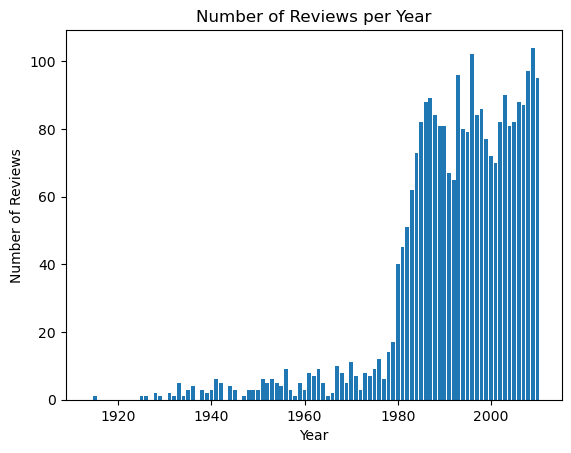

In [5]:
reviews_count_per_year = movies2_clean.groupby('year')['review'].count().reset_index()

plt.bar(reviews_count_per_year['year'], reviews_count_per_year['review'])
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews per Year')
plt.show()

# Structure

## 0) Overview of the data used 

## 1) Finding Potential pivotal movies

In this section, we will first analyze trends in specific genres of movies, focusing on those that are more niche and specific, such as Science Fiction, Teen, and Biography. The objective is to uncover patterns and insights within these specialized genres, as opposed to broader categories like Action or Adventure. We need to be careful to not choosing genre that are too niche because the set of movie will be too small to be analysed. 

After obtaining the trends we could be able to identify, for each trend, a subset of movies that could have strat the trend (i.e. pivotal movies)

In [6]:
# # Data Path
# DATA_PATH = '../data/'
# MOVIES_FOLDER = DATA_PATH+'MovieSummaries/'
# MOVIES_DATASET = MOVIES_FOLDER+"movie.metadata.tsv"

# # Load Data
# df_raw = pd.read_csv(MOVIES_DATASET, sep='\t', names=['id_wiki','id_freebase','name','date',
#                                                   'box_office','runtime','lang','countries','genres'])

In [7]:
# # MILESTONE P2
# movies = df_raw.copy()
# movies = data_missing(movies)
# movies = fuse_duplicates(movies, col_check=['name'], year='date', runtime='runtime',
#                          col_len=['lang', 'countries', 'genres'], col_null=['box_office', 'runtime'])
# movies = data_format(movies)
# movies.rename(columns={'box_office': 'revenue'}, inplace=True)  # maybe add this inside data_format ?
# movies.rename(columns={'date': 'year'}, inplace=True)           # maybe add this inside data_format ?
# movies = data_clean(movies)
# movies_all= movies.copy() # copy of all movies before filtering
# movies = data_filter(movies)

# MEHDI: USE movies DF WITHOUT MODIFYING IT FOR THIS SECTION !!!!

### a) Selection of niches genre

In [8]:
subsets = select_subsets(movies)
print('Number of subsets: {}'.format(len(subsets)))

Number of subsets: 244


### b) Trend graphs for some genres


Subset: Horror
	2571 | 28821 (size subset | movies)
	= 0.0892 %


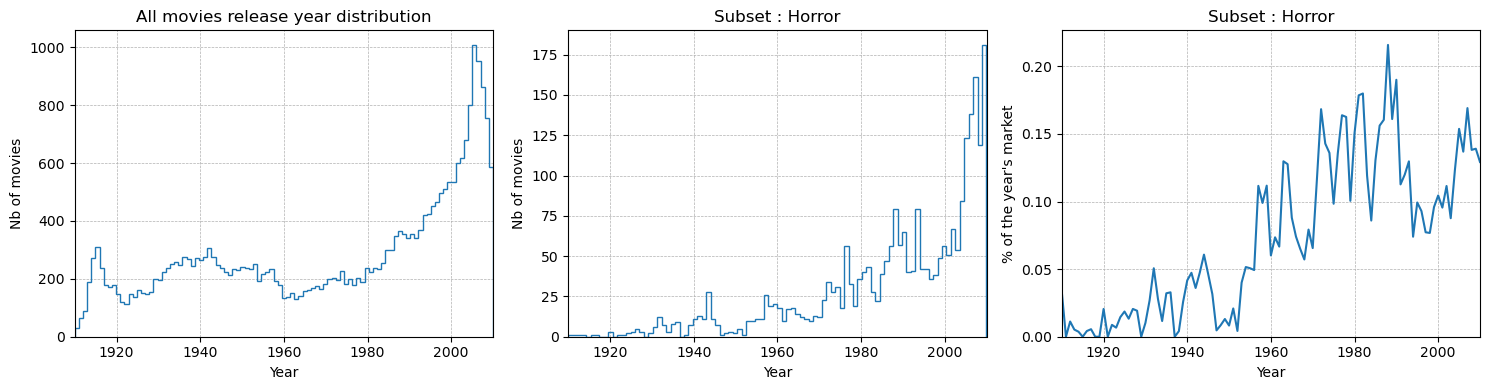

In [9]:
# VISUALIZE SUBSET i
i = find_subset(subsets, 'Horror')
viz_subset(i, subsets, movies)

### c) Trend automatic detection

In [10]:
QUALITY = 0.2

Peaks of subset Animation: [1937, 1955, 2006]
Quality of peaks: [0.8944550792731176, 0.10797647002213628, 0.2703500979062774]


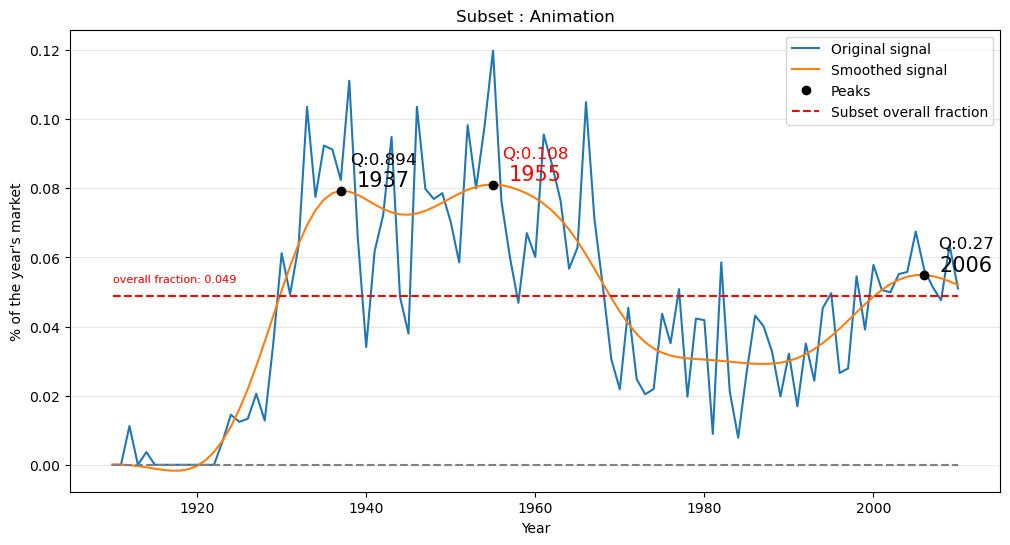

In [11]:
# VISUALIZE SUBSET i
i = find_subset(subsets, 'Animated Musical')
i = 17
print('Peaks of subset {}: {}'.format(subsets[i][0], get_peaks(movies, subsets, i)[0]))
print('Quality of peaks: {}'.format(get_peaks(movies, subsets, i)[1]))
fig = viz_peaks(movies, subsets, i)

In [12]:
trends = get_trends(movies, subsets, QUALITY)

print('Trend detection for 5 first subsets:')
display(trends[:10])

Trend detection for 5 first subsets:


[('Absurdism', [1977, 1995]),
 ('Action', [1974]),
 ('Action Comedy', []),
 ('Action Thrillers', [1975, 1995]),
 ('Action/Adventure', [1973]),
 ('Addiction Drama', [1955, 1995]),
 ('Adult', [1973]),
 ('Adventure', [1939]),
 ('Adventure Comedy', [1947, 1985]),
 ('Airplanes and airports', [1931, 1960, 1980])]

### d) Construction of potential pivotal movie sets 
 

In [13]:
candidates = get_candidates(subsets, trends)
print('Number of candidates: {}'.format(len(candidates)))
print('\nCandidates for first trend:')
show_candidates(candidates, 386)

Number of candidates: 387

Candidates for first trend:
Candidates of pivotal of genre Zombie Film, for trend in 2009


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
93,24039457,/m/0crx1wl,ZA: Zombies Anonymous,2005,NaN,118.0,[English Language],[USA],"[Parody, B-movie, Horror, Zombie Film]"
319,1033297,/m/0401sg,Resident Evil,2002,102441078.0,100.0,[English Language],"[USA, France, Canada, United Kingdom, Germany]","[Thriller, Science Fiction, Horror, Adventure,..."
1498,7585416,/m/0kvbvd,Route 666,2001,NaN,90.0,[English Language],"[USA, Canada]","[Zombie Film, Horror, Creature Film]"
5446,3238135,/m/090glv,House of the Dead,2003,13818181.0,90.0,[English Language],"[USA, Canada, Germany]","[Thriller, Horror, World cinema, Action/Advent..."
6565,5386187,/m/0djhtl,Vampires Vs. Zombies,2004,NaN,83.0,[English Language],[USA],"[Zombie Film, B-movie, Horror, Slasher, Indie]"
...,...,...,...,...,...,...,...,...,...
71005,915499,/m/03pkmt,Land of the Dead,2005,46770602.0,93.0,"[French Language, Polish Language, Italian Lan...","[USA, France, Canada]","[Thriller, Science Fiction, Horror, Indie, Doo..."
71072,4742175,/m/0ckyr9,Mortuary,2006,NaN,93.0,[English Language],[USA],"[Cult, Zombie Film, Horror]"
72297,13656791,/m/03cd6pg,The Stink of Flesh,2005,NaN,82.0,[English Language],[USA],"[Cult, Black comedy, Horror, Comedy, Zombie Film]"
73241,9396573,/m/02875q0,Zombie Town,2007,NaN,95.0,[English Language],[USA],"[Zombie Film, Horror, B-movie, Creature Film]"


### *) List of candidates for training

In [14]:
c = show_candidates(candidates, find_candidates(candidates,'Adventure',year='first')).dropna(subset=['revenue']).sort_values('year')
c[c.revenue>1000000]

Candidates of pivotal of genre Adventure, for trend in 1939


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
46842,2259030,/m/06zxb7,Tarzan the Ape Man,1932,2540000.0,189.0,[English Language],[USA],"[Action, Pre-Code, Adventure, Black-and-white]"
26841,16782,/m/048rn,King Kong,1933,1856000.0,100.0,[English Language],[USA],"[Monster movie, Horror, Adventure, Stop motion..."
38805,5482994,/m/0dnv98,Treasure Island,1934,1164000.0,103.0,[English Language],[USA],"[Swashbuckler films, Adventure, Black-and-whit..."
55990,61498,/m/0gnhr,"The Personal History, Adventures, Experience, ...",1935,1621000.0,130.0,[English Language],[USA],"[Adventure, Costume drama, Black-and-white, Dr..."
67731,3139727,/m/08tz29,The Crusades,1935,1700000.0,126.0,[English Language],[USA],"[Adventure, Costume drama, Historical fiction,..."
65206,62084,/m/0gssy,The Adventures of Robin Hood,1938,3981000.0,102.0,[English Language],[USA],"[Swashbuckler films, Adventure, Costume drama,..."


In [15]:
c = show_candidates(candidates, find_candidates(candidates,'Anime',year=2004)).dropna(subset=['revenue']).sort_values('year')
c[c.revenue>100]

Candidates of pivotal of genre Anime, for trend in 2004


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
8422,3228403,/m/01kzd_v,Ghost in the Shell,1995,2287714.0,85.0,"[Japanese Language, English Language, Spanish ...","[USA, Japan]","[Thriller, Science Fiction, Japanese Movies, A..."
70052,4198757,/m/0bpj6p,Space Truckers,1996,1614266.0,94.0,[English Language],"[USA, Ireland, United Kingdom]","[Science Fiction, Road movie, Comedy-drama, Sa..."
57261,2460704,/m/07fpw5,Pokémon: The First Movie,1998,163644662.0,95.0,"[Japanese Language, English Language]","[USA, Japan]","[Science Fiction, Fantasy Adventure, Japanese ..."
7823,5579355,/m/0dtjpk,Digimon: The Movie,2000,16643191.0,88.0,[English Language],"[USA, Japan]","[Thriller, Fantasy Adventure, Japanese Movies,..."
47494,4648834,/m/0cfdsq,Pokémon: Spell Of The Unown,2001,68411275.0,91.0,"[Japanese Language, English Language]","[USA, Japan]","[Japanese Movies, World cinema, Animation, Act..."
59000,11242,/m/02_qt,Final Fantasy: The Spirits Within,2001,85131830.0,106.0,[English Language],"[USA, Japan]","[Science Fiction, Japanese Movies, Adventure, ..."
50561,1989045,/m/06c805,Pokémon 4Ever,2002,28023563.0,81.0,"[Japanese Language, English Language]","[USA, Japan]","[Fantasy Adventure, Japanese Movies, Adventure..."
27047,1489050,/m/055crg,Pokémon Heroes,2003,20867919.0,68.0,"[Japanese Language, English Language]","[USA, Japan]","[Fantasy Adventure, Japanese Movies, World cin..."


In [16]:
c = show_candidates(candidates, find_candidates(candidates,'Erotic thriller',year='first')).dropna(subset=['revenue']).sort_values('year')
c[c.revenue>100000000]

Candidates of pivotal of genre Erotic thriller, for trend in 1994


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
1243,129295,/m/0yx7h,Fatal Attraction,1987,320145693.0,119.0,[English Language],[USA],"[Thriller, Horror, Mystery, Psychological thri..."
5317,2541839,/m/07lz72,Sea of Love,1989,110879513.0,113.0,[English Language],[USA],"[Thriller, Crime Fiction, Detective, Mystery, ..."
13690,481649,/m/02fqxm,Basic Instinct,1992,352927224.0,127.0,[English Language],"[USA, France]","[LGBT, Thriller, Mystery, Psychological thrill..."
49572,11059900,/m/02qzmz6,Sliver,1993,116300000.0,107.0,[English Language],[USA],"[Thriller, Erotic thriller, Romance Film, Psyc..."


In [17]:
c = show_candidates(candidates, find_candidates(candidates,'Family Film',year='first')).dropna(subset=['revenue']).sort_values('year')
c[c.revenue>1000000]

Candidates of pivotal of genre Family Film, for trend in 1937


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
20859,2175661,/m/06sjhv,Little Women,1933,2000000.0,115.0,"[English Language, German Language]",[USA],"[Costume drama, Family Drama, Black-and-white,..."
38805,5482994,/m/0dnv98,Treasure Island,1934,1164000.0,103.0,[English Language],[USA],"[Swashbuckler films, Adventure, Black-and-whit..."
52056,74962,/m/0jz2p,Modern Times,1936,8663577.0,85.0,[English Language],[USA],"[Silent film, Satire, Drama, Comedy, Family Film]"


In [18]:
c = show_candidates(candidates, find_candidates(candidates,'Film noir',year='first')).dropna(subset=['revenue']).sort_values('year')
c[c.revenue>3000000]

Candidates of pivotal of genre Film noir, for trend in 1949


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
40680,74984,/m/0jz89,Suspicion,1941,4500000.0,99.0,[English Language],[USA],"[Thriller, Mystery, Romance Film, Film noir]"
3898,1056686,/m/0426cx,Cat People,1942,4000000.0,73.0,"[Czech Language, English Language, Serbian lan...",[USA],"[Thriller, Romance Film, Horror, Black-and-whi..."
21245,73438,/m/0jqly,Double Indemnity,1944,5000000.0,108.0,[English Language],[USA],"[Thriller, Crime Fiction, Drama, Film noir]"
45395,2279601,/m/070fnm,Gaslight,1944,4613000.0,114.0,[English Language],[USA],"[Thriller, Costume drama, Psychological thrill..."
73261,80488,/m/0ktpx,Spellbound,1945,7000000.0,110.0,[English Language],[USA],"[Thriller, Therimin music, Psychological thril..."
43303,1397142,/m/04zb7s,Key Largo,1948,8125000.0,101.0,[English Language],[USA],"[Crime Fiction, Thriller, Gangster Film, Black..."


In [19]:
c = show_candidates(candidates, find_candidates(candidates,'Gangster Film',year='first')).dropna(subset=['revenue']).sort_values('year')
c[c.revenue>3000000]

Candidates of pivotal of genre Gangster Film, for trend in 1974


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
22195,1449256,/m/052g_x,Point Blank,1967,3500000.0,92.0,[English Language],[USA],"[Thriller, Crime Fiction, Gangster Film, Myste..."
23174,68245,/m/0hvvf,Bonnie and Clyde,1967,50700000.0,112.0,[English Language],[USA],"[Crime Fiction, Heist, Gangster Film, Crime Dr..."
12776,1235054,/m/04kvfm,Across 110th Street,1972,10000000.0,102.0,[English Language],[USA],"[Thriller, Crime Fiction, Gangster Film, Actio..."
33310,2466773,/m/07g1sm,The Godfather,1972,268500000.0,177.0,"[Latin Language, Italian Language, Sicilian La...",[USA],"[Crime Fiction, Gangster Film, Crime Drama, Fa..."
55357,62440,/m/0gw7p,The Sting,1973,159616327.0,129.0,[English Language],[USA],"[Crime Fiction, Buddy film, Gangster Film, Per..."


In [20]:
c = show_candidates(candidates, find_candidates(candidates,'Heist',year='first')).dropna(subset=['revenue']).sort_values('year')
c[c.revenue>3000000]

Candidates of pivotal of genre Heist, for trend in 1972


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
23174,68245,/m/0hvvf,Bonnie and Clyde,1967,50700000.0,112.0,[English Language],[USA],"[Crime Fiction, Heist, Gangster Film, Crime Dr..."
50762,5719024,/m/0f0_04,The War Wagon,1967,6000000.0,101.0,[English Language],[USA],"[Action/Adventure, Heist, Western, Caper story]"
67369,2367145,/m/076y2d,The Thomas Crown Affair,1968,14000000.0,102.0,[English Language],[USA],"[Crime Fiction, Heist, Thriller, Crime Thriller]"
20651,933321,/m/03r8x1,Kelly's Heroes,1970,5200000.0,149.0,"[French Language, German Language, English Lan...","[USA, Yugoslavia, Socialist Federal Republic o...","[Crime Fiction, Heist, Adventure, Anti-war, Ac..."


In [21]:
c = show_candidates(candidates, find_candidates(candidates,'Monster movie',year='first')).dropna(subset=['revenue']).sort_values('year')
c[c.revenue>10000]

Candidates of pivotal of genre Monster movie, for trend in 1960


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
27435,76387,/m/0k4lt,The Thing,1951,1950000.0,87.0,[English Language],[USA],"[Monster movie, Therimin music, Science Fictio..."
26322,72317,/m/0jhpk,Creature from the Black Lagoon,1954,1300000.0,80.0,[English Language],[USA],"[Monster movie, Science Fiction, Horror, Adven..."


In [22]:
c = show_candidates(candidates, find_candidates(candidates,'Teen',year='first')).dropna(subset=['revenue']).sort_values('year')
c[c.revenue>100000000]

Candidates of pivotal of genre Teen, for trend in 1986


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
186,336846,/m/01xlqd,Grease,1978,394589888.0,225.0,[English Language],[USA],"[Romantic comedy, LGBT, Musical, Comedy, Roman..."
60939,284957,/m/01pwpj,Porky's,1982,111289673.0,94.0,[English Language],"[USA, Canada]","[Sex comedy, Coming of age, Comedy, Teen]"


In [23]:
c = show_candidates(candidates, find_candidates(candidates,'Zombie Film',year=2009)).sort_values('year').dropna(subset=['revenue'])
c[c.revenue>100000000]

Candidates of pivotal of genre Zombie Film, for trend in 2009


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
319,1033297,/m/0401sg,Resident Evil,2002,102441078.0,100.0,[English Language],"[USA, France, Canada, United Kingdom, Germany]","[Thriller, Science Fiction, Horror, Adventure,..."
11998,538455,/m/02my7z,Dawn of the Dead,2004,102356381.0,101.0,[English Language],"[USA, France, Japan, Canada]","[Thriller, Science Fiction, Horror, Doomsday f..."
62240,2271177,/m/06_sc3,Resident Evil: Extinction,2007,147717833.0,88.0,[English Language],"[USA, France, Australia, United Kingdom, Germany]","[Thriller, Science Fiction, Horror, Sci-Fi Hor..."
10634,6641931,/m/0gfsq9,I Am Legend,2007,585349010.0,100.0,[English Language],[USA],"[Thriller, Albino bias, Science Fiction, Horro..."


### *) Save all subsets visualizations as images

In [24]:
#get_all_viz(movies, subsets)

## 2) Metric assessment for Pivotal Movies identification

Identifying the pivotal movie, or the one that starts a trend, involves a combination of qualitative and quantitative analysis. Here are considerations and steps to help define the chosen pivotal movie within a specific genre:

 - **Box-office Revenue :**
    Analyze the box-office performance of candidate movies within the subset. The pivotal movie often exhibits exceptional financial success, indicating a strong audience demand for the particular genre or theme. We need then to look for movies that surpassed industry expectations in terms of revenue. Also comparing the box-office performance of candidate movies to industry standards and consider their impact on subsequent films' budgeting and revenue expectations.

- **Reviews :**
   Critical reception is a key indicator of a movie's impact and lasting influence. The pivotal movie should have received positive reviews from both critics and audiences, showcasing its quality and appeal. To this aims we incorporate a new dataset that includes review. These review will be a measuremnent of how good a movie is . This metric is fundamental to identify the pivotal movie : if a film is considered as bad there is no chance that it influence the cinema industry and creating a trend.

- **Awards :**
Another measure for assessing influence is the recognition garnered through awards. Industry accolades serve as a validation of a movie's cultural and artistic significance. The receipt of awards signifies not only the excellence of the film but also its potential to set a standard worth emulating. It provides more precise insights into why the film is esteemed. Noteworthy awards include prestigious honors like the Oscars. In our analysis, we have opted to incorporate a dataset that encompasses these awards and their respective categories.

- **Plot Similarity:**
  This metric serves as an assessment of the extent to which a film influences others within the genre during trends. The concept is as follows: if the plot of a potential pivotal film closely resembles those observed in subsequent trend films when compared to other movies in the candidate subset, it indicates the film's influence on plot development. This similarity suggests that other films intentionally emulated the storyline, signifying the impactful nature of the pivotal film.



All these metrics will be exploited to select the pivotal film among the candidate subset. But to use it we need to properly define function which calculate from available data or simply add missing data from other dataset.


## Further cleaning and data gathering

In [25]:
# Start with the pre-merge df of Milestone 2:

display(movies.sample(5))
display(movies.shape)
display(movies.info())
generate_missing_info(movies)

,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
46914,828607,/m/03ffzz,Savior,1998,NaN,104.0,"[Serbo-Croatian, English Language]",[USA],"[Drama, Political drama, War film]"
48023,2933385,/m/08dl83,Freddy's Dead: The Final Nightmare,1991,34872033.0,90.0,[English Language],[USA],"[Cult, Horror, Slasher, Teen, Supernatural]"
68928,9550478,/m/02pjnb_,Soldier Boyz,1995,NaN,90.0,[English Language],[USA],"[Thriller, Action, Drama]"
21983,33949342,/m/0hndy6n,Peach O'Reno,1931,570000.0,63.0,[English Language],[USA],"[Comedy film, Romance Film]"
5232,2137591,/m/06pkq3,The Four Horsemen of the Apocalypse,1921,4500000.0,134.0,"[Silent film, English Language]",[USA],"[Silent film, Indie, Black-and-white, Drama, W..."


(28821, 9)

<class 'pandas.core.frame.DataFrame'>
Index: 28821 entries, 0 to 74827
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_wiki      28821 non-null  int64  
 1   id_freebase  28821 non-null  object 
 2   name         28821 non-null  object 
 3   year         28821 non-null  int32  
 4   revenue      6466 non-null   float64
 5   runtime      25712 non-null  float64
 6   lang         28821 non-null  object 
 7   countries    28821 non-null  object 
 8   genres       28821 non-null  object 
dtypes: float64(2), int32(1), int64(1), object(5)
memory usage: 2.1+ MB


None

,Missing Data (%)
Column,
id_wiki,0.00
id_freebase,0.00
name,0.00
year,0.00
revenue,77.56
runtime,10.79
lang,0.00
countries,0.00
genres,0.00


### Cleaning big IMDB dataset

In [26]:
IMDB_PATH = '/imdb_ratings_all_time/movies_imdb.csv'

imdb_vanilla = pd.read_csv(DATA_PATH+IMDB_PATH, usecols=['id', 'name', 'year', 'rating', 'duration', 'votes', 'gross_income'], low_memory=False)

display(imdb_vanilla.sample(5))
display(imdb_vanilla.shape)
display(imdb_vanilla.info())
display(imdb_vanilla.isnull().sum())
display(imdb_vanilla[imdb_vanilla['gross_income']!='0'].sample(5))

,id,name,year,rating,duration,votes,gross_income
807327,tt4696562,Let's Make a Deal,(2009– ),11.0,0 min,0,0
431510,tt10883346,Virtual Bharat,(2019– ),11.0,0 min,0,0
1594069,tt3354552,Hooked on the Fly,(2009– ),11.0,0 min,0,0
1149670,tt12102638,Nintama Rantarô,(1993– ),11.0,0 min,0,0
1607714,tt4545586,The Jungle Bunch,(2013– ),11.0,0 min,0,0


(2590932, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2590932 entries, 0 to 2590931
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   name          object 
 2   year          object 
 3   rating        float64
 4   duration      object 
 5   votes         object 
 6   gross_income  object 
dtypes: float64(1), object(6)
memory usage: 138.4+ MB


None

id              0
name            4
year            0
rating          0
duration        0
votes           0
gross_income    0
dtype: int64

,id,name,year,rating,duration,votes,gross_income
1468758,tt0059963,Adam Adamant Lives!,(1966–1967),7.0,50 min,219,"28,791"
1318820,tt0125648,Tales of the Unexpected,(1977),7.3,60 min,128,"626,724"
196154,tt0090248,Vampire Hunter D,(1985),7.1,80 min,"15,737","23,000"
1004182,tt3746824,Sheep & Wolves,(2016),5.8,85 min,"3,216","190,511"
8783,tt0070534,The Knock Out Cop,(1973),6.7,99 min,"3,795","85,363"


In [27]:
imdb = imdb_vanilla.copy(deep=True)

# Let's get rid of the missing movie names
imdb = imdb_vanilla.loc[~imdb_vanilla.name.isnull()]

# Cleaning the year column: removing some characters and extracting starting year only
imdb = imdb[~imdb['year'].astype(str).str.contains('-|–')]
imdb.loc[:, 'year'] = imdb['year'].str.extract(r'(\d+)', expand=False)
imdb['year'] = imdb['year'].replace('', np.nan)
imdb['year'] = pd.to_numeric(imdb['year'], errors='coerce')
imdb.loc[:, 'year'] = imdb['year'].astype('Int64', errors='ignore')

# Dataframe is huge, and we do not care about movies post-2017: let's reduce it a bit
imdb = imdb[imdb['year'] <= 2017].reset_index(drop=True)

# From gross income, remove undesired characters and turn to float:
imdb.loc[:, 'gross_income'] = imdb['gross_income'].apply(lambda x: clean_gross_income(x))
imdb['gross_income'] = pd.to_numeric(imdb['gross_income'], errors='coerce')
imdb.loc[:, 'gross_income'] = imdb['gross_income'].replace(0, np.nan)

# From votes, remove undesired characters and turn to float:
imdb.loc[:, 'votes'] = imdb['votes'].str.replace(',', '').astype(float)
imdb.loc[:, 'votes'] = imdb['votes'].replace(0, np.nan)
imdb.loc[pd.isna(imdb['votes']), 'rating'] = np.nan
imdb = imdb[imdb['rating'] <= 10]

# Extract number from duration:
imdb.loc[:, 'duration'] = imdb['duration'].str.extract(r'(\d+)', expand=False)
imdb.loc[:,'duration'] = imdb['duration'].astype(float)
imdb.loc[:, 'duration'] = imdb['duration'].replace(0, np.nan)
imdb['duration'] = pd.to_numeric(imdb['duration'], errors='coerce')  

display(imdb.sample(5))
display(imdb.shape)
display(imdb.info())
display(imdb[~(imdb['gross_income'].isna())!=0].sample(5))

,id,name,year,rating,duration,votes,gross_income
22875,tt0124300,Brevet fra afdøde,1946,6.4,78.0,21.0,NaN
367485,tt0050420,Fury at Showdown,1957,6.2,75.0,301.0,NaN
384308,tt4596784,The Walls of the Moon,2015,5.9,101.0,406.0,NaN
149852,tt3247420,Arangsaddojeon,2012,8.1,63.0,8.0,NaN
507109,tt1236297,My Own Worst Enemy,2008,7.0,43.0,121.0,NaN


(251689, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 251689 entries, 0 to 635804
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            251689 non-null  object 
 1   name          251689 non-null  object 
 2   year          251689 non-null  Int64  
 3   rating        251689 non-null  float64
 4   duration      214143 non-null  float64
 5   votes         251689 non-null  object 
 6   gross_income  29023 non-null   float64
dtypes: Int64(1), float64(3), object(3)
memory usage: 15.6+ MB


None

,id,name,year,rating,duration,votes,gross_income
56813,tt0098193,The Return of Swamp Thing,1989,4.6,88.0,5549.0,192816.0
165631,tt0120982,Little Shop,1991,4.3,30.0,120.0,2864844.0
164405,tt0053285,睡美人,1959,7.2,75.0,146921.0,51600000.0
119578,tt0047975,The Dark Avenger,1955,5.8,85.0,653.0,136166.0
4940,tt0210671,The Escort III,1999,4.3,90.0,157.0,24376.0


In [28]:
# Year and duration are elements used to detect and fuse duplicates: need them clean
imdb = imdb.dropna(subset=['year', 'duration'])

# If both votes and gross_income are unknown, then the row is of no use
imdb = imdb.dropna(subset=['votes', 'gross_income'], how='all').reset_index(drop=True)

display(imdb.sample(5))
display(imdb.shape)
display(imdb.info())
generate_missing_info(imdb)

,id,name,year,rating,duration,votes,gross_income
58998,tt1904887,En fiende att dö för,2012,5.8,106.0,935.0,NaN
13762,tt0026971,A Scream in the Night,1935,4.3,58.0,212.0,NaN
139387,tt0092844,Witness in the War Zone,1987,5.4,100.0,510.0,141211.0
135771,tt0031929,Six-Gun Rhythm,1939,5.5,57.0,71.0,NaN
73413,tt1380130,Jos rakastat,2010,5.0,123.0,428.0,NaN


(214143, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214143 entries, 0 to 214142
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            214143 non-null  object 
 1   name          214143 non-null  object 
 2   year          214143 non-null  Int64  
 3   rating        214143 non-null  float64
 4   duration      214143 non-null  float64
 5   votes         214143 non-null  object 
 6   gross_income  27935 non-null   float64
dtypes: Int64(1), float64(3), object(3)
memory usage: 11.6+ MB


None

,Missing Data (%)
Column,
id,0.00
name,0.00
year,0.00
rating,0.00
duration,0.00
votes,0.00
gross_income,86.95


In [29]:
# Are there any doublons ?

display(check_doublons(imdb, col_check=['name'], year='year', runtime='duration'))
display(imdb[(imdb['name']=='Unconditional') & (imdb['year']==2012)]) 
display(imdb[(imdb['name']=='Blood Money') & (imdb['year']==2012)]) 
display(imdb[(imdb['name']=='Star Wars') & (imdb['year']==1977)]) 

Rows with real duplicates: 
                              name  year  duration
3134                 Unconditional  2012      92.0
4210                   Blood Money  2012     109.0
12047   The Game Ain't 4 Everybody  2009     105.0
13546                      Misfits  2015      20.0
14199          Trouble in Paradise  1989     100.0
...                            ...   ...       ...
214138                   Game Face  2017      42.0
214139                   Game Face  2017      42.0
214140                   Game Face  2017      42.0
214141                   Game Face  2017      42.0
214142                   Game Face  2017      42.0

[10243 rows x 3 columns]
--------------------------------------------------------------------------------


None

,id,name,year,rating,duration,votes,gross_income
3134,tt1758610,Unconditional,2012,7.0,92.0,4800.0,1005800.0
199175,tt1967651,Unconditional,2012,6.5,92.0,741.0,NaN


,id,name,year,rating,duration,votes,gross_income
4210,tt2246595,Blood Money,2012,5.0,109.0,1480.0,NaN
189060,tt1753521,Blood Money,2012,3.2,109.0,592.0,74491.0


,id,name,year,rating,duration,votes,gross_income
147390,tt0076759,Star Wars,1977,8.6,121.0,1332366.0,322740140.0


In [30]:
# Need to fuse the duplicates, but the dataframe is huge so let's use Spark to go faster
imdb_clean = imdb.copy(deep=True)

imdb_clean = fuse_duplicates_imdb(imdb_clean)
imdb_clean = calculate_weighted_average(imdb_clean, 'name', 'rating', 'votes')

display(imdb_clean.sample(5))
display(imdb_clean.shape)
display(imdb_clean.info())

,id,name,year,rating,duration,votes,gross_income
192937,tt0164455,Revolt of the Dragon,1974,4.9,83.0,78.0,NaN
149701,tt1159223,Love Now,2007,6.0,116.0,366.0,676166.0
63406,tt3759900,Modern Ruin: A World's Fair Pavilion,2015,7.9,78.0,8.0,NaN
65218,tt4678238,The Cambodian Space Project: Not Easy Rock'n'Roll,2015,8.3,75.0,20.0,NaN
136929,tt0028448,The Unknown Ranger,1936,4.8,57.0,26.0,NaN


(205729, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 205729 entries, 0 to 214136
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            205729 non-null  object 
 1   name          205729 non-null  object 
 2   year          205729 non-null  Int64  
 3   rating        205729 non-null  float64
 4   duration      205729 non-null  float64
 5   votes         205729 non-null  float64
 6   gross_income  27934 non-null   float64
dtypes: Int64(1), float64(4), object(2)
memory usage: 12.8+ MB


None

In [31]:
# Merge successful ?
display(imdb_clean[(imdb_clean['name']=='Unconditional') & (imdb_clean['year']==2012)]) 
display(imdb_clean[(imdb_clean['name']=='Blood Money') & (imdb_clean['year']==2012)])
display(check_doublons(imdb_clean, col_check=['name'], year='year', runtime='duration'))
# Yes !

,id,name,year,rating,duration,votes,gross_income
3134,tt1758610,Unconditional,2012,6.9,92.0,5541.0,1005800.0


,id,name,year,rating,duration,votes,gross_income
4210,tt2246595,Blood Money,2012,4.5,109.0,2072.0,74491.0


No duplicates
--------------------------------------------------------------------------------


None

### Original name map

In [32]:
NAME_MAP_PATH = '/imdb_ratings_all_time/imdb_title_map.tsv'

name_map_vanilla = pd.read_csv(DATA_PATH+NAME_MAP_PATH, sep='\t', usecols=['tconst', 'primaryTitle', 'originalTitle', 'startYear', 'runtimeMinutes']).rename(columns={'originalTitle': 'name',
                                                                                                                                                        'startYear': 'year',
                                                                                                                                                        'runtimeMinutes': 'duration'})

display(name_map_vanilla.sample(5))
display(name_map_vanilla.shape)
display(name_map_vanilla.info())

,tconst,primaryTitle,name,year,duration
8887225,tt6620452,Episode #1.14,Episode #1.14,\N,\N
3713026,tt15031900,Episode #1.130,Episode #1.130,\N,\N
8043973,tt4717410,Episode dated 2 July 2002,Episode dated 2 July 2002,2002,\N
4630698,tt1742056,Le mimi à sa mémère,Le mimi à sa mémère,1908,\N
2127659,tt12091026,Morning Hangout,Morning Hangout,2019,\N


(9387091, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9387091 entries, 0 to 9387090
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   tconst        object
 1   primaryTitle  object
 2   name          object
 3   year          object
 4   duration      object
dtypes: object(5)
memory usage: 358.1+ MB


None

In [33]:
# This dataframe is the key to overcome the "Star Wars" problem
# (ie: nomenclature changes for same movie across dataframes)

display(name_map_vanilla[name_map_vanilla['name']=='Star Wars'].head(1))
display(imdb_clean[imdb_clean['name']=='Star Wars'])
display(movies[movies['name'].str.contains('Star Wars Episode VI: Return of the Jedi')])

,tconst,primaryTitle,name,year,duration
75141,tt0076759,Star Wars: Episode IV - A New Hope,Star Wars,1977,121


,id,name,year,rating,duration,votes,gross_income
147390,tt0076759,Star Wars,1977,8.6,121.0,1332366.0,322740140.0


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
14376,50744,/m/0ddjy,Star Wars Episode VI: Return of the Jedi,1983,475106177.0,135.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."


In [34]:
# Extract duration in minutes
name_map_vanilla['duration'] = name_map_vanilla['duration'].str.extract('(\d+\.\d+|\d+)').astype(float)
# If there are non-numeric values, replace them with np.nan
name_map_vanilla['duration'] = name_map_vanilla['duration'].replace('', np.nan)

# Extract year
name_map_vanilla['year'] = name_map_vanilla['year'].str.extract('(\d+)').astype(float)
# If there are non-numeric values, replace them with np.nan
name_map_vanilla['year'] = name_map_vanilla['year'].replace('', np.nan)
name_map_vanilla.loc[:, 'year'] = name_map_vanilla['year'].astype('Int64', errors='ignore')

# Get rid of missing data in duration and year
name_map = name_map_vanilla.copy(deep=True)
name_map = name_map_vanilla.dropna(subset=['duration', 'year']).reset_index(drop=True)

display(name_map.sample(5))
display(name_map.shape)
display(name_map.info())
generate_missing_info(name_map)


,tconst,primaryTitle,name,year,duration
712596,tt11243252,Glück Gehabt,Glück Gehabt,2019,101.0
2577432,tt7279438,Episode #1.43,Episode #1.43,1978,30.0
265324,tt0386122,Playboy: Women of Starbucks,Playboy: Women of Starbucks,2003,55.0
1780249,tt27368184,Episode #3.1,Episode #3.1,2023,48.0
2641500,tt7705682,Não Consegues Criar O Mundo Duas Vezes,Não Consegues Criar O Mundo Duas Vezes,2017,155.0


(2644199, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644199 entries, 0 to 2644198
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   tconst        object 
 1   primaryTitle  object 
 2   name          object 
 3   year          Int64  
 4   duration      float64
dtypes: Int64(1), float64(1), object(3)
memory usage: 103.4+ MB


None

,Missing Data (%)
Column,
tconst,0.0
primaryTitle,0.0
name,0.0
year,0.0
duration,0.0


In [35]:
# Are there any doublons ?
check_doublons(name_map, col_check=['name'], year='year', runtime='duration')

# If that's the case let's drop the doublons
name_map_clean = drop_duplicates(name_map, col_check=['name', 'year', 'duration'])

display(check_doublons(name_map_clean, col_check=['name'], year='year', runtime='duration'))
display(name_map_clean.sample(5))
display(name_map_clean.shape)
display(name_map_clean.info())
generate_missing_info(name_map_clean)

Rows with real duplicates: 
                           name  year  duration
103      The Kiss in the Tunnel  1899       1.0
1262      Bread Upon the Waters  1913      11.0
1334          The Doctor's Duty  1913      11.0
1385                 Flood Tide  1913      11.0
1480                  The Idler  1914      11.0
...                         ...   ...       ...
2644083           Episode #1.10  2017      55.0
2644084            Episode #1.3  2017      55.0
2644129                  Broken  2017       4.0
2644167               Avsnitt 3  2017      44.0
2644168               Avsnitt 4  2017      45.0

[178245 rows x 3 columns]
--------------------------------------------------------------------------------
No duplicates
--------------------------------------------------------------------------------


None

,tconst,primaryTitle,name,year,duration
2495097,tt6634052,Don't Want Your Love,Don't Want Your Love,2017,4.0
81102,tt0095613,Memories of Me,Memories of Me,1988,105.0
1801468,tt27600153,Episode #1.404,Episode #1.404,2023,22.0
730608,tt11399962,Finlandia 56,Finlandia 56,1957,8.0
439499,tt0719906,The Gunfighter,The Gunfighter,1959,30.0


(2526746, 5)

<class 'pandas.core.frame.DataFrame'>
Index: 2526746 entries, 0 to 2644198
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   tconst        object 
 1   primaryTitle  object 
 2   name          object 
 3   year          Int64  
 4   duration      float64
dtypes: Int64(1), float64(1), object(3)
memory usage: 118.1+ MB


None

,Missing Data (%)
Column,
tconst,0.0
primaryTitle,0.0
name,0.0
year,0.0
duration,0.0


### IMDB MERGE

In [36]:
imdb_final = pd.merge(name_map_clean, imdb_clean, on=['name', 'year', 'duration'], how='right').drop(columns={'tconst', 'id'}).rename(columns={'primaryTitle': 'alt_name',
                                                                                                                                                'duration': 'runtime', 
                                                                                                                                                'gross_income': 'revenue'})

display(imdb_final.sample(5))
display(imdb_final.shape)
display(imdb_final.info())
generate_missing_info(imdb_final)

,alt_name,name,year,runtime,rating,votes,revenue
162313,Far,Far,2012,23.0,8.2,49.0,NaN
161189,Yellow,Yellow,2006,4.0,5.8,583.0,NaN
100658,NaN,The Rolling Stones: Hey Negrita,1976,5.0,5.9,12.0,NaN
125014,Misfits,Misfits,1997,1.0,3.0,8.0,NaN
73828,Montreal Blues,Montréal blues,1972,100.0,6.0,11.0,NaN


(205729, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205729 entries, 0 to 205728
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   alt_name  158007 non-null  object 
 1   name      205729 non-null  object 
 2   year      205729 non-null  Int64  
 3   runtime   205729 non-null  float64
 4   rating    205729 non-null  float64
 5   votes     205729 non-null  float64
 6   revenue   27934 non-null   float64
dtypes: Int64(1), float64(4), object(2)
memory usage: 11.2+ MB


None

,Missing Data (%)
Column,
alt_name,23.20
name,0.00
year,0.00
runtime,0.00
rating,0.00
votes,0.00
revenue,86.42


In [37]:
# The "Star Wars" problem is taken care of

display(imdb_final[imdb_final['name']=='Star Wars'])

,alt_name,name,year,runtime,rating,votes,revenue
141635,Star Wars: Episode IV - A New Hope,Star Wars,1977,121.0,8.6,1332366.0,322740140.0


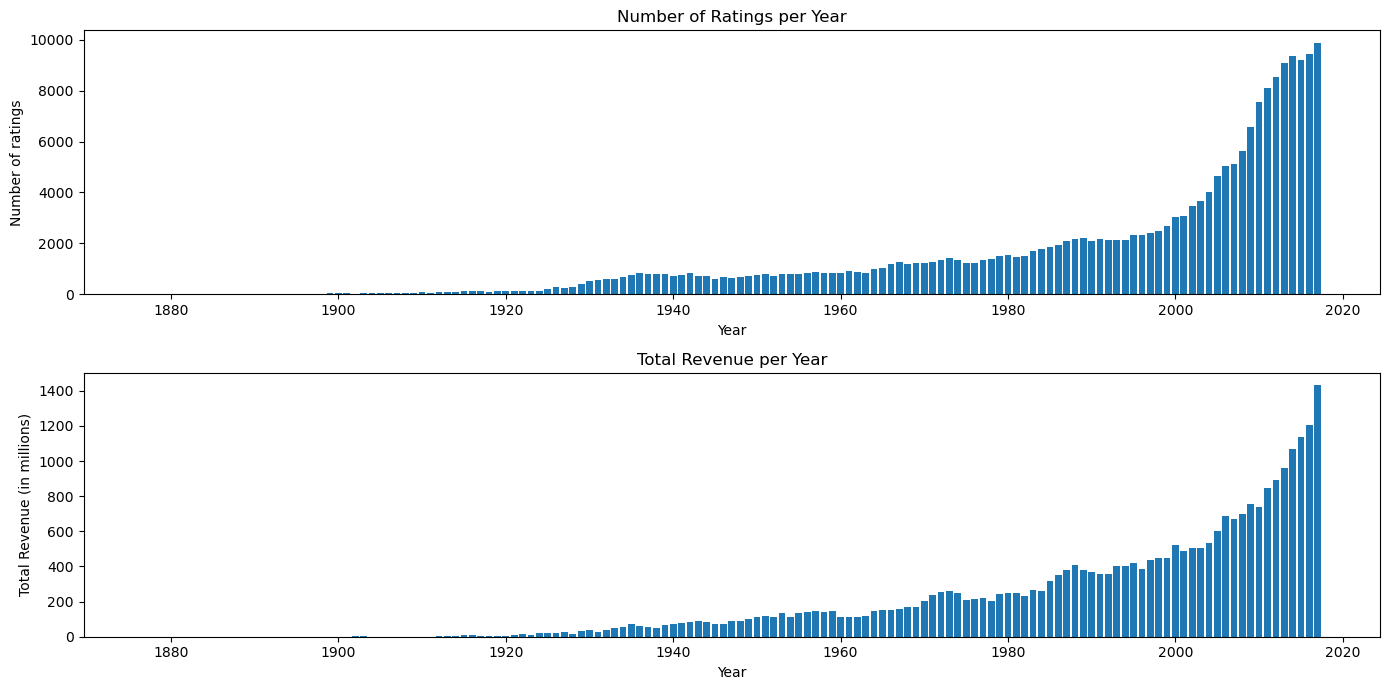

In [38]:
revenue_per_year_imdb = imdb_final.groupby('year')['revenue'].count().reset_index()
reviews_count_per_year_imdb = imdb_final.groupby('year')['rating'].count().reset_index()

fig = plt.figure(figsize=(14, 7))

# Plot for number of ratings per year
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.bar(reviews_count_per_year_imdb['year'], reviews_count_per_year_imdb['rating'])
plt.xlabel('Year')
plt.ylabel('Number of ratings')
plt.title('Number of Ratings per Year')

# Plot for revenue per year
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.bar(revenue_per_year_imdb['year'], revenue_per_year_imdb['revenue'])
plt.xlabel('Year')
plt.ylabel('Total Revenue (in millions)')
plt.title('Total Revenue per Year')

plt.tight_layout()
plt.show()

In [39]:
# To make it ready for future merges: clean the names to get rid of some characters and trailing white spaces
imdb_final['alt_name'] = imdb_final['alt_name'].apply(lambda x: str(x).replace('-', '').replace(':', ''))
imdb_final['alt_name'] = imdb_final['alt_name'].str.replace('\s+', ' ', regex=True).str.strip()
imdb_final['name'] = imdb_final['name'].apply(lambda x: str(x).replace('-', '').replace(':', ''))
imdb_final['name'] = imdb_final['name'].str.replace('\s+', ' ', regex=True).str.strip()

display(imdb_final[imdb_final['name']=='Star Wars'])

,alt_name,name,year,runtime,rating,votes,revenue
141635,Star Wars Episode IV A New Hope,Star Wars,1977,121.0,8.6,1332366.0,322740140.0


### IMDB_FINAL & MOVIELENS MERGE

In [40]:
# Loading the cleaned movie_lens dataframe from Milestone 2
movies_lens = movies_lens.rename(columns={'review': 'rating', 'nbr_review': 'votes'})

# To make it ready for future merges: clean the names to get rid of some characters and trailing white spaces

movies_lens['name'] = movies_lens['name'].apply(lambda x: str(x).replace('-', '').replace(':', ''))
movies_lens['name'] = movies_lens['name'].str.replace('\s+', ' ', regex=True).str.strip()

display(movies_lens.sample(5))
display(movies_lens.shape)
display(movies_lens.info())

,revenue,runtime,name,rating,votes,year
3388,20138836.0,122.0,The Namesake,6.8,50.0,2006
2364,8000000.0,91.0,Never on Sunday,6.0,14.0,1960
1597,345141403.0,104.0,How the Grinch Stole Christmas,6.2,1440.0,2000
3163,66966987.0,87.0,When a Stranger Calls,5.4,273.0,2006
1943,20117339.0,147.0,Mulholland Drive,7.7,1517.0,2001


(5619, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5619 entries, 0 to 5618
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   revenue  5619 non-null   float64
 1   runtime  5619 non-null   float64
 2   name     5619 non-null   object 
 3   rating   5619 non-null   float64
 4   votes    5619 non-null   float64
 5   year     5619 non-null   int32  
dtypes: float64(4), int32(1), object(1)
memory usage: 241.6+ KB


None

In [41]:
annex = pd.merge(movies_lens, imdb_final, on=['name', 'year', 'runtime'], how='right')

display(annex.sample(5))
display(annex.shape)
display(annex.info())
generate_missing_info(annex)

,revenue_x,runtime,name,rating_x,votes_x,year,alt_name,rating_y,votes_y,revenue_y
83021,NaN,100.0,Kiss Live in Las Vegas,NaN,NaN,2002,Kiss Live in Las Vegas,6.0,74.0,NaN
88454,NaN,132.0,Heart Beat,NaN,NaN,1983,nan,6.3,8.0,NaN
61423,NaN,50.0,Camminando sull'acqua,NaN,NaN,2016,Camminando sull'acqua,8.0,7.0,NaN
149731,NaN,76.0,To the Mountain,NaN,NaN,2017,To the Mountain,6.1,64.0,NaN
152059,NaN,97.0,The Record Is Equal To The Document,NaN,NaN,2017,The Record Is Equal To The Document,4.4,175.0,NaN


(205729, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205729 entries, 0 to 205728
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   revenue_x  3111 non-null    float64
 1   runtime    205729 non-null  float64
 2   name       205729 non-null  object 
 3   rating_x   3111 non-null    float64
 4   votes_x    3111 non-null    float64
 5   year       205729 non-null  Int64  
 6   alt_name   205729 non-null  object 
 7   rating_y   205729 non-null  float64
 8   votes_y    205729 non-null  float64
 9   revenue_y  27934 non-null   float64
dtypes: Int64(1), float64(7), object(2)
memory usage: 15.9+ MB


None

,Missing Data (%)
Column,
revenue_x,98.49
runtime,0.00
name,0.00
rating_x,98.49
votes_x,98.49
year,0.00
alt_name,0.00
rating_y,0.00
votes_y,0.00


In [42]:
# Fuse the revenue columns
annex['revenue'] = annex.apply(lambda row: fuse_columns_v2(row[f'revenue_x'], row[f'revenue_y']), axis=1)
annex = annex.drop(['revenue_x', 'revenue_y'], axis=1)

# Fuse the rating and votes columns
annex = fuse_scores_v2(annex, score_col1='rating_x', score_col2='rating_y', votes_col1='votes_x', votes_col2='votes_y', score_col='rating', votes_col='votes')

# Adressing alt_name nan issue
annex['alt_name'] = annex['alt_name'].replace('nan', None)
annex['alt_name'].fillna(annex['name'], inplace=True)

display(annex.sample(5))
display(annex.shape)
display(annex.info())
generate_missing_info(annex)

,runtime,name,year,alt_name,revenue,rating,votes
188172,119.0,Heroes of Sorrow,2002,Heroes of Sorrow,<NA>,6.5,11.0
71190,72.0,Charing Cross Road,1935,Charing Cross Road,<NA>,6.8,24.0
184895,4.0,Resident Evil the Final Chapter Explore the Hive,2017,Resident Evil the Final Chapter Explore the Hive,<NA>,7.3,21.0
130638,61.0,Roarin' Lead,1936,Roarin' Lead,<NA>,6.2,84.0
45689,9.0,The Offering,2013,The Offering,<NA>,5.2,115.0


(205729, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205729 entries, 0 to 205728
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   runtime   205729 non-null  float64
 1   name      205729 non-null  object 
 2   year      205729 non-null  Int64  
 3   alt_name  205729 non-null  object 
 4   revenue   27972 non-null   object 
 5   rating    205729 non-null  float64
 6   votes     205729 non-null  float64
dtypes: Int64(1), float64(3), object(3)
memory usage: 11.2+ MB


None

,Missing Data (%)
Column,
runtime,0.0
name,0.0
year,0.0
alt_name,0.0
revenue,86.4
rating,0.0
votes,0.0


In [43]:
display(annex[annex['name'].str.contains('The Godfather')])
display(annex[annex['name'].str.contains('Star Wars') & (annex.year<2000) ])

,runtime,name,year,alt_name,revenue,rating,votes
14,175.0,The Godfather,1972,The Godfather,190016411.0,9.2,1804773.0
15,202.0,The Godfather Part II,1974,The Godfather Part II,57300000.0,9.0,1239038.0
32,162.0,The Godfather Part III,1990,The Godfather Part III,101716062.0,7.6,391385.0
474,434.0,The Godfather A Novel for Television,1977,The Godfather Saga,<NA>,9.5,5570.0
1394,583.0,The Godfather Trilogy 19011980,1992,The Godfather Trilogy 19011980,3992339.0,9.3,15938.0
18909,83.0,The Godfather's Advisor,1973,The Godfather's Advisor,<NA>,3.7,51.0
19233,90.0,The Godfather's Friend,1972,The Godfather's Friend,<NA>,5.9,50.0
79393,95.0,The Godfathers of Hardcore,2017,The Godfathers of Hardcore,<NA>,7.4,528.0
87653,84.0,The Godfather of Disco,2007,The Godfather of Disco,<NA>,8.0,41.0
200505,93.0,The Godfather A Novel for Television,1977,The Godfather A Novel for Television,<NA>,9.3,465.0


,runtime,name,year,alt_name,revenue,rating,votes
67601,97.0,The Star Wars Holiday Special,1978,The Star Wars Holiday Special,74151346.0,2.1,15255.0
105677,98.0,Doraemon Nobita's Little Star Wars,1985,Doraemon Nobita's Little Star Wars,<NA>,7.1,398.0
141635,121.0,Star Wars,1977,Star Wars Episode IV A New Hope,549069073.5,8.6,1339144.0
141636,136.0,Star Wars Episode I The Phantom Menace,1999,Star Wars Episode I The Phantom Menace,699431117.5,6.5,793302.0
141658,131.0,Star Wars Episode VI Return of the Jedi,1983,Star Wars Episode VI Return of the Jedi,309125409.0,8.3,1029353.0
141664,124.0,Star Wars Episode V The Empire Strikes Back,1980,Star Wars Episode V The Empire Strikes Back,290475067.0,8.7,1260121.0
144144,30.0,Star Wars The Empire Strikes Back The Original...,1983,Star Wars The Empire Strikes Back The Original...,<NA>,9.0,32.0
144475,360.0,Star Wars The Original Radio Drama,1981,Star Wars The Original Radio Drama,57387.0,9.1,34.0
161427,41.0,Star Wars City,1985,Star Wars City,25206.0,5.5,36.0
161511,50.0,The Making of 'Star Wars',1977,The Making of 'Star Wars',<NA>,7.4,687.0


In [44]:
# Are there any doublons ?
display(check_doublons(annex, ['alt_name'], 'year', 'runtime'))
display(check_doublons(annex, ['name'], 'year', 'runtime'))

# If so let's fuse them to create a merge ready annex:
annex_merge = annex.copy(deep=True)
annex_merge = fuse_duplicates_v2(df=annex_merge, col_check=['name', 'alt_name'], year='year', runtime='runtime', col_null=['revenue'], col_score='rating', col_weight='votes')

display(check_doublons(annex_merge, ['alt_name'], 'year', 'runtime'))
display(check_doublons(annex_merge, ['name'], 'year', 'runtime'))

Rows with real duplicates: 
                          alt_name  year  runtime
410                  The Defenders  2017     50.0
611                       The Firm  2012     60.0
703           Strong Girl Bongsoon  2017     67.0
778                       Paranoid  2016     45.0
787                American Gothic  2016     40.0
...                            ...   ...      ...
205569                       Lucan  2013     63.0
205577        The Putin Interviews  2017     58.0
205720       Expedition Impossible  2011     60.0
205722  The Voice Kids (Australia)  2014     90.0
205725      MythBusters The Search  2017     42.0

[890 rows x 3 columns]
--------------------------------------------------------------------------------


None

Rows with real duplicates: 
                              name  year  runtime
410                  The Defenders  2017     50.0
611                       The Firm  2012     60.0
703           Strong Girl Bongsoon  2017     67.0
778                       Paranoid  2016     45.0
787                American Gothic  2016     40.0
...                            ...   ...      ...
205569                       Lucan  2013     63.0
205577        The Putin Interviews  2017     58.0
205720       Expedition Impossible  2011     60.0
205722  The Voice Kids (Australia)  2014     90.0
205725      MythBusters The Search  2017     42.0

[910 rows x 3 columns]
--------------------------------------------------------------------------------


None

Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------
Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------
No duplicates
--------------------------------------------------------------------------------


None

No duplicates
--------------------------------------------------------------------------------


None

In [45]:
display(annex_merge.sample(5))
display(annex_merge.shape)
display(annex_merge.info())
generate_missing_info(annex_merge)

,runtime,name,year,alt_name,revenue,rating,votes
63346,97.0,Serebryanye struny,1988,Serebryanye struny,<NA>,7.1,90.0
186066,90.0,Liang shan guai zhao,1979,The Goose Boxer,<NA>,5.8,61.0
187244,99.0,Stealing Sunrise 2 Malibu Trail,2017,Stealing Sunrise 2 Malibu Trail,<NA>,7.9,17.0
199035,20.0,Psycho Killer Reflections on God,2012,Psycho Killer Reflections on God,<NA>,7.7,26.0
116895,45.0,Mighty Mighty Monsters in Pranks for the Memories,2015,Mighty Mighty Monsters in Pranks for the Memories,<NA>,4.6,12.0


(205269, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205269 entries, 0 to 205268
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   runtime   205269 non-null  float64
 1   name      205269 non-null  object 
 2   year      205269 non-null  Int64  
 3   alt_name  205269 non-null  object 
 4   revenue   27972 non-null   object 
 5   rating    205269 non-null  float64
 6   votes     205269 non-null  float64
dtypes: Int64(1), float64(3), object(3)
memory usage: 11.2+ MB


None

,Missing Data (%)
Column,
runtime,0.00
name,0.00
year,0.00
alt_name,0.00
revenue,86.37
rating,0.00
votes,0.00


### ANNEX_MERGE & MOVIES_MERGE MERGE

In [46]:
# To make it ready for future merges: clean the names to get rid of some characters and trailing white spaces
movies_merge = movies.copy(deep=True).reset_index(drop=True)
movies_merge['name'] = movies_merge['name'].apply(lambda x: str(x).replace('-', '').replace(':', ''))
movies_merge['name'] = movies_merge['name'].str.replace('\s+', ' ', regex=True).str.strip()

display(movies_merge.sample(5))
display(movies_merge.shape)
display(movies_merge.info())
generate_missing_info(movies_merge)

,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
25930,24061036,/m/07kfdfk,Borderline,1950,NaN,88.0,[English Language],[USA],"[Crime Fiction, Thriller, Drama, Crime Thrille..."
23833,61514,/m/0gnp3,The Story of Louis Pasteur,1936,NaN,87.0,[English Language],[USA],"[Biography, Black-and-white, Period piece, Dra..."
12545,10393783,/m/02qbgv8,Torch Singer,1933,NaN,71.0,[English Language],[USA],"[Pre-Code, Musical, Drama, Black-and-white]"
8471,16171195,/m/03wbtw7,"Think Fast, Mr. Moto",1937,NaN,70.0,[English Language],[USA],"[Thriller, Detective fiction, Detective, Black..."
6416,27381819,/m/0bxzrrs,Dark Streets of Cairo,1940,NaN,59.0,[English Language],[USA],"[Crime Fiction, Mystery, Adventure]"


(28821, 9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28821 entries, 0 to 28820
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_wiki      28821 non-null  int64  
 1   id_freebase  28821 non-null  object 
 2   name         28821 non-null  object 
 3   year         28821 non-null  int32  
 4   revenue      6466 non-null   float64
 5   runtime      25712 non-null  float64
 6   lang         28821 non-null  object 
 7   countries    28821 non-null  object 
 8   genres       28821 non-null  object 
dtypes: float64(2), int32(1), int64(1), object(5)
memory usage: 1.9+ MB


None

,Missing Data (%)
Column,
id_wiki,0.00
id_freebase,0.00
name,0.00
year,0.00
revenue,77.56
runtime,10.79
lang,0.00
countries,0.00
genres,0.00


In [47]:
annex_merge['revenue'] = pd.to_numeric(annex_merge['revenue'], errors='coerce')
display(annex_merge.sample(5))
display(annex_merge.shape)
display(annex_merge.info())

,runtime,name,year,alt_name,revenue,rating,votes
125915,8.0,KoKo Hot After It,1926,KoKo Hot After It,NaN,6.5,23.0
137363,97.0,Unknown Powers,1978,Unknown Powers,NaN,5.7,33.0
96545,2.0,Dwayne 'The Rock' Johnson WWE Entrance Video,2011,Dwayne 'The Rock' Johnson WWE Entrance Video,NaN,4.8,6.0
28293,87.0,Child's Play,1988,Child's Play,38720684.0,6.6,100724.0
83108,137.0,Kiss Rock the Nation Live,2005,Kiss Rock the Nation Live,NaN,8.0,199.0


(205269, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205269 entries, 0 to 205268
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   runtime   205269 non-null  float64
 1   name      205269 non-null  object 
 2   year      205269 non-null  Int64  
 3   alt_name  205269 non-null  object 
 4   revenue   27972 non-null   float64
 5   rating    205269 non-null  float64
 6   votes     205269 non-null  float64
dtypes: Int64(1), float64(4), object(2)
memory usage: 11.2+ MB


None

In [48]:
movies3_vanilla = pd.merge(annex_merge, movies_merge, left_on=['alt_name', 'year'], right_on=['name', 'year'], how='right')

display(movies3_vanilla.sample(5))
display(movies3_vanilla.shape)
display(movies3_vanilla.info())

,runtime_x,name_x,year,alt_name,revenue_x,rating,votes,id_wiki,id_freebase,name_y,revenue_y,runtime_y,lang,countries,genres
19606,NaN,NaN,1990,NaN,NaN,NaN,NaN,3008149,/m/08k76c,Far Out Man,NaN,85.0,[English Language],[USA],"[Indie, Road movie, Screwball comedy, Action/A..."
1153,97.0,A Little Princess,1995,A Little Princess,10019307.0,7.6,34383.0,3343617,/m/096v5f,A Little Princess,10015449.0,97.0,"[French Language, English Language]",[USA],"[Drama, Family Film, Family Drama, Fantasy]"
18891,89.0,Inside Deep Throat,2005,Inside Deep Throat,653621.0,6.7,6809.0,1467021,/m/053tj7,Inside Deep Throat,691880.0,88.0,[English Language],[USA],"[Film & Television History, Biography, Indie, ..."
16964,110.0,High Roller The Stu Ungar Story,2003,High Roller The Stu Ungar Story,248558.0,6.0,2189.0,6371775,/m/0g2y3c,High Roller The Stu Ungar Story,NaN,110.0,[English Language],[USA],"[Crime Fiction, Biography, Indie, Docudrama, D..."
4772,102.0,Terminal Velocity,1994,Terminal Velocity,16478900.0,5.5,13896.0,4139688,/m/0bl61r,Terminal Velocity,16478900.0,102.0,[English Language],"[USA, Canada]","[Thriller, Action/Adventure, Action Thrillers,..."


(29051, 15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29051 entries, 0 to 29050
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   runtime_x    14650 non-null  float64
 1   name_x       14650 non-null  object 
 2   year         29051 non-null  Int64  
 3   alt_name     14650 non-null  object 
 4   revenue_x    7947 non-null   float64
 5   rating       14650 non-null  float64
 6   votes        14650 non-null  float64
 7   id_wiki      29051 non-null  int64  
 8   id_freebase  29051 non-null  object 
 9   name_y       29051 non-null  object 
 10  revenue_y    6527 non-null   float64
 11  runtime_y    25936 non-null  float64
 12  lang         29051 non-null  object 
 13  countries    29051 non-null  object 
 14  genres       29051 non-null  object 
dtypes: Int64(1), float64(6), int64(1), object(7)
memory usage: 3.4+ MB


None

In [49]:
# Need to clean merged dataframe
movies3 = movies3_vanilla.copy(deep=True)
display(movies3[(movies3['name_y'].str.contains('Star Wars')) & (movies3.year < 2000)])

# For some reason, annex revenue tends to underestimate movies3 revenue
valid_rows = movies3_vanilla.dropna(subset=['revenue_x', 'revenue_y'])
percentage_higher = (valid_rows['revenue_x'] > valid_rows['revenue_y']).mean() * 100
percentage_lower = (valid_rows['revenue_x'] < valid_rows['revenue_y']).mean() * 100
percentage_equal = (valid_rows['revenue_x'] == valid_rows['revenue_y']).mean() * 100

print(f"The percentage of times 'revenue_x' is higher than 'revenue_y' when both are not NaN is: {percentage_higher:.2f}%") 
print(f"The percentage of times 'revenue_x' is lower than 'revenue_y' when both are not NaN is: {percentage_lower:.2f}%") 
print(f"The percentage of times 'revenue_x' is equal to 'revenue_y' when both are not NaN is: {percentage_equal:.2f}%") 

# Let's scale underestimated revenues
scaling_factor = (movies3[movies3['revenue_x'] < movies3['revenue_y']]['revenue_y'] / 
                  movies3[movies3['revenue_x'] < movies3['revenue_y']]['revenue_x']).median()
print(scaling_factor)

movies3.loc[movies3['revenue_x'] < movies3['revenue_y'], 'revenue_x'] = (
    movies3[movies3['revenue_x'] < movies3['revenue_y']]['revenue_x'] * scaling_factor
).apply('{:e}'.format)

display(movies3[(movies3['name_y'].str.contains('Star Wars')) & (movies3.year < 2000)])

,runtime_x,name_x,year,alt_name,revenue_x,rating,votes,id_wiki,id_freebase,name_y,revenue_y,runtime_y,lang,countries,genres
5563,131.0,Star Wars Episode VI Return of the Jedi,1983,Star Wars Episode VI Return of the Jedi,309125409.0,8.3,1029353.0,50744,/m/0ddjy,Star Wars Episode VI Return of the Jedi,4.751062e+08,135.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."
11313,NaN,NaN,1977,NaN,NaN,NaN,NaN,3336298,/m/096gqt,The Making of Star Wars,NaN,50.0,[English Language],[USA],[Documentary]
17782,136.0,Star Wars Episode I The Phantom Menace,1999,Star Wars Episode I The Phantom Menace,699431117.5,6.5,793302.0,50793,/m/0ddt_,Star Wars Episode I The Phantom Menace,1.027045e+09,136.0,[English Language],[USA],"[Science Fiction, Action, Fantasy, Adventure, ..."
19874,124.0,Star Wars Episode V The Empire Strikes Back,1980,Star Wars Episode V The Empire Strikes Back,290475067.0,8.7,1260121.0,53964,/m/0f3m1,Star Wars Episode V The Empire Strikes Back,5.383751e+08,124.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."
19955,97.0,The Star Wars Holiday Special,1978,The Star Wars Holiday Special,74151346.0,2.1,15255.0,185264,/m/0199wf,The Star Wars Holiday Special,NaN,97.0,[English Language],[USA],"[Science Fiction, Adventure, Holiday Film, Ani..."
28721,121.0,Star Wars,1977,Star Wars Episode IV A New Hope,549069073.5,8.6,1339144.0,52549,/m/0dtfn,Star Wars Episode IV A New Hope,7.753980e+08,122.0,[English Language],[USA],"[Science Fiction, Adventure, Fantasy, Coming o..."


The percentage of times 'revenue_x' is higher than 'revenue_y' when both are not NaN is: 12.93%
The percentage of times 'revenue_x' is lower than 'revenue_y' when both are not NaN is: 62.20%
The percentage of times 'revenue_x' is equal to 'revenue_y' when both are not NaN is: 24.87%
1.351464995146241


,runtime_x,name_x,year,alt_name,revenue_x,rating,votes,id_wiki,id_freebase,name_y,revenue_y,runtime_y,lang,countries,genres
5563,131.0,Star Wars Episode VI Return of the Jedi,1983,Star Wars Episode VI Return of the Jedi,4.177722e+08,8.3,1029353.0,50744,/m/0ddjy,Star Wars Episode VI Return of the Jedi,4.751062e+08,135.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."
11313,NaN,NaN,1977,NaN,NaN,NaN,NaN,3336298,/m/096gqt,The Making of Star Wars,NaN,50.0,[English Language],[USA],[Documentary]
17782,136.0,Star Wars Episode I The Phantom Menace,1999,Star Wars Episode I The Phantom Menace,9.452567e+08,6.5,793302.0,50793,/m/0ddt_,Star Wars Episode I The Phantom Menace,1.027045e+09,136.0,[English Language],[USA],"[Science Fiction, Action, Fantasy, Adventure, ..."
19874,124.0,Star Wars Episode V The Empire Strikes Back,1980,Star Wars Episode V The Empire Strikes Back,3.925669e+08,8.7,1260121.0,53964,/m/0f3m1,Star Wars Episode V The Empire Strikes Back,5.383751e+08,124.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."
19955,97.0,The Star Wars Holiday Special,1978,The Star Wars Holiday Special,74151346.0,2.1,15255.0,185264,/m/0199wf,The Star Wars Holiday Special,NaN,97.0,[English Language],[USA],"[Science Fiction, Adventure, Holiday Film, Ani..."
28721,121.0,Star Wars,1977,Star Wars Episode IV A New Hope,7.420476e+08,8.6,1339144.0,52549,/m/0dtfn,Star Wars Episode IV A New Hope,7.753980e+08,122.0,[English Language],[USA],"[Science Fiction, Adventure, Fantasy, Coming o..."


In [50]:
movies3['revenue_x'] = pd.to_numeric(movies3['revenue_x'], errors='coerce')

display(movies3.sample(5))
display(movies3.shape)
display(movies3.info())

,runtime_x,name_x,year,alt_name,revenue_x,rating,votes,id_wiki,id_freebase,name_y,revenue_y,runtime_y,lang,countries,genres
1209,NaN,NaN,2006,NaN,NaN,NaN,NaN,2159766,/m/06r7kh,Punk's Not Dead,NaN,97.0,[English Language],[USA],"[Rockumentary, Punk rock, Documentary, Music]"
24841,138.0,Forever Amber,1947,Forever Amber,16000000.0,6.5,1425.0,18846797,/m/04gnyp_,Forever Amber,NaN,141.0,[English Language],[USA],[Drama]
12411,NaN,NaN,1948,NaN,NaN,NaN,NaN,1592300,/m/05f0yf,Who Killed Doc Robbin,NaN,55.0,[English Language],[USA],"[Crime Fiction, Horror, Comedy]"
1449,84.0,Operation Bikini,1963,Operation Bikini,NaN,3.7,265.0,11496773,/m/02rfwdt,Operation Bikini,NaN,77.0,[English Language],[USA],"[Drama, War film]"
24215,97.0,The Power Within,1995,The Power Within,NaN,5.0,350.0,3835239,/m/0b2gqr,The Power Within,NaN,97.0,[English Language],[USA],"[Action/Adventure, Action, Martial Arts Film, ..."


(29051, 15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29051 entries, 0 to 29050
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   runtime_x    14650 non-null  float64
 1   name_x       14650 non-null  object 
 2   year         29051 non-null  Int64  
 3   alt_name     14650 non-null  object 
 4   revenue_x    7947 non-null   float64
 5   rating       14650 non-null  float64
 6   votes        14650 non-null  float64
 7   id_wiki      29051 non-null  int64  
 8   id_freebase  29051 non-null  object 
 9   name_y       29051 non-null  object 
 10  revenue_y    6527 non-null   float64
 11  runtime_y    25936 non-null  float64
 12  lang         29051 non-null  object 
 13  countries    29051 non-null  object 
 14  genres       29051 non-null  object 
dtypes: Int64(1), float64(6), int64(1), object(7)
memory usage: 3.4+ MB


None

In [51]:
#Let's fuse revenues
movies3['revenue'] = movies3.apply(lambda row: fuse_columns_v2(row[f'revenue_x'], row[f'revenue_y']), axis=1)
movies3 = movies3.drop(columns=['runtime_x', 'alt_name', 'revenue_x', 'revenue_y'])
movies3 = movies3.rename(columns={'runtime_y': 'runtime', 'name_x': 'alt_name', 'name_y': 'name'})

# Complete missing alt_name
movies3['alt_name'] = movies3['alt_name'].replace('nan', None)
movies3['alt_name'].fillna(movies3['name'], inplace=True)

display(movies3.sample(5))
display(movies3.shape)
display(movies3.info())
display(generate_missing_info(movies3))

# annex['revenue'] = annex.apply(lambda row: fuse_columns_v2(row[f'revenue_x'], row[f'revenue_y']), axis=1)


,alt_name,year,rating,votes,id_wiki,id_freebase,name,runtime,lang,countries,genres,revenue
170,Shaft,1971,6.6,18971.0,76345,/m/0k47y,Shaft,98.0,"[English Language, American English]",[USA],"[Crime Fiction, Thriller, Detective, Action/Ad...",14405849.0
20141,G.I. Joe The Rise of Cobra,2009,5.7,210025.0,13734892,/m/03qcfvw,G.I. Joe The Rise of Cobra,118.0,"[French Language, English Language]","[USA, Czech Republic]","[Thriller, Action Thrillers, Science Fiction, ...",304874658.5
2718,Avenging Force,1986,5.8,2886.0,29170556,/m/0dlk77x,Avenging Force,104.0,[English Language],[USA],"[Spy, Action, Political thriller]",4673585.0
20473,Death Racers,2008,2.4,1174.0,19760679,/m/04q2jk1,Death Racers,92.0,[English Language],[USA],"[Thriller, Sports, Horror, Indie, Action/Adven...",<NA>
19042,Pet Peeve,1954,7.7,767.0,11339461,/m/02r8739,Pet Peeve,NaN,[English Language],[USA],"[Comedy, Children's/Family]",<NA>


(29051, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29051 entries, 0 to 29050
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   alt_name     29051 non-null  object 
 1   year         29051 non-null  Int64  
 2   rating       14650 non-null  float64
 3   votes        14650 non-null  float64
 4   id_wiki      29051 non-null  int64  
 5   id_freebase  29051 non-null  object 
 6   name         29051 non-null  object 
 7   runtime      25936 non-null  float64
 8   lang         29051 non-null  object 
 9   countries    29051 non-null  object 
 10  genres       29051 non-null  object 
 11  revenue      10731 non-null  object 
dtypes: Int64(1), float64(3), int64(1), object(7)
memory usage: 2.7+ MB


None

,Missing Data (%)
Column,
alt_name,0.00
year,0.00
rating,49.57
votes,49.57
id_wiki,0.00
id_freebase,0.00
name,0.00
runtime,10.72
lang,0.00


In [52]:
display(movies3[movies3['name']=='Star Wars Episode IV A New Hope'])
display(movies3[movies3['name']=='The Godfather'])
display(movies3[movies3['name']=='The Matrix'])
display(movies3[movies3['name']=='Scream'])
display(movies3[movies3['name']=='Rambo'])
display(movies3[movies3['name']=='Rocky'])
display(movies3[movies3['name']=='Forrest Gump'])
display(movies3[movies3['name'].str.contains('The Lord of the Ring')])

,alt_name,year,rating,votes,id_wiki,id_freebase,name,runtime,lang,countries,genres,revenue
28721,Star Wars,1977,8.6,1339144.0,52549,/m/0dtfn,Star Wars Episode IV A New Hope,122.0,[English Language],[USA],"[Science Fiction, Adventure, Fantasy, Coming o...",758722803.5


,alt_name,year,rating,votes,id_wiki,id_freebase,name,runtime,lang,countries,genres,revenue
13001,The Godfather,1972,9.2,1804773.0,2466773,/m/07g1sm,The Godfather,177.0,"[Latin Language, Italian Language, Sicilian La...",[USA],"[Crime Fiction, Gangster Film, Crime Drama, Fa...",262650250.0


,alt_name,year,rating,votes,id_wiki,id_freebase,name,runtime,lang,countries,genres,revenue
20642,The Matrix,1999,8.7,1877771.0,30007,/m/07cz2,The Matrix,135.0,[English Language],"[USA, Australia]","[Thriller, Science Fiction, Adventure, Doomsda...",446302841.5


,alt_name,year,rating,votes,id_wiki,id_freebase,name,runtime,lang,countries,genres,revenue
22214,Scream,1996,7.4,335040.0,113549,/m/0sy44,Scream,103.0,[English Language],[USA],"[Crime Fiction, Mystery, Horror]",179805931.5


,alt_name,year,rating,votes,id_wiki,id_freebase,name,runtime,lang,countries,genres,revenue
27670,Rambo,2008,7.0,230814.0,18850952,/m/03clwtw,Rambo,92.0,"[Burmese Language, English Language, Thai Lang...","[USA, Germany]","[Thriller, Action Thrillers, Action, War film]",109328745.0


,alt_name,year,rating,votes,id_wiki,id_freebase,name,runtime,lang,countries,genres,revenue
28396,Rocky,1976,8.1,563359.0,45772,/m/0cf08,Rocky,120.0,[English Language],[USA],"[Boxing, Sports, Drama, Romance Film, Action, ...",191719650.0


,alt_name,year,rating,votes,id_wiki,id_freebase,name,runtime,lang,countries,genres,revenue
23162,Forrest Gump,1994,NaN,NaN,41528,/m/0bdjd,Forrest Gump,136.0,[English Language],[USA],"[Coming of age, Comedy film, Drama, War film, ...",677387716.0


,alt_name,year,rating,votes,id_wiki,id_freebase,name,runtime,lang,countries,genres,revenue
3100,The Lord of the Rings The Two Towers,2002,8.8,1622144.0,173944,/m/017gm7,The Lord of the Rings The Two Towers,179.0,"[Old English language, English Language]","[USA, New Zealand]","[Fantasy Adventure, Adventure, Epic, Action/Ad...",891721355.5
26339,The Lord of the Rings,1978,6.2,33307.0,396607,/m/023cjg,The Lord of the Rings,135.0,[English Language],[USA],"[Fantasy Adventure, Sword and sorcery films, A...",25842410.0
28430,The Lord of the Rings The Fellowship of the Ring,2001,8.8,1817662.0,173941,/m/017gl1,The Lord of the Rings The Fellowship of the Ring,178.0,[English Language],"[USA, New Zealand]","[Fantasy Adventure, Adventure, Epic, Fantasy, ...",836783062.0
28763,The Lord of the Rings The Return of the King,2003,9.0,1795939.0,174251,/m/017jd9,The Lord of the Rings The Return of the King,250.0,"[Old English language, English Language]","[USA, New Zealand]","[Fantasy Adventure, Adventure, Epic, Action/Ad...",1065660760.5


### Completing MOVIES3 with MOVIESTATS

In [53]:
movies_stats = movies_stats.rename(columns={'review': 'rating', 'nbr_review': 'votes'})
movies_stats['name'] = movies_stats['name'].apply(lambda x: str(x).replace('-', '').replace(':', ''))
movies_stats['name'] = movies_stats['name'].str.replace('\s+', ' ', regex=True).str.strip()

display(movies_stats.sample(5))
display(movies_stats.shape)
display(movies_stats.info())
display(generate_missing_info(movies_stats))

,name,year,rating,votes,countries,revenue,runtime
4167,Changing Lanes,2002,6.5,68000.0,United States,94935764.0,98.0
1762,Repossessed,1990,4.8,8300.0,United States,1382462.0,80.0
1754,Jetsons The Movie,1990,5.6,4900.0,United States,20305841.0,82.0
7174,The Lego Ninjago Movie,2017,6.0,24000.0,United States,123081555.0,101.0
5844,Thor,2011,7.0,772000.0,United States,449326618.0,115.0


(5377, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 5377 entries, 1 to 7659
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       5377 non-null   object 
 1   year       5377 non-null   int64  
 2   rating     5377 non-null   float64
 3   votes      5377 non-null   float64
 4   countries  5377 non-null   object 
 5   revenue    5377 non-null   float64
 6   runtime    5376 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 336.1+ KB


None

,Missing Data (%)
Column,
name,0.00
year,0.00
rating,0.00
votes,0.00
countries,0.00
revenue,0.00
runtime,0.02


In [54]:
movies3_stats = pd.merge(movies_stats, movies3, on=['name', 'year'], how='right')

display(movies3_stats.sample(5))
display(movies3_stats.shape)
display(movies3_stats.info())
display(generate_missing_info(movies3_stats))

,name,year,rating_x,votes_x,countries_x,revenue_x,runtime_x,alt_name,rating_y,votes_y,id_wiki,id_freebase,runtime_y,lang,countries_y,genres,revenue_y
28197,A Smoky Mountain Christmas,1986,NaN,NaN,NaN,NaN,NaN,A Smoky Mountain Christmas,6.9,1166.0,8379881,/m/0271dk8,94.0,[English Language],[USA],[Fantasy],6695.0
16202,Hard Guy,1941,NaN,NaN,NaN,NaN,NaN,Hard Guy,4.9,57.0,28498992,/m/04j1b1m,67.0,[English Language],[USA],"[Thriller, Mystery, Crime Fiction, Drama, Crim...",<NA>
3678,Seven Wise Dwarfs,1941,NaN,NaN,NaN,NaN,NaN,Seven Wise Dwarfs,NaN,NaN,8997895,/m/027sv3l,4.0,[English Language],[USA],"[Short Film, Animation, War film]",<NA>
6107,The Sea Bat,1930,NaN,NaN,NaN,NaN,NaN,The Sea Bat,5.3,275.0,16995666,/m/0414yt9,73.0,[English Language],[USA],"[Thriller, Crime Fiction, Action, Adventure, B...",<NA>
20696,Angel,1984,NaN,NaN,NaN,NaN,NaN,Angel,NaN,NaN,9857629,/m/02pv0sw,94.0,[English Language],[USA],"[Thriller, Crime Fiction, Psychological thrill...",17488564.0


(29051, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29051 entries, 0 to 29050
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         29051 non-null  object 
 1   year         29051 non-null  Int64  
 2   rating_x     3829 non-null   float64
 3   votes_x      3829 non-null   float64
 4   countries_x  3829 non-null   object 
 5   revenue_x    3829 non-null   float64
 6   runtime_x    3829 non-null   float64
 7   alt_name     29051 non-null  object 
 8   rating_y     14650 non-null  float64
 9   votes_y      14650 non-null  float64
 10  id_wiki      29051 non-null  int64  
 11  id_freebase  29051 non-null  object 
 12  runtime_y    25936 non-null  float64
 13  lang         29051 non-null  object 
 14  countries_y  29051 non-null  object 
 15  genres       29051 non-null  object 
 16  revenue_y    10731 non-null  object 
dtypes: Int64(1), float64(7), int64(1), object(8)
memory usage: 3.8+ MB


None

,Missing Data (%)
Column,
name,0.00
year,0.00
rating_x,86.82
votes_x,86.82
countries_x,86.82
revenue_x,86.82
runtime_x,86.82
alt_name,0.00
rating_y,49.57


In [55]:
# For some reason, annex revenue tends to underestimate movies3 revenue
valid_rows = movies3_stats.dropna(subset=['revenue_x', 'revenue_y'])
percentage_higher = (valid_rows['revenue_x'] > valid_rows['revenue_y']).mean() * 100
percentage_lower = (valid_rows['revenue_x'] < valid_rows['revenue_y']).mean() * 100
percentage_equal = (valid_rows['revenue_x'] == valid_rows['revenue_y']).mean() * 100

print(f"The percentage of times 'revenue_x' is higher than 'revenue_y' when both are not NaN is: {percentage_higher:.2f}%") 
print(f"The percentage of times 'revenue_x' is lower than 'revenue_y' when both are not NaN is: {percentage_lower:.2f}%") 
print(f"The percentage of times 'revenue_x' is equal to 'revenue_y' when both are not NaN is: {percentage_equal:.2f}%") 

# Moviestats is more evenly distributed so no scaling factor needed

The percentage of times 'revenue_x' is higher than 'revenue_y' when both are not NaN is: 32.94%
The percentage of times 'revenue_x' is lower than 'revenue_y' when both are not NaN is: 28.60%
The percentage of times 'revenue_x' is equal to 'revenue_y' when both are not NaN is: 38.46%


In [56]:
# Since moviestats source is IMDB too, we don't want to double count the votes: use fuse_scores_stats
movies3_stats = fuse_scores_stats(df=movies3_stats, score_col1='rating_x', score_col2='rating_y', votes_col1='votes_x', votes_col2='votes_y')
movies3_stats['revenue'] = movies3_stats.apply(lambda row: fuse_columns(x=row['revenue_x'], y=row['revenue_y'], column_name='') if pd.isna(row['revenue_y']) 
                                                     else row['revenue_y'], axis=1)

movies3_stats = movies3_stats.drop(columns=['revenue_x', 'revenue_y', 'rating_x','votes_x', 'countries_x', 'runtime_x'])
movies3_stats = movies3_stats.rename(columns={'runtime_y': 'runtime', 'rating_y': 'rating', 'votes_y': 'votes', 'countries_y': 'countries'})

display(movies3_stats.sample(5))
display(movies3_stats.shape)
display(movies3_stats.info())
display(generate_missing_info(movies3_stats))                                                     


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue
19838,Robin and the Seven Hoods,1964,Robin and the Seven Hoods,NaN,NaN,469932,/m/02dby3,123.0,[English Language],[USA],"[Crime Fiction, Heist, Crime Comedy, Musical c...",<NA>
28956,Hoffmeyer's Legacy,1912,Hoffmeyer's Legacy,NaN,NaN,26307898,/m/0b74tcx,NaN,[English Language],[USA],"[Short Film, Comedy]",<NA>
8797,Two Mothers for Zachary,1996,Two Mothers for Zachary,NaN,NaN,28822768,/m/05n7f3m,96.0,[English Language],[USA],[Drama],<NA>
13420,The Black Horse Bandit,1919,The Black Horse Bandit,NaN,NaN,15040036,/m/03h5lyv,20.0,"[Silent film, English Language]",[USA],"[Short Film, Silent film, Western, Black-and-w...",<NA>
5544,Finger on the Trigger,1965,Finger on the Trigger,4.9,149.0,12143381,/m/02vr6yd,90.0,[English Language],"[USA, Spain]","[Western, Action, Indie]",<NA>


(29051, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29051 entries, 0 to 29050
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         29051 non-null  object 
 1   year         29051 non-null  Int64  
 2   alt_name     29051 non-null  object 
 3   rating       15816 non-null  float64
 4   votes        15816 non-null  float64
 5   id_wiki      29051 non-null  int64  
 6   id_freebase  29051 non-null  object 
 7   runtime      25936 non-null  float64
 8   lang         29051 non-null  object 
 9   countries    29051 non-null  object 
 10  genres       29051 non-null  object 
 11  revenue      10920 non-null  object 
dtypes: Int64(1), float64(3), int64(1), object(7)
memory usage: 2.7+ MB


None

,Missing Data (%)
Column,
name,0.00
year,0.00
alt_name,0.00
rating,45.56
votes,45.56
id_wiki,0.00
id_freebase,0.00
runtime,10.72
lang,0.00


In [57]:
movies3_stats_clean = movies3_stats.copy(deep=True)

mask = (movies3_stats_clean['revenue'].isna()) | (movies3_stats_clean['votes'].isna())

movies3_stats_clean = movies3_stats_clean[~mask]

display(movies3_stats_clean.sample(5))
display(movies3_stats_clean.shape)
display(movies3_stats_clean.info())
generate_missing_info(movies3_stats_clean)

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue
14728,The Purple Rose of Cairo,1985,The Purple Rose of Cairo,7.70,51604.0,1635059,/m/05jf85,88.0,[English Language],[USA],"[Romantic comedy, Indie, Satire, Fantasy, Come...",10631333.0
9366,The Stratton Story,1949,The Stratton Story,7.10,3073.0,1205786,/m/04h6cm,102.0,[English Language],[USA],"[Sports, Drama, Black-and-white, Biopic [featu...",70088.0
1266,Cars,2006,Cars,7.19,413509.0,920613,/m/03q0r1,116.0,"[Japanese Language, Italian Language, Yiddish ...",[USA],"[Adventure, Children's/Family, Computer Animat...",469547474.5
5319,War of the Worlds,2005,War of the Worlds,6.50,445780.0,535335,/m/02mmwk,112.0,[English Language],[USA],"[Thriller, Science Fiction, Horror, Adventure,...",574956975.0
6781,"He Said, She Said",1991,"He Said, She Said",5.60,6100.0,2198086,/m/06v89p,115.0,[English Language],[USA],"[Romantic comedy, Romance Film, Drama, Comedy]",9804775.0


(9496, 12)

<class 'pandas.core.frame.DataFrame'>
Index: 9496 entries, 0 to 29046
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         9496 non-null   object 
 1   year         9496 non-null   Int64  
 2   alt_name     9496 non-null   object 
 3   rating       9496 non-null   float64
 4   votes        9496 non-null   float64
 5   id_wiki      9496 non-null   int64  
 6   id_freebase  9496 non-null   object 
 7   runtime      9395 non-null   float64
 8   lang         9496 non-null   object 
 9   countries    9496 non-null   object 
 10  genres       9496 non-null   object 
 11  revenue      9496 non-null   object 
dtypes: Int64(1), float64(3), int64(1), object(7)
memory usage: 973.7+ KB


None

,Missing Data (%)
Column,
name,0.00
year,0.00
alt_name,0.00
rating,0.00
votes,0.00
id_wiki,0.00
id_freebase,0.00
runtime,1.06
lang,0.00


In [58]:
display(movies3_stats_clean[movies3_stats_clean['name']=='Star Wars Episode IV A New Hope'])
display(movies3_stats_clean[movies3_stats_clean['name']=='The Godfather'])
display(movies3_stats_clean[movies3_stats_clean['name']=='The Matrix'])
display(movies3_stats_clean[movies3_stats_clean['name']=='Scream'])
display(movies3_stats_clean[movies3_stats_clean['name']=='Rambo'])
display(movies3_stats_clean[movies3_stats_clean['name']=='Rocky'])
display(movies3_stats_clean[movies3_stats_clean['name']=='Forrest Gump'])
display(movies3_stats_clean[movies3_stats_clean['name'].str.contains('The Lord of the Ring')])

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue
28721,Star Wars Episode IV A New Hope,1977,Star Wars,8.6,1339144.0,52549,/m/0dtfn,122.0,[English Language],[USA],"[Science Fiction, Adventure, Fantasy, Coming o...",758722803.5


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue
13001,The Godfather,1972,The Godfather,9.2,1804773.0,2466773,/m/07g1sm,177.0,"[Latin Language, Italian Language, Sicilian La...",[USA],"[Crime Fiction, Gangster Film, Crime Drama, Fa...",262650250.0


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue
20642,The Matrix,1999,The Matrix,8.7,1877771.0,30007,/m/07cz2,135.0,[English Language],"[USA, Australia]","[Thriller, Science Fiction, Adventure, Doomsda...",446302841.5


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue
22214,Scream,1996,Scream,7.4,335040.0,113549,/m/0sy44,103.0,[English Language],[USA],"[Crime Fiction, Mystery, Horror]",179805931.5


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue
27670,Rambo,2008,Rambo,7.0,230814.0,18850952,/m/03clwtw,92.0,"[Burmese Language, English Language, Thai Lang...","[USA, Germany]","[Thriller, Action Thrillers, Action, War film]",109328745.0


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue
28396,Rocky,1976,Rocky,8.1,563359.0,45772,/m/0cf08,120.0,[English Language],[USA],"[Boxing, Sports, Drama, Romance Film, Action, ...",191719650.0


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue
23162,Forrest Gump,1994,Forrest Gump,8.8,1900000.0,41528,/m/0bdjd,136.0,[English Language],[USA],"[Coming of age, Comedy film, Drama, War film, ...",677387716.0


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue
3100,The Lord of the Rings The Two Towers,2002,The Lord of the Rings The Two Towers,8.8,1622144.0,173944,/m/017gm7,179.0,"[Old English language, English Language]","[USA, New Zealand]","[Fantasy Adventure, Adventure, Epic, Action/Ad...",891721355.5
26339,The Lord of the Rings,1978,The Lord of the Rings,6.2,33307.0,396607,/m/023cjg,135.0,[English Language],[USA],"[Fantasy Adventure, Sword and sorcery films, A...",25842410.0
28430,The Lord of the Rings The Fellowship of the Ring,2001,The Lord of the Rings The Fellowship of the Ring,8.8,1817662.0,173941,/m/017gl1,178.0,[English Language],"[USA, New Zealand]","[Fantasy Adventure, Adventure, Epic, Fantasy, ...",836783062.0
28763,The Lord of the Rings The Return of the King,2003,The Lord of the Rings The Return of the King,9.0,1795939.0,174251,/m/017jd9,250.0,"[Old English language, English Language]","[USA, New Zealand]","[Fantasy Adventure, Adventure, Epic, Action/Ad...",1065660760.5


### Award dataset

In [59]:
DATA_PATH = '../data'
AWARDS_PATH = '/awards/oscars.csv'

In [60]:
awards = pd.read_csv(DATA_PATH+AWARDS_PATH).rename(columns={'year_film': 'year', 'category': 'cat_nominated', 'name': 'name_nominated', 'film': 'name'}).drop(columns=['ceremony', 'year_ceremony', 'cat_nominated', 'name_nominated'])
display(awards.sample(5))
display(awards.shape)
display(awards.info())

,year,name,winner
9786,2015,Boy and the World,False
339,1935,Becky Sharp,False
2000,1946,The Killers,False
10422,2020,News of the World,False
4980,1971,Klute,False


(10765, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10765 entries, 0 to 10764
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    10765 non-null  int64 
 1   name    10450 non-null  object
 2   winner  10765 non-null  bool  
dtypes: bool(1), int64(1), object(1)
memory usage: 178.8+ KB


None

In [61]:
# Get rid of missing name rows
awards_clean = awards.copy()
awards_clean = awards.loc[~awards['name'].isna()].reset_index(drop=True)

# Make the names consistent for future merges
awards_clean['name'] = awards_clean['name'].apply(lambda x: str(x).replace('-', '').replace(':', ''))
awards_clean['name'] = awards_clean['name'].str.replace('\s+', ' ', regex=True).str.strip()

# Condense the dataframe to get all information available per unique movie
awards_condensed = awards_clean.copy()
aggregation_functions = {
    'winner': list
}
awards_condensed = awards_clean.groupby(['name', 'year']).agg(aggregation_functions).reset_index()

display(awards_condensed.sample(5))
display(awards_condensed.shape)
display(awards_condensed.info())

,name,year,winner
349,Aquamania,1961,[False]
3003,Save the Tiger,1973,"[True, False, False]"
215,Airport,1970,"[True, False, False, False, False, False, Fals..."
1423,Ghosts of Mississippi,1996,"[False, False]"
864,Close,2022,[False]


(5098, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5098 entries, 0 to 5097
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    5098 non-null   object
 1   year    5098 non-null   int64 
 2   winner  5098 non-null   object
dtypes: int64(1), object(2)
memory usage: 119.6+ KB


None

(array([274., 702., 574., 485., 494., 439., 514., 500., 551., 565.]),
 array([1927. , 1936.5, 1946. , 1955.5, 1965. , 1974.5, 1984. , 1993.5,
        2003. , 2012.5, 2022. ]),
 [<matplotlib.patches.Polygon at 0x2be86382700>])

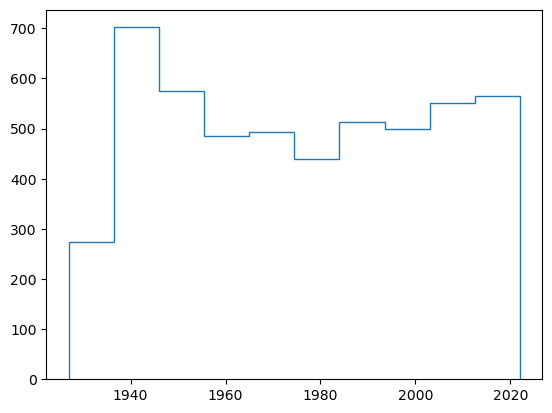

In [62]:
plt.hist(awards_condensed.year, histtype='step') 

### MOVIES3_STATS_CLEAN & AWARDS_CONDENSED MERGE

In [63]:
# Some award names match with column name of movies3_stats_clean, others with column alt_name
# Therefore: 1) get two intermediate merges, 2) Merge them to obtain final merge

movies_features_1 = pd.merge(movies3_stats_clean, awards_condensed, 
                               left_on=['name', 'year'], 
                               right_on=['name', 'year'], 
                               how='left')

movies_features_2 = pd.merge(movies3_stats_clean, awards_condensed, 
                               left_on=['alt_name', 'year'], 
                               right_on=['name', 'year'], 
                               how='left').drop(columns=['name_y']).rename(columns={'name_x': 'name'})

display(movies_features_1.sample(5))
display(movies_features_1.shape)
display(movies_features_1.info())

display(movies_features_2.sample(5))
display(movies_features_2.shape)
display(movies_features_2.info())

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner
9103,Sea Monsters A Prehistoric Adventure,2007,Sea Monsters A Prehistoric Adventure,7.0,1021.0,14079871,/m/03csxkm,40.0,[English Language],[USA],"[Short Film, Nature, World History, Animals, D...",23552772.0,NaN
3913,Feast of July,1995,Feast of July,6.2,569.0,6081230,/m/0fp4r1,116.0,[English Language],"[USA, United Kingdom]","[Crime Fiction, Costume drama, Mystery, Period...",293274.0,NaN
1526,The Firm,1993,The Firm,6.8,133602.0,287767,/m/01q7h2,154.0,[English Language],[USA],"[Thriller, Mystery, Drama, Suspense, Film adap...",279932533.5,"[False, False]"
2403,In Bruges,2008,In Bruges,7.9,417934.0,9541497,/m/02pjc1h,102.0,"[English Language, German Language]","[USA, Belgium, Ireland, United Kingdom]","[Crime Fiction, Thriller, Buddy film, Crime Dr...",30985890.0,[False]
5441,Requiem for a Heavyweight,1962,Requiem for a Heavyweight,7.8,4281.0,2104296,/m/06mdcv,86.0,[English Language],[USA],"[Sports, Drama, Boxing, Black-and-white]",944527.0,NaN


(9496, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9496 entries, 0 to 9495
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         9496 non-null   object 
 1   year         9496 non-null   Int64  
 2   alt_name     9496 non-null   object 
 3   rating       9496 non-null   float64
 4   votes        9496 non-null   float64
 5   id_wiki      9496 non-null   int64  
 6   id_freebase  9496 non-null   object 
 7   runtime      9395 non-null   float64
 8   lang         9496 non-null   object 
 9   countries    9496 non-null   object 
 10  genres       9496 non-null   object 
 11  revenue      9496 non-null   object 
 12  winner       1399 non-null   object 
dtypes: Int64(1), float64(3), int64(1), object(8)
memory usage: 973.8+ KB


None

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner
1081,Love's Enduring Promise,2004,Love's Enduring Promise,6.9,3439.0,10956794,/m/02qw5q2,88.0,[English Language],[USA],"[Christian film, Television movie, Period piec...",257043.0,NaN
4709,Middle Men,2009,Middle Men,6.8,37611.0,18153153,/m/057xrx9,105.0,[English Language],[USA],"[Crime Fiction, Gangster Film, Indie, Period p...",866187.55,NaN
6554,The Taking of Pelham 1 2 3,2009,The Taking of Pelham 1 2 3,6.4,197229.0,16166559,/m/03wbqc4,106.0,[English Language],"[USA, United Kingdom]","[Crime Fiction, Heist, Caper story, Remake, Ac...",147933263.0,NaN
479,We Were Strangers,1949,We Were Strangers,6.6,1214.0,14442254,/m/03d3p1q,105.0,[English Language],[USA],"[Adventure, Black-and-white, Action/Adventure,...",249682.0,NaN
2600,American Me,1992,American Me,7.1,9433.0,4362641,/m/0bz7sb,126.0,[English Language],[USA],"[Crime Fiction, Gangster Film, Crime Drama, Dr...",13086430.0,NaN


(9496, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9496 entries, 0 to 9495
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         9496 non-null   object 
 1   year         9496 non-null   Int64  
 2   alt_name     9496 non-null   object 
 3   rating       9496 non-null   float64
 4   votes        9496 non-null   float64
 5   id_wiki      9496 non-null   int64  
 6   id_freebase  9496 non-null   object 
 7   runtime      9395 non-null   float64
 8   lang         9496 non-null   object 
 9   countries    9496 non-null   object 
 10  genres       9496 non-null   object 
 11  revenue      9496 non-null   object 
 12  winner       1400 non-null   object 
dtypes: Int64(1), float64(3), int64(1), object(8)
memory usage: 973.8+ KB


None

In [64]:
# Final award merge
movies_features_inc = pd.merge(
    movies_features_1,
    movies_features_2,
    on=['id_wiki', 'id_freebase', 'name', 'alt_name', 'year', 'runtime', 'revenue', 'votes', 'rating'],  
    how='inner').drop(columns=['lang_y', 'countries_y', 'genres_y']).rename(columns={'lang_x': 'lang', 'countries_x': 'countries', 'genres_x': 'genres'})

display(movies_features_inc.sample(5))
display(movies_features_inc.shape)
display(movies_features_inc.info())

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner_x,winner_y
4839,Repo Chick,2009,Repo Chick,3.8,758.0,25947669,/m/0gg5vgs,85.0,[English Language],[USA],"[Cult, Comedy, Indie]",1010385.0,NaN,NaN
604,The Blackbird,1926,The Blackbird,6.7,792.0,17355803,/m/04yb_kh,77.0,"[Silent film, English Language]",[USA],"[Silent film, Drama, Black-and-white]",249648.0,NaN,NaN
3532,Girls! Girls! Girls!,1962,Girls! Girls! Girls!,5.5,3081.0,1754987,/m/05td37,98.0,[English Language],[USA],"[Romantic comedy, Romance Film, Musical, Comedy]",1368210.0,NaN,NaN
2483,Daughter from Danang,2002,Daughter from Danang,7.5,595.0,12191190,/m/02vv2rq,81.0,"[Vietnamese Language, English Language]",[USA],"[Culture & Society, Biography, War film, Inter...",376886.0,[False],[False]
7271,The Creature Walks Among Us,1956,The Creature Walks Among Us,5.6,3518.0,3815462,/m/0b1dkj,78.0,[English Language],[USA],"[Thriller, Science Fiction, Horror, Creature F...",110000.0,NaN,NaN


(9496, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9496 entries, 0 to 9495
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         9496 non-null   object 
 1   year         9496 non-null   Int64  
 2   alt_name     9496 non-null   object 
 3   rating       9496 non-null   float64
 4   votes        9496 non-null   float64
 5   id_wiki      9496 non-null   int64  
 6   id_freebase  9496 non-null   object 
 7   runtime      9395 non-null   float64
 8   lang         9496 non-null   object 
 9   countries    9496 non-null   object 
 10  genres       9496 non-null   object 
 11  revenue      9496 non-null   object 
 12  winner_x     1399 non-null   object 
 13  winner_y     1400 non-null   object 
dtypes: Int64(1), float64(3), int64(1), object(9)
memory usage: 1.0+ MB


None

In [65]:
# Fusing the winner columns
movies_features_inc = fuse_winner_columns(movies_features_inc, 'winner_x', 'winner_y')
display(movies_features_inc.sample(5))
display(movies_features_inc.shape)
display(movies_features_inc.info())

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner
8908,Beethoven's 2nd,1993,Beethoven's 2nd,4.9,26000.0,642694,/m/02zvq2,89.0,[English Language],[USA],"[Family Film, Animal Picture, Comedy, Family-O...",118243066.0,[False]
4572,There Goes the Neighborhood,1992,There Goes the Neighborhood,5.7,1168.0,14481268,/m/03d4wk6,95.0,[English Language],[USA],"[Crime Fiction, Black comedy, Comedy, Heist]",1045876.0,NaN
6714,Disorderlies,1987,Disorderlies,5.0,2100.0,9612861,/m/02plvgj,86.0,[English Language],[USA],"[Comedy, Indie, Slapstick]",10348437.0,NaN
3271,Artists and Models,1955,Artists and Models,6.5,4001.0,6742643,/m/0glq69,102.0,[English Language],[USA],[Comedy],6575000.0,NaN
454,RV,2006,RV,5.5,60097.0,4018828,/m/0bcs_f,99.0,[English Language],"[USA, United Kingdom, Germany]","[Road movie, Family Film, Comedy, Adventure]",97570686.5,NaN


(9496, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9496 entries, 0 to 9495
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         9496 non-null   object 
 1   year         9496 non-null   Int64  
 2   alt_name     9496 non-null   object 
 3   rating       9496 non-null   float64
 4   votes        9496 non-null   float64
 5   id_wiki      9496 non-null   int64  
 6   id_freebase  9496 non-null   object 
 7   runtime      9395 non-null   float64
 8   lang         9496 non-null   object 
 9   countries    9496 non-null   object 
 10  genres       9496 non-null   object 
 11  revenue      9496 non-null   object 
 12  winner       1402 non-null   object 
dtypes: Int64(1), float64(3), int64(1), object(8)
memory usage: 973.8+ KB


None

In [66]:
# Create column to check if a movie has won an Oscar
movies_features_inc['has_won'] = movies_features_inc['winner'].apply(lambda x: True if isinstance(x, list) and True in x else False)

# Create column to check if a movie has been nominated for an Oscar
movies_features_inc['nominated'] = movies_features_inc['winner'].apply(lambda x: True if isinstance(x, list) else False)

# Create column to store how many Oscars a movie has won
movies_features_inc['nbr_won'] = movies_features_inc['winner'].apply(lambda x: x.count(True) if isinstance(x, list) else 0)

# Create column to store how many Oscars a movie has been nominated for
movies_features_inc['nbr_nomination'] = movies_features_inc['winner'].apply(lambda x: len(x) if isinstance(x, list) else 0)

display(movies_features_inc.sample(5))
display(movies_features_inc.shape)
display(movies_features_inc.info())

display(movies_features_inc[movies_features_inc['has_won']==True])
display(movies_features_inc[movies_features_inc['nominated']==True])

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination
347,His Butler's Sister,1943,His Butler's Sister,7.0,506.0,32756149,/m/09sc1r1,87.0,[English Language],[USA],"[Musical, Comedy]",323881.0,NaN,False,False,0,0
56,The Comebacks,2007,The Comebacks,4.3,11645.0,7752732,/m/0kvgjd,84.0,[English Language],[USA],"[Parody, Sports, Comedy]",15790102.0,NaN,False,False,0,0
5407,On a Clear Day You Can See Forever,1970,On a Clear Day You Can See Forever,6.3,3950.0,17475674,/m/047pw6y,129.0,[English Language],[USA],"[Romantic comedy, Musical comedy, Musical, Fan...",14000000.0,NaN,False,False,0,0
8871,Roberta,1935,Roberta,7.0,3339.0,12800555,/m/02x5h46,106.0,[English Language],[USA],"[Musical, Black-and-white]",2335000.0,[False],False,True,0,1
4842,Super Speedway,1997,Super Speedway,7.1,475.0,6742894,/m/0glqhq,50.0,[English Language],"[USA, Canada]","[Sports, Auto racing]",40000000.0,NaN,False,False,0,0


(9496, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9496 entries, 0 to 9495
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            9496 non-null   object 
 1   year            9496 non-null   Int64  
 2   alt_name        9496 non-null   object 
 3   rating          9496 non-null   float64
 4   votes           9496 non-null   float64
 5   id_wiki         9496 non-null   int64  
 6   id_freebase     9496 non-null   object 
 7   runtime         9395 non-null   float64
 8   lang            9496 non-null   object 
 9   countries       9496 non-null   object 
 10  genres          9496 non-null   object 
 11  revenue         9496 non-null   object 
 12  winner          1402 non-null   object 
 13  has_won         9496 non-null   bool   
 14  nominated       9496 non-null   bool   
 15  nbr_won         9496 non-null   int64  
 16  nbr_nomination  9496 non-null   int64  
dtypes: Int64(1), bool(2), float64(3),

None

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination
1,Alexander's Ragtime Band,1938,Alexander's Ragtime Band,6.89,2135.0,10408933,/m/02qc0j7,106.0,[English Language],[USA],"[Musical, Comedy, Black-and-white]",3350335.0,"[False, False, True, False, False, False]",True,True,1,6
21,Midnight Express,1978,Midnight Express,7.50,79459.0,103021,/m/0p_sc,121.0,"[French Language, English Language]","[USA, United Kingdom]","[Thriller, LGBT, Indie, Crime Fiction, Escape ...",35000000.0,"[False, False, False, True, False, True]",True,True,2,6
25,Superman,1978,Superman,7.40,173964.0,362719,/m/01_mdl,151.0,[English Language],"[USA, United Kingdom]","[Science Fiction, Adventure, Superhero movie, ...",296890259.0,"[False, False, False, True]",True,True,1,4
29,Sweeney Todd The Demon Barber of Fleet Street,2007,Sweeney Todd The Demon Barber of Fleet Street,7.30,366420.0,5549065,/m/0ds11z,117.0,[English Language],"[USA, United Kingdom]","[Crime Fiction, Tragedy, Horror, Supernatural,...",145489732.0,"[False, True, False]",True,True,1,3
47,Shaft,1971,Shaft,6.60,18971.0,76345,/m/0k47y,98.0,"[English Language, American English]",[USA],"[Crime Fiction, Thriller, Detective, Action/Ad...",14405849.0,"[False, True]",True,True,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9402,The Lord of the Rings The Return of the King,2003,The Lord of the Rings The Return of the King,9.00,1795939.0,174251,/m/017jd9,250.0,"[Old English language, English Language]","[USA, New Zealand]","[Fantasy Adventure, Adventure, Epic, Action/Ad...",1065660760.5,"[True, True, True, True, True, True, True, Tru...",True,True,11,11
9431,Syriana,2005,Syriana,6.90,130444.0,2392280,/m/078sj4,126.0,"[Arabic Language, English Language, French Lan...",[USA],"[Thriller, Drama, Docudrama, Political thriller]",95918660.0,"[True, False]",True,True,1,2
9436,Phantom of the Opera,1943,Phantom of the Opera,6.40,7281.0,1271371,/m/04n_0x,93.0,[English Language],[USA],"[Drama, Musical, Horror, Romance Film]",3488000.0,"[True, True, False, False]",True,True,2,4
9465,The Battle of Midway,1942,The Battle of Midway,6.10,2083.0,7593569,/m/02665zq,50.0,[English Language],[USA],"[History, Black-and-white, Short Film, Propaga...",65719.0,[True],True,True,1,1


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination
1,Alexander's Ragtime Band,1938,Alexander's Ragtime Band,6.89,2135.0,10408933,/m/02qc0j7,106.0,[English Language],[USA],"[Musical, Comedy, Black-and-white]",3350335.0,"[False, False, True, False, False, False]",True,True,1,6
15,Straw Dogs,1971,Straw Dogs,7.40,59968.0,196176,/m/01bwgr,118.0,[English Language],"[USA, United Kingdom]","[Thriller, Drama]",28079553.0,[False],False,True,0,1
21,Midnight Express,1978,Midnight Express,7.50,79459.0,103021,/m/0p_sc,121.0,"[French Language, English Language]","[USA, United Kingdom]","[Thriller, LGBT, Indie, Crime Fiction, Escape ...",35000000.0,"[False, False, False, True, False, True]",True,True,2,6
25,Superman,1978,Superman,7.40,173964.0,362719,/m/01_mdl,151.0,[English Language],"[USA, United Kingdom]","[Science Fiction, Adventure, Superhero movie, ...",296890259.0,"[False, False, False, True]",True,True,1,4
29,Sweeney Todd The Demon Barber of Fleet Street,2007,Sweeney Todd The Demon Barber of Fleet Street,7.30,366420.0,5549065,/m/0ds11z,117.0,[English Language],"[USA, United Kingdom]","[Crime Fiction, Tragedy, Horror, Supernatural,...",145489732.0,"[False, True, False]",True,True,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9482,April Love,1957,April Love,6.20,713.0,26254041,/m/0b76vn7,99.0,[English Language],[USA],"[Animal Picture, Musical, Drama, Film adaptati...",5245675.0,[False],False,True,0,1
9485,The Great White Hope,1970,The Great White Hope,6.90,2560.0,18046658,/m/04gghr1,103.0,"[Spanish Language, German Language, English La...",[USA],"[Sports, Romance Film, Biography, Drama, Boxing]",2695525.0,"[False, False]",False,True,0,2
9490,Twister,1996,Twister,6.40,194938.0,303933,/m/01s7w3,113.0,[English Language],[USA],"[Action/Adventure, Disaster]",495970562.0,"[False, False]",False,True,0,2
9492,Coming to America,1988,Coming to America,7.10,196000.0,54540,/m/0f7hw,117.0,[English Language],[USA],"[Romantic comedy, Comedy of manners, Drama, Co...",288752301.0,"[False, False]",False,True,0,2


### a) Box-office revenue

#### US dollar inflation
In the dataset, the revenues of the movies are included, in US dollars. Due to inflation, one dollar in 1914 (the earliest date of release for a movie in the dataset) compared to one dollar in 2012 (the most recent movie in the dataset) is not worth the same. The purchasing power of the money has changed and this effect has to be accounted for, if two movies from different moments in time should be compared to each other. The effect of inflation can be accounted for with an additional [dataset](https://www.officialdata.org/us/inflation/1800?amount=1#buying-power), relating the worth of US dollar in each year to the worth of US dollar in 1800:

In [68]:
DATA_PATH = '../data'
INFLATION_PATH = '/inflation/inflation_data.csv'
inflation_raw= pd.read_csv(DATA_PATH+INFLATION_PATH)
display(inflation_raw.sample(5))
display(inflation_raw.shape)
display(inflation_raw.info())

,year,amount,inflation rate
99,1899,0.66,0.00
10,1810,0.98,0.00
190,1990,10.37,0.05
205,2005,15.50,0.03
29,1829,0.74,-0.02


(224, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            224 non-null    int64  
 1   amount          224 non-null    float64
 2   inflation rate  224 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 5.4 KB


None

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination,revenue_infl
9311,Choose Me,1984,Choose Me,6.8,2600.0,5996352,/m/0fjrmz,106.0,[English Language],[USA],"[Romantic comedy, Ensemble Film, Indie, Comedy...",2490233.0,NaN,False,False,0,0,301846.424242
8462,KickAss,2010,KickAss,7.6,560157.0,21282769,/m/05f4_n0,117.0,[English Language],"[USA, United Kingdom]","[Superhero movie, Superhero, Action/Adventure,...",96835106.5,NaN,False,False,0,0,5594171.374928
2265,Introducing Dorothy Dandridge,1999,Introducing Dorothy Dandridge,7.0,3669.0,2302549,/m/0727__,115.0,[English Language],[USA],"[Tragedy, Biography, Addiction Drama, Period p...",17860280.0,NaN,False,False,0,0,1351004.538578
5671,The Last Seduction,1994,The Last Seduction,7.0,23371.0,664496,/m/030zf9,110.0,[English Language],[USA],"[Thriller, Crime Fiction, Indie, Erotic thrill...",6138485.0,NaN,False,False,0,0,521980.017007
8722,Roughshod,1949,Roughshod,6.6,647.0,25363180,/m/09ghdq2,88.0,[English Language],[USA],"[Western, Drama, Black-and-white]",126911.0,NaN,False,False,0,0,67148.677249


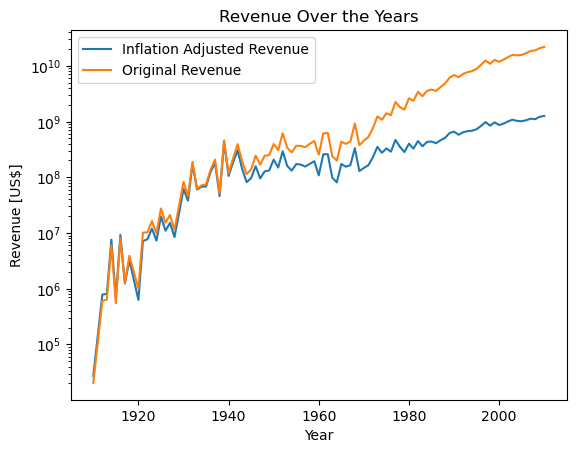

In [70]:
df_inflation = revenue_inflation_correction(movies_features_inc, inflation_raw)

# 'movies2_clean' ot whatever dataset is the right one...

In [71]:
df_inflation[df_inflation['year'] == 1915]

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination,revenue_infl
293,Kindling,1915,Kindling,6.6,31.0,14626970,/m/03gr3s9,NaN,"[Silent film, English Language]",[USA],"[Crime Fiction, Silent film, Drama, Indie, Bla...",66036.0,NaN,False,False,0,0,82545.0
1308,The Captive,1915,The Captive,6.5,128.0,14616918,/m/03gqqyf,50.0,"[Silent film, English Language]",[USA],"[Silent film, Romance Film, Drama, Indie, Blac...",56075.0,NaN,False,False,0,0,70093.75
1865,The Warrens of Virginia,1915,The Warrens of Virginia,5.9,23.0,14616220,/m/03gqq2m,NaN,"[Silent film, English Language]",[USA],"[Silent film, Drama, Indie, Black-and-white]",85770.0,NaN,False,False,0,0,107212.5
2505,The Arab,1915,The Arab,5.1,49.0,14617357,/m/03gqrgm,50.0,"[Silent film, English Language]",[USA],"[Silent film, Adventure, Black-and-white, Indie]",68527.0,NaN,False,False,0,0,85658.75
5502,Chimmie Fadden Out West,1915,Chimmie Fadden Out West,4.9,23.0,14627259,/m/03gr45c,50.0,"[Silent film, English Language]",[USA],"[Silent film, Western, Indie, Black-and-white,...",72036.0,NaN,False,False,0,0,90045.0
6135,Alice in Wonderland,1915,Alice in Wonderland,6.2,516.0,23669602,/m/06zr25h,52.0,[English Language],[USA],"[Silent film, Black-and-white]",97477.0,NaN,False,False,0,0,121846.25
9055,The Girl of the Golden West,1915,The Girl of the Golden West,5.4,55.0,14614654,/m/03gqn62,50.0,"[Silent film, English Language]",[USA],"[Silent film, Western, Black-and-white, Indie]",102224.0,NaN,False,False,0,0,127780.0


The very high total revenue in the year 1915 catches the eye, but the data for it is valid. In 1915 the movie "The Birth of a Nation" was released, which is a movie that was extremely succesful and had a box office revenue of about [50-100 Mio US$ (Wikipedia)](https://en.wikipedia.org/wiki/The_Birth_of_a_Nation). 

### Normalization for counterbalancing natural growth of movie industry

The steady increase in total revenue over time can be explained partly by the ever increasing number of movies released per year. One should however also consider the steady growth of the movie industry, which allows a movie to make much more revenue today (with an international distribution of the movies) as opposed to earlier in time. This effect should be taken into consideration, which is why we perform a regression analysis and normalize the data accordingly:

In [72]:
df_inflation['revenue_part'] = df_inflation.groupby('year')['revenue'].transform(lambda x: x / x.sum())
display(df_inflation.sample(5))
display(df_inflation.shape)
display(df_inflation.info())


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination,revenue_infl,revenue_part
4512,D.A.R.Y.L.,1985,D.A.R.Y.L.,6.2,13149.0,739821,/m/0379gn,100.0,[English Language],"[USA, United Kingdom]","[Science Fiction, Family Film, Adventure]",7840873.0,NaN,False,False,0,0,918135.01171,0.002093
2040,Embrace of the Vampire,1995,Embrace of the Vampire,4.3,6440.0,1667811,/m/05l_gp,93.0,[English Language],[USA],"[Cult, Erotic thriller, Horror, Erotica, Indie]",55389516.0,NaN,False,False,0,0,4577645.950413,0.006301
8054,The Aryan Couple,2004,The Aryan Couple,6.3,1193.0,22516313,/m/05ztgyf,NaN,[English Language],"[USA, United Kingdom]","[Period piece, Drama, Political drama]",1212487.0,NaN,False,False,0,0,80886.390927,0.000079
6869,The Final Destination,2009,The Final Destination,5.1,105651.0,15886402,/m/03qdlh6,NaN,[English Language],[USA],"[Thriller, Teen, Horror, Slasher, Auto racing]",178443719.5,NaN,False,False,0,0,10478198.443922,0.008613
500,Dark of the Sun,1968,Dark of the Sun,6.8,3140.0,15047111,/m/03h5vg8,100.0,[English Language],"[USA, United Kingdom]","[Adventure, War film]",8066000.0,NaN,False,False,0,0,2922463.768116,0.008783


(9496, 19)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9496 entries, 0 to 9495
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            9496 non-null   object 
 1   year            9496 non-null   Int64  
 2   alt_name        9496 non-null   object 
 3   rating          9496 non-null   float64
 4   votes           9496 non-null   float64
 5   id_wiki         9496 non-null   int64  
 6   id_freebase     9496 non-null   object 
 7   runtime         9395 non-null   float64
 8   lang            9496 non-null   object 
 9   countries       9496 non-null   object 
 10  genres          9496 non-null   object 
 11  revenue         9496 non-null   object 
 12  winner          1402 non-null   object 
 13  has_won         9496 non-null   bool   
 14  nominated       9496 non-null   bool   
 15  nbr_won         9496 non-null   int64  
 16  nbr_nomination  9496 non-null   int64  
 17  revenue_infl    9496 non-null   o

None

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.497
Model:                            OLS   Adj. R-squared (uncentered):              0.492
Method:                 Least Squares   F-statistic:                              96.91
Date:                Sun, 17 Dec 2023   Prob (F-statistic):                    2.63e-16
Time:                        23:22:59   Log-Likelihood:                         -2084.8
No. Observations:                  99   AIC:                                      4172.
Df Residuals:                      98   BIC:                                      4174.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination,revenue_infl,revenue_part,revenue_norm
8150,War,2007,War,6.2,91054.0,5795788,/m/0f52ld,103.0,"[Japanese Language, Standard Mandarin, English...",[USA],"[Thriller, Gangster Film, Action/Adventure, Ma...",41491301.5,NaN,False,False,0,0,2520735.206561,0.002241,2483431.543951
2936,Dracula 2000,2000,Dracula 2000,4.9,33982.0,1219214,/m/04jdgq,99.0,[English Language],[USA],"[Thriller, Romance Film, Action, Horror, Super...",45833792.5,NaN,False,False,0,0,3352874.359912,0.003878,3292961.764804
9003,You Don't Know Jack,2010,You Don't Know Jack,7.6,28671.0,26477451,/m/0bbvw51,134.0,[English Language],[USA],"[Courtroom Drama, Biography, Drama, Biopic [fe...",220914.0,NaN,False,False,0,0,12762.218371,0.00001,12588.339246
534,Gulliver's Travels,2010,Gulliver's Travels,4.9,70045.0,23594997,/m/06znpjr,95.0,[English Language],[USA],"[Family Film, Fantasy Adventure, Fantasy, Come...",213348662.0,NaN,False,False,0,0,12325168.226459,0.009784,12157243.700699
9403,Houdini,1953,Houdini,6.8,3422.0,8121583,/m/026scsd,106.0,[English Language],[USA],"[Biographical film, Biography, Drama, Period p...",1800000.0,NaN,False,False,0,0,849056.603774,0.005306,809896.939237


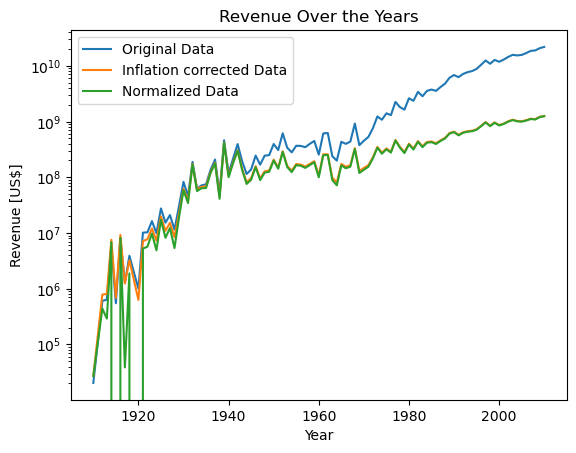

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,has_won,nominated,nbr_won,nbr_nomination,revenue_part,revenue_norm
7099,StopLoss,2008,StopLoss,6.4,20357.0,9477743,/m/028bfsc,111.0,[English Language],[USA],"[Drama, War film]",False,False,0,0,0.000688,747756.227215
6934,Millennium,1989,Millennium,5.7,6422.0,972940,/m/03vnvn,108.0,[English Language],"[USA, Canada]","[Time travel, Thriller, Science Fiction, Drama...",False,False,0,0,0.000946,574282.361604
4101,Sons of Provo,2004,Sons of Provo,5.8,397.0,3090209,/m/08qrgp,93.0,[English Language],[USA],"[Parody, Mockumentary, Comedy, Religious Film,...",False,False,0,0,0.000008,7911.127229
7364,Titanic,1996,Titanic,5.8,4372.0,1742101,/m/05sgqr,173.0,[English Language],"[USA, Canada]","[Disaster, Costume drama, Action, Drama]",False,False,0,0,0.000129,105998.024492
3744,The Hard Ride,1971,The Hard Ride,5.2,311.0,13548385,/m/03c9157,90.0,[English Language],[USA],"[Crime Fiction, Action/Adventure, Action, Drama]",False,False,0,0,0.001067,164434.21617


(9496, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9496 entries, 0 to 9495
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            9496 non-null   object 
 1   year            9496 non-null   Int64  
 2   alt_name        9496 non-null   object 
 3   rating          9496 non-null   float64
 4   votes           9496 non-null   float64
 5   id_wiki         9496 non-null   int64  
 6   id_freebase     9496 non-null   object 
 7   runtime         9395 non-null   float64
 8   lang            9496 non-null   object 
 9   countries       9496 non-null   object 
 10  genres          9496 non-null   object 
 11  has_won         9496 non-null   bool   
 12  nominated       9496 non-null   bool   
 13  nbr_won         9496 non-null   int64  
 14  nbr_nomination  9496 non-null   int64  
 15  revenue_part    9496 non-null   object 
 16  revenue_norm    9496 non-null   object 
dtypes: Int64(1), bool(2), float64(3),

None

In [73]:
movies_features = df_inflation.copy(deep=True)
movies_features = revenue_normalisation(df_inflation).drop(columns=['winner', 'revenue_infl', 'revenue'])

display(movies_features.sample(5))
display(movies_features.shape)
display(movies_features.info())


In [74]:
display(movies_features[movies_features['name']=='Star Wars Episode IV A New Hope'])
display(movies_features[movies_features['name']=='The Godfather'])
display(movies_features[movies_features['name']=='The Matrix'])
display(movies_features[movies_features['name']=='Scream'])
display(movies_features[movies_features['name']=='Rambo'])
display(movies_features[movies_features['name']=='Rocky'])
display(movies_features[movies_features['name']=='Forrest Gump'])
display(movies_features[movies_features['name'].str.contains('The Lord of the Ring')])

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,has_won,nominated,nbr_won,nbr_nomination,revenue_part,revenue_norm
9387,Star Wars Episode IV A New Hope,1977,Star Wars,8.6,1339144.0,52549,/m/0dtfn,122.0,[English Language],[USA],"[Science Fiction, Adventure, Fantasy, Coming o...",True,True,6,10,0.337494,153857547.453283


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,has_won,nominated,nbr_won,nbr_nomination,revenue_part,revenue_norm
4294,The Godfather,1972,The Godfather,9.2,1804773.0,2466773,/m/07g1sm,177.0,"[Latin Language, Italian Language, Sicilian La...",[USA],"[Crime Fiction, Gangster Film, Crime Drama, Fa...",True,True,3,11,0.346482,75424417.962097


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,has_won,nominated,nbr_won,nbr_nomination,revenue_part,revenue_norm
6718,The Matrix,1999,The Matrix,8.7,1877771.0,30007,/m/07cz2,135.0,[English Language],"[USA, Australia]","[Thriller, Science Fiction, Adventure, Doomsda...",True,True,4,4,0.035012,33224833.843101


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,has_won,nominated,nbr_won,nbr_nomination,revenue_part,revenue_norm
7188,Scream,1996,Scream,7.4,335040.0,113549,/m/0sy44,103.0,[English Language],[USA],"[Crime Fiction, Mystery, Horror]",False,False,0,0,0.017242,14187730.463848


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,has_won,nominated,nbr_won,nbr_nomination,revenue_part,revenue_norm
9024,Rambo,2008,Rambo,7.0,230814.0,18850952,/m/03clwtw,92.0,"[Burmese Language, English Language, Thai Lang...","[USA, Germany]","[Thriller, Action Thrillers, Action, War film]",False,False,0,0,0.005798,6299708.167102


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,has_won,nominated,nbr_won,nbr_nomination,revenue_part,revenue_norm
9283,Rocky,1976,Rocky,8.1,563359.0,45772,/m/0cf08,120.0,[English Language],[USA],"[Boxing, Sports, Drama, Romance Film, Action, ...",True,True,3,10,0.14734,40746767.058961


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,has_won,nominated,nbr_won,nbr_nomination,revenue_part,revenue_norm
7515,Forrest Gump,1994,Forrest Gump,8.8,1900000.0,41528,/m/0bdjd,136.0,[English Language],[USA],"[Coming of age, Comedy film, Drama, War film, ...",True,True,6,13,0.084227,56386646.746294


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,has_won,nominated,nbr_won,nbr_nomination,revenue_part,revenue_norm
989,The Lord of the Rings The Two Towers,2002,The Lord of the Rings The Two Towers,8.8,1622144.0,173944,/m/017gm7,179.0,"[Old English language, English Language]","[USA, New Zealand]","[Fantasy Adventure, Adventure, Epic, Action/Ad...",True,True,2,6,0.06191,61467876.14508
8551,The Lord of the Rings,1978,The Lord of the Rings,6.2,33307.0,396607,/m/023cjg,135.0,[English Language],[USA],"[Fantasy Adventure, Sword and sorcery films, A...",False,False,0,0,0.014257,4832129.22638
9292,The Lord of the Rings The Fellowship of the Ring,2001,The Lord of the Rings The Fellowship of the Ring,8.8,1817662.0,173941,/m/017gl1,178.0,[English Language],"[USA, New Zealand]","[Fantasy Adventure, Adventure, Epic, Fantasy, ...",True,True,4,13,0.06487,58501942.646399
9402,The Lord of the Rings The Return of the King,2003,The Lord of the Rings The Return of the King,9.0,1795939.0,174251,/m/017jd9,250.0,"[Old English language, English Language]","[USA, New Zealand]","[Fantasy Adventure, Adventure, Epic, Action/Ad...",True,True,11,11,0.067723,71909451.897554


### b) Reviews

### c) Awards

### d) Plot similarity

In [75]:
movies.reset_index()

,index,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
0,0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[USA],"[Thriller, Science Fiction, Horror, Adventure,..."
1,1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[USA],"[Mystery, Biographical film, Drama, Crime Drama]"
2,5,13696889,/m/03cfc81,The Gangsters,1913,NaN,35.0,"[Silent film, English Language]",[USA],"[Short Film, Silent film, Indie, Black-and-whi..."
3,7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,[English Language],[USA],"[Musical, Comedy, Black-and-white]"
4,10,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,[English Language],[USA],"[Drama, Black-and-white]"
...,...,...,...,...,...,...,...,...,...,...
28816,74810,7761830,/m/0kvgqb,Spaced Invaders,1990,15369573.0,100.0,[English Language],[USA],"[Alien Film, Science Fiction, Family Film, Com..."
28817,74811,34474142,/m/0cpy07r,Frontier Fury,1943,NaN,55.0,[English Language],[USA],[Western]
28818,74815,1918494,/m/0660qx,State and Main,2000,6944471.0,106.0,"[Italian Language, English Language]","[France, USA]","[Parody, Americana, Comedy]"
28819,74817,24209227,/m/07k5mlk,"The Time, the Place and the Girl",1946,NaN,105.0,[English Language],[USA],"[Comedy film, Romance Film, Musical]"


In [76]:
MOVIES_PLOT = MOVIES_FOLDER + "plot_summaries.txt"
df_plot = pd.read_csv(MOVIES_PLOT, sep='\t', names=['id_wiki', 'plot'])

merged_df = df_plot.merge(movies, on='id_wiki')
merged_df.columns
corresp_table=merged_df.drop(columns=[ 'plot', 'id_freebase', 'name', 'year', 'revenue', 'runtime',
       'lang', 'countries', 'genres'])
corresp_table.head()


,id_wiki
0,2231378
1,595909
2,5272176
3,1952976
4,24225279


c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 't

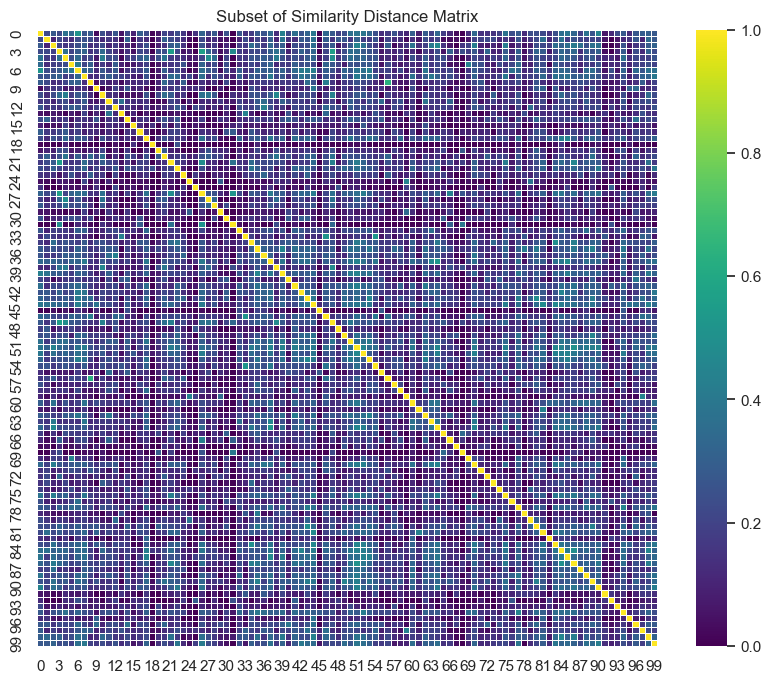

In [77]:
similarity_matrix = plot_similarity_heatmap(merged_df, 'plot')

In [78]:

# Example to find most similar movie
given_movie_index = 1665  # Replace with the index of the movie you're interested in
max_indices = np.argpartition(similarity_matrix[given_movie_index], -10)[-10:]
given_movie_name = merged_df.iloc[given_movie_index]['name']
most_similar_movie_names = merged_df.iloc[max_indices[9]]['name']

print("Given Movie Name:", given_movie_name)
print("Most Similar Movie Names:", most_similar_movie_names)
print(max_indices)

Given Movie Name: Blood of Dracula's Castle
Most Similar Movie Names: Kid Auto Races at Venice
[10055 14360   268 14623  3737 10079 14981  1665 10742  7923]


In [79]:
NAME_OF_THE_MOVIE= 'Star wars'
display( movies_features[movies_features['name'].str.contains(NAME_OF_THE_MOVIE, case=False, na=False)])


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,has_won,nominated,nbr_won,nbr_nomination,revenue_part,revenue_norm
544,Star Wars The Clone Wars,2008,Star Wars The Clone Wars,5.9,65696.0,15726696,/m/0cpllql,90.0,[English Language],[USA],"[Thriller, Science Fiction, Adventure, Compute...",False,False,0,0,0.003664,3981186.524569
688,Star Wars Episode II Attack of the Clones,2002,Star Wars Episode II Attack of the Clones,6.6,699970.0,50957,/m/0dfw0,142.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant...",False,True,0,1,0.045064,44741897.624018
1849,Star Wars Episode VI Return of the Jedi,1983,Star Wars Episode VI Return of the Jedi,8.3,1029353.0,50744,/m/0ddjy,135.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant...",False,False,0,0,0.157184,54541848.003469
5791,Star Wars Episode I The Phantom Menace,1999,Star Wars Episode I The Phantom Menace,6.5,793302.0,50793,/m/0ddt_,136.0,[English Language],[USA],"[Science Fiction, Action, Fantasy, Adventure, ...",False,True,0,3,0.077363,73413587.642758
6464,Star Wars Episode V The Empire Strikes Back,1980,Star Wars Episode V The Empire Strikes Back,8.7,1260121.0,53964,/m/0f3m1,124.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant...",False,False,0,0,0.178028,69033992.432369
6491,The Star Wars Holiday Special,1978,The Star Wars Holiday Special,2.1,15255.0,185264,/m/0199wf,97.0,[English Language],[USA],"[Science Fiction, Adventure, Holiday Film, Ani...",False,False,0,0,0.04091,13865149.813119
7172,Star Wars Episode III Revenge of the Sith,2005,Star Wars Episode III Revenge of the Sith,7.6,777101.0,55447,/m/0fdv3,140.0,[English Language],[USA],"[Science Fiction, Action, Fantasy, Tragedy, Ad...",False,True,0,1,0.053603,53322205.431633
7849,Star Wars Revelations,2005,Star Wars Revelations,5.0,1180.0,1823554,/m/05zsyv,47.0,[English Language],[USA],"[Fan film, Indie]",False,False,0,0,0.00008,79344.592052
9387,Star Wars Episode IV A New Hope,1977,Star Wars,8.6,1339144.0,52549,/m/0dtfn,122.0,[English Language],[USA],"[Science Fiction, Adventure, Fantasy, Coming o...",True,True,6,10,0.337494,153857547.453283


In [80]:
scifi_before_star_wars = merged_df[(merged_df['genres'].apply(lambda genre : 'Science Fiction' in genre)) & (merged_df['year'] < 1977)].index
scifi_after_star_wars = merged_df[(merged_df['genres'].apply(lambda genre : 'Science Fiction' in genre)) & (merged_df['year'] > 1977)].index
comedy_df=merged_df[merged_df['genres'].apply(lambda genre : 'Science Fiction' in genre)].index

star_wars_movies = merged_df[merged_df['name'].str.contains('Star Wars', case=False, na=False)]

a=calculate_mean_similarity_1(similarity_matrix, 3769	, scifi_before_star_wars)
b=calculate_mean_similarity_1(similarity_matrix, 3769, scifi_after_star_wars)
print('Similarity means before Star Wars:{}'.format(a))
print('Similarity means after Star Wars:{}'.format(b))


Similarity means before Star Wars:0.17622116642391022
Similarity means after Star Wars:0.21030837821739862


In [81]:
import numpy as np
import pandas as pd

def find_most_influential_movie(similarity_matrix, genre, df):
    """
    Find the movie within a specific genre that has the most similarities with other movies in that genre.

    Parameters:
    - similarity_matrix (numpy.ndarray): Matrix containing pairwise similarities between movie plots.
    - genre (str): The genre for which to find the most influential movie.
    - df (pandas.DataFrame): DataFrame containing movie information, including genres.

    Returns:
    - str: The name of the most influential movie in the specified genre.
    """
    # Filter movies of the specified genre
    genre_movies = df[df['genres'].apply(lambda genres: genre in genres)]

    # Get the indices of movies of the specified genre
    genre_indices = genre_movies.index.tolist()

    # Initialize variables to store the most influential movie
    max_avg_similarity = 0.0
    most_influential_movie = None

    # Iterate through movies and compute average similarity to other movies in the genre
    for i in range(len(genre_indices)):
        avg_similarity_to_genre = np.mean(similarity_matrix[genre_indices[i], genre_indices])
        
        # Update most influential movie
        if avg_similarity_to_genre > max_avg_similarity:
            max_avg_similarity = avg_similarity_to_genre
            most_influential_movie = df.loc[genre_indices[i], 'name']

    return most_influential_movie

# Example usage:
# Assuming similarity_matrix is your pre-computed similarity matrix, and df is your DataFrame
# Replace 'Science Fiction' with the genre you are interested in
most_influential_movie = find_most_influential_movie(similarity_matrix, 'Crime Fiction', merged_df)

print(f"The most influential movie in Science Fiction is: {most_influential_movie}")


The most influential movie in Science Fiction is: I, the Jury


In [82]:
# Example usage:
# Assuming 'merged_df' is your DataFrame, 'similarity_matrix' is your pre-computed similarity matrix
movie_index = 4906  # Replace with the actual index of the film in the DataFrame
film_row = merged_df.iloc[movie_index]
genre=film_row['genres'][0]
mean_similarity_before, mean_similarity_after = calculate_mean_similarity_2(movie_index, merged_df, similarity_matrix, genre)

print(f"Mean Similarity 10 Years Before: {mean_similarity_before:.2f}")
print(f"Mean Similarity 10 Years After: {mean_similarity_after:.2f}")


Mean Similarity 10 Years Before: 0.18
Mean Similarity 10 Years After: 0.19


## 3) Method for identifying pivotal movies

### 3.1) TEST

In [83]:
# Help to find the name of a wiki index
id_wiki=62440
print(merged_df[merged_df['id_wiki']==id_wiki]['name'])

5289    The Sting
Name: name, dtype: object


In [84]:
# Help to show candidates movie for a given trend
trend_id=3 # variable to change
pa=pd.DataFrame()
pc=pd.DataFrame()
pb=pd.DataFrame()
#Star Wars =320
#Lord of the ring = 176
print('genre {}, years {}'.format(candidates[trend_id][0], candidates[trend_id][1]))
from helpers import *
pa=candidates[trend_id][2].copy()
columns_to_drop = ['id_freebase', 'name', 'year', 'revenue', 'runtime', 'lang',
       'countries', 'genres']
columns_to_drop_2= ['id_freebase',
       'runtime', 'lang', 'countries', 'has_won', 'nominated',
        'revenue_part']
pa=pa.drop(columns=columns_to_drop).copy()
pb=pa.merge(movies_features, on='id_wiki')
pb['trend_number'] = trend_id*np.ones((len(pb), 1))


pb= calculate_mean_similarity(pb, merged_df, similarity_matrix, candidates[trend_id][0])
pb.drop(columns=columns_to_drop_2, inplace=True)
display(pb)

genre Action Thrillers, years 1975


,id_wiki,name,year,alt_name,rating,votes,genres,nbr_won,nbr_nomination,revenue_norm,trend_number,delta_similarity
0,314406,Bring Me the Head of Alfredo Garcia,1974,Bring Me the Head of Alfredo Garcia,7.4,19851.0,"[Thriller, Action/Adventure, Adventure, Road m...",0,0,142071.860199,3.0,1.601040
1,4210681,Hell Up in Harlem,1973,Hell Up in Harlem,5.9,1538.0,"[Thriller, Crime Fiction, Gangster Film, Indie...",0,0,399998.658859,3.0,NaN
2,4040311,Truck Turner,1974,Truck Turner,6.9,3081.0,"[Thriller, Crime Fiction, Action Thrillers, Ac...",0,0,43552.962667,3.0,1.163959
3,19269176,The Outside Man,1972,The Outside Man,6.5,948.0,"[Crime Fiction, Thriller, Action Thrillers, Ga...",0,0,1249016.260246,3.0,-6.988216
4,1237909,Sweet Sweetback's Baadasssss Song,1971,Sweet Sweetback's Baadasssss Song,5.5,5315.0,"[Crime Fiction, Thriller, Indie, Action/Advent...",0,0,5211140.1661,3.0,-0.123937
5,14418816,Madame Sin,1972,Madame Sin,5.8,1053.0,"[Thriller, Action Thrillers, Action, Drama, Spy]",0,0,16070.712677,3.0,-3.427988
6,433285,Bullitt,1968,Bullitt,7.4,68371.0,"[Crime Fiction, Thriller, Chase Movie, Action ...",1,2,14867875.705547,3.0,-0.033880
7,7010510,The Super Cops,1974,The Super Cops,6.6,1042.0,"[Crime Fiction, Thriller, Docudrama, Action Th...",0,0,299788.430178,3.0,0.080218
8,301798,Dirty Harry,1971,Dirty Harry,7.7,155411.0,"[Thriller, Action Thrillers, Action/Adventure,...",0,0,12331122.269486,3.0,-1.022978
9,1126356,Mr. Majestyk,1974,Mr. Majestyk,6.7,8736.0,"[Thriller, Action Thrillers, Gangster Film, Ac...",0,0,31871.854375,3.0,3.602022


### 3.2) Serious Buisness Machine learning

In [85]:
# CREATION OF DF_CANDIDATES

columns_to_drop = ['id_freebase', 'name', 'year', 'revenue', 'runtime', 'lang',
       'countries', 'genres']
columns_to_drop_2= ['id_freebase', 'runtime', 'lang',
    'countries',]
from helpers import *
result_df = pd.DataFrame()
pc=pd.DataFrame()
pb=pd.DataFrame()
for trend_id in range(len(candidates)):
    if len(candidates[trend_id][2])>3 : # get candidates subset with at least 3 candidates
        pc = candidates[trend_id][2].copy()

        pc.drop(columns=columns_to_drop, inplace=True)
        pb = pc.merge(movies_features, on='id_wiki')
        pb['trend_number'] = trend_id * np.ones((len(pb), 1))
        pb = calculate_mean_similarity(pb, merged_df, similarity_matrix, candidates[trend_id][0])
        pb.drop(columns=columns_to_drop_2, inplace=True)

        # Concatenate the current DataFrame with the result_df
        result_df = pd.concat([result_df, pb], ignore_index=True)
    else :
        continue

# Display the merged DataFrame
result_df.info

c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar 

<bound method DataFrame.info of        id_wiki                      name  year                  alt_name  \
0      5286922                 The Phynx  1970                 The Phynx   
1       298925    Take the Money and Run  1969    Take the Money and Run   
2      3059075              Brain Donors  1992              Brain Donors   
3      1716921  Amazon Women on the Moon  1987  Amazon Women on the Moon   
4        75222                Spaceballs  1987                Spaceballs   
...        ...                       ...   ...                       ...   
7954   3759313           Day of the Dead  2008           Day of the Dead   
7955  16794053                Quarantine  2008                Quarantine   
7956   2271177  Resident Evil Extinction  2007  Resident Evil Extinction   
7957   8586622             Planet Terror  2007             Planet Terror   
7958    915499          Land of the Dead  2005          Land of the Dead   

      rating     votes                                 

In [112]:
# FILTERING 

# Now we have the big candidates DataFrame we will Filter the non-interesting trends i.e. trends with less than 10 candidates
r=result_df.copy()
# Filter candidates that have no delta_similarity
r.dropna(subset=['delta_similarity'], inplace=True)
unique_names_count = len(r['name'].unique()) # number of different movies
print ('There is {} different movies'.format(unique_names_count))
movie_counts_per_trend = r['trend_number'].value_counts()
# Filter trends with less than 10 movies
trends_with_few_movie = movie_counts_per_trend[movie_counts_per_trend < 10].index

# Remove rows where 'trend_number' is in trends_with_one_movie
result_df_filtered = r[~r['trend_number'].isin(trends_with_few_movie)]




There is 3634 different movies


In [113]:
# STANDARDIZATION

# Standardization of the features: we standardize the feature for EACH TRENDS
re = result_df_filtered.copy()
result_df_standardized = result_df_filtered.copy()
# Define the features to standardize
features_to_standardize = ['rating','nbr_won','nbr_nomination','revenue_norm','delta_similarity']

# Group by 'trend_number' and standardize the features within each group
scaler = StandardScaler()

def standardize_group(group):
    group[features_to_standardize] = scaler.fit_transform(group[features_to_standardize])
    return group

result_df_standardized = re.groupby('trend_number').apply(standardize_group)
result_df_ungrouped = result_df_standardized.drop('trend_number', axis=1).reset_index().copy()
# Display the result
display(result_df_standardized)
unique_names_count = len(result_df_filtered['name'].unique())


id_wiki                          name  year  \
trend_number                                                      
2.0          11       76345                         Shaft  1971   
             12     9068424  The Legend of Nigger Charley  1972   
             13     3730244     The Ballad of Cable Hogue  1970   
             14    12807520              The Stone Killer  1973   
             16        4727                        Batman  1966   
...                     ...                           ...   ...   
386.0        7954   3759313               Day of the Dead  2008   
             7955  16794053                    Quarantine  2008   
             7956   2271177      Resident Evil Extinction  2007   
             7957   8586622                 Planet Terror  2007   
             7958    915499              Land of the Dead  2005   

                                       alt_name    rating     votes  \
trend_number                                                          
2.0          11                           Shaft  0.109709   18971.0   
             12    The Legend of Nigger Charley -0.641797     457.0   
             13       The Ballad of Cable Hogue  0.861215    9626.0   
             14                The Stone Killer -0.516546    3227.0   
             16                          Batman -0.015542   32993.0   
...                                         ...       ...       ...   
386.0        7954               Day of the Dead -0.631372   21030.0   
             7955                    Quarantine  0.286694   73694.0   
             7956      Resident Evil Extinction  0.470308  195449.0   
             7957                 Planet Terror  1.021147  209447.0   
             7958              Land of the Dead  0.470308   96728.0   

                                                              genres  has_won  \
trend_number                                                                    
2.0          11    [Crime Fiction, Thriller, Detective, Action/Ad...     True   
             12    [Western, Action, Drama, Blaxploitation, Hybri...    False   
             13    [Indie, Action/Adventure, Revisionist Western,...    False   
             14                              [Crime Fiction, Action]    False   
             16    [Parody, Superhero movie, Camp, Action/Adventu...    False   
...                                                              ...      ...   
386.0        7954  [Thriller, Horror, Doomsday film, Cult, Splatt...    False   
             7955  [Thriller, Science Fiction, Horror, Zombie Fil...    False   
             7956  [Thriller, Science Fiction, Horror, Sci-Fi Hor...    False   
             7957  [Thriller, Action/Adventure, Science Fiction, ...    False   
             7958  [Thriller, Science Fiction, Horror, Indie, Doo...    False   

                   nominated   nbr_won  nbr_nomination revenue_part  \
trend_number                                                          
2.0          11         True  0.737756        0.552272     0.027272   
             12        False -0.234096       -0.353851     0.002567   
             13        False -0.234096       -0.353851     0.009405   
             14        False -0.234096       -0.353851     0.001124   
             16        False -0.234096       -0.353851     0.001032   
...                      ...       ...             ...          ...   
386.0        7954      False  0.000000        0.000000     0.000018   
             7955      False  0.000000        0.000000     0.002396   
             7956      False  0.000000        0.000000      0.00762   
             7957      False  0.000000        0.000000     0.000483   
             7958      False  0.000000        0.000000     0.002947   

                   revenue_norm  trend_number  delta_similarity  
trend_number                                                     
2.0          11       -0.024360           2.0          1.163734  
             12       -0.492038           2.0   

In [114]:
# LIST OF TRAINING

#pivotal : The Lord of the Rings The Fellowship of the Ring :173941
        # Star Wars Episode IV A New Hope : 52549
         # Forrest Gump	: 41528
         # Rocky : 45772
         # Pulp Fiction : 54173
         # Scary Movie : 277667
         # Citizen Kane : 5224
         # The Truman Show : 232711
         # 2001 A Space Odyssey : 23941708
         # The Godfather: 2466773
         # Vertigo: 76617
         #103021 Midnight Express
#non-pivotal : # Superman 362719
                # Harry Poter 667368
                # Star Wars Episode V The Empire Strikes Back : 53964
                # Escape from Alcatraz	: 1707516
                # A League of Their Own :543433
                #The Monster That Challenged the World	: 9595500
                # Basket Case: 2283532
                # 99015	Doctor Dolittle
                # 22557327 The MiniSkirt Mob	
        



In [115]:
# TRAINING PART

# PIVOTAL MOVIES
ROCKY = result_df_standardized[result_df_standardized['id_wiki'] == 45772].head(1)
STAR_WARS_IV = result_df_standardized[result_df_standardized['id_wiki'] == 52549].head(1)
SPACE_ODYSSEY = result_df_standardized[result_df_standardized['id_wiki'] == 23941708].head(1)
THE_GODFATHER = result_df_standardized[result_df_standardized['id_wiki'] == 2466773].head(1)
MIDNIGHT_EXPRESS = result_df_standardized[result_df_standardized['id_wiki'] == 103021].head(1)
LORD_OF_THE_RING_I = result_df_standardized[result_df_standardized['id_wiki'] == 173941].head(1)

# NON-PIVOTAL MOVIES
SUPERMAN = result_df_standardized[result_df_standardized['id_wiki'] == 362719].head(1)
HARRY_POTTER = result_df_standardized[result_df_standardized['id_wiki'] == 667368].head(1)
STAR_WARS_V = result_df_standardized[result_df_standardized['id_wiki'] == 53964].head(1)

# Concatenate all DataFrames
all_movies = pd.concat([ROCKY, STAR_WARS_IV, SPACE_ODYSSEY, THE_GODFATHER, MIDNIGHT_EXPRESS, LORD_OF_THE_RING_I, SUPERMAN, HARRY_POTTER, STAR_WARS_V])
features_train = all_movies[['rating', 'nbr_won', 'nbr_nomination', 'revenue_norm', 'delta_similarity']]
y_train = [1] * 6 + [0] * 3
# Display the concatenated DataFrame
display(features_train)

# Display y_train
print(y_train)



,,rating,nbr_won,nbr_nomination,revenue_norm,delta_similarity
trend_number,,,,,,
339.0,6352,2.116729,4.898979,4.747717,4.726369,-0.200504
100.0,1792,2.783015,5.754758,5.313877,6.682802,0.764863
266.0,4919,1.607597,0.789689,2.080955,5.695234,-0.022841
123.0,2295,3.047065,2.649696,4.810197,7.437823,0.208830
50.0,744,0.765120,1.592006,1.011300,2.412414,-0.368055
176.0,3804,1.918235,4.543441,4.615565,2.645212,2.198514
320.0,5947,1.049544,1.481845,2.409559,2.343636,0.821649
176.0,3795,0.998066,-0.267261,-0.264144,2.549064,0.643770
174.0,3726,2.510308,-0.171499,-0.310087,4.786157,1.837826


[1, 1, 1, 1, 1, 1, 0, 0, 0]


In [116]:
# INFO FROM TRAINING

from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(solver='lbfgs')
logistic.fit(features_train,y_train)
# Print coefficients
print("Coefficients:", logistic.coef_)

# Print intercept
print("Intercept:", logistic.intercept_)

Coefficients: [[-0.06959137  0.7234181   0.34616507  0.46383485 -0.64603623]]
Intercept: [-2.44447178]


In [117]:
# PREDICTION FOR EVERY TRENDS

from sklearn.linear_model import LogisticRegression

# Assuming features_train and y_train are defined
# ...

grouped_by_trend = result_df_ungrouped.groupby('trend_number')
# Dictionary to store most likely pivotal movie for each group
most_likely_pivotal = {}

# Iterate over groups
for trend_number, group_df in grouped_by_trend:
    # Select features and labels for the group
    features_group = group_df[['rating', 'nbr_won', 'nbr_nomination', 'revenue_norm', 'delta_similarity']]
    
    # Predict probabilities for being pivotal
    probabilities = logistic.predict_proba(features_group)[:, 1]
    
    # Identify the index with the highest probability
    most_likely_index = probabilities.argmax()
    
    # Get the details of the most likely pivotal movie
    most_likely_movie = group_df.iloc[most_likely_index]
    
    # Store the result in the dictionary
    most_likely_pivotal[trend_number] = most_likely_movie

# Display the most likely pivotal movie for each group
for trend_number, movie_info in most_likely_pivotal.items():
    print(f"Trend {candidates[int(trend_number)][0]} of year {candidates[int(trend_number)][1]}: Most Likely Pivotal Movie - {movie_info['name']}")



Trend Action of year 1974: Most Likely Pivotal Movie - The Sting
Trend Action Thrillers of year 1975: Most Likely Pivotal Movie - The French Connection
Trend Action Thrillers of year 1995: Most Likely Pivotal Movie - The Hunt for Red October
Trend Action/Adventure of year 1973: Most Likely Pivotal Movie - Patton
Trend Adventure of year 1939: Most Likely Pivotal Movie - Anthony Adverse
Trend Alien Film of year 1992: Most Likely Pivotal Movie - Predator
Trend Animal Picture of year 1998: Most Likely Pivotal Movie - Beethoven's 2nd
Trend Animated Musical of year 2000: Most Likely Pivotal Movie - The Lion King
Trend Animation of year 2006: Most Likely Pivotal Movie - The Incredibles
Trend B-movie of year 1963: Most Likely Pivotal Movie - Creature from the Haunted Sea
Trend Biographical film of year 1956: Most Likely Pivotal Movie - Viva Zapata!
Trend Biographical film of year 1981: Most Likely Pivotal Movie - Midnight Express
Trend Biography of year 1977: Most Likely Pivotal Movie - Patton

### b) (TO COMPLETE)

## 4) Analysis of the results 

We finally got the set of pivotals movies but we need to do an assessment of these results. 

### a) Convergence of the methods

### b) Correlation between pivotal movies

### c) How to make a pivotal movie ?

# MEHDI

In [118]:
# Pre merge df of m2:

display(movies.sample(5))
display(movies.shape)
display(movies.info())

,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
12654,35874521,/m/0jwsw9k,What's Your Hurry?,1920,NaN,50.0,[English Language],[USA],"[Comedy film, Drama, Silent film]"
32458,1954484,/m/068n8_,The Cat's Meow,2002,3646994.0,100.0,[English Language],"[USA, Canada, United Kingdom, Germany]","[Crime Fiction, Thriller, Mystery, Period piec..."
43690,19587123,/m/04mwvml,The Last Confederate: The Story of Robert Adams,2005,NaN,96.0,[English Language],[USA],"[History, Action/Adventure, Period piece, Dram..."
47839,1603616,/m/05fygq,Soldier Girls,1981,NaN,87.0,[English Language],"[USA, United Kingdom]","[Biography, Culture & Society, Documentary, Po..."
32397,5753996,/m/0f2w9z,She,1935,NaN,94.0,[English Language],[USA],"[Drama, Science Fiction, Fantasy, Adventure, F..."


(28821, 9)

<class 'pandas.core.frame.DataFrame'>
Index: 28821 entries, 0 to 74827
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_wiki      28821 non-null  int64  
 1   id_freebase  28821 non-null  object 
 2   name         28821 non-null  object 
 3   year         28821 non-null  int32  
 4   revenue      6466 non-null   float64
 5   runtime      25712 non-null  float64
 6   lang         28821 non-null  object 
 7   countries    28821 non-null  object 
 8   genres       28821 non-null  object 
dtypes: float64(2), int32(1), int64(1), object(5)
memory usage: 2.1+ MB


None

In [119]:
CHARACTERS_DATASET = MOVIES_FOLDER + 'character.metadata.tsv'
# char_df = pd.read_csv(CHARACTERS_DATASET, sep='\t', encoding='utf-8', names=['id_wiki','id_freebase', 'year', 'char_name', 'actor_DOB', 'actor_gender',
#                                                                               'actor_height', 'actor_ethn', 'actor_name', 'actor_age', 'freebase_map'])

char_df = pd.read_csv(CHARACTERS_DATASET, sep='\t', header=None).drop(columns=[7, 10, 11, 12]).rename(columns={0: 'id_wiki',
                                                                                                               1: 'id_freebase',
                                                                                                               2: 'year',
                                                                                                               3: 'char_name',
                                                                                                               4: 'char_dob',
                                                                                                               5: 'char_gender',
                                                                                                               6: 'char_height',
                                                                                                               8: 'actor_name',
                                                                                                               9: 'actor_age'})
print(char_df.columns)

display(char_df.sample(5))
display(char_df.shape)
display(char_df.info())

Index(['id_wiki', 'id_freebase', 'year', 'char_name', 'char_dob',
       'char_gender', 'char_height', 'actor_name', 'actor_age'],
      dtype='object')


,id_wiki,id_freebase,year,char_name,char_dob,char_gender,char_height,actor_name,actor_age
114108,5444611,/m/0dm5f8,2006-08-18,Bartleby Gaines,1978-06-02,M,1.74,Justin Long,28.0
172854,3377778,/m/098fq7,1998-12-30,Bobbie,1979-05-05,M,1.80,Vincent Kartheiser,19.0
445007,284752,/m/01pvxl,1997-11-14,Rasputin,1952-11-03,M,1.73,Jim Cummings,45.0
213753,7467979,/m/0262p0x,2005-01-21,Surgeon,1971-10-14,M,NaN,Neil Andrews,33.0
194569,34600732,/m/0j2b2hp,2012-01-20,Paul Lucy,1983,M,NaN,Zachary Booth,29.0


(450669, 9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id_wiki      450669 non-null  int64  
 1   id_freebase  450669 non-null  object 
 2   year         440674 non-null  object 
 3   char_name    192794 non-null  object 
 4   char_dob     344524 non-null  object 
 5   char_gender  405060 non-null  object 
 6   char_height  154824 non-null  float64
 7   actor_name   449441 non-null  object 
 8   actor_age    292556 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 30.9+ MB


None

## Wiki Award dataset

In [120]:
DATA_PATH = '../data'
WIKI_AWARD_PATH = '/awardsWiki/oscar.csv'

In [121]:
wiki_awards = pd.read_csv(DATA_PATH+WIKI_AWARD_PATH)
display(wiki_awards.sample(5))
display(wiki_awards.shape)
display(wiki_awards.info())

FileNotFoundError: [Errno 2] No such file or directory: '../data/awardsWiki/oscar.csv'

In [ ]:
display(wiki_awards[wiki_awards['Award']==0])
display(wiki_awards[wiki_awards['Film']=='Star Wars'])
display(wiki_awards[wiki_awards['Film'].str.contains('Star Wars', case=False, na=False)])

,Unnamed: 0,Film,Year,Award,Nomination
407,407,Toy Story,1995,0,3
477,477,Total Recall,1990,0,2
521,521,RoboCop,1987,0,2
565,565,The River,1984,0,4
577,577,Return of the Jedi,1983,0,4
627,627,The Black Stallion,1979,0,2
642,642,Superman,1978,0,3
667,667,King Kong,1976,0,2
668,668,Logan's Run,1976,0,2
681,681,The Hindenburg,1975,0,3


,Unnamed: 0,Film,Year,Award,Nomination
644,644,Star Wars,1977,6,10


,Unnamed: 0,Film,Year,Award,Nomination
644,644,Star Wars,1977,6,10


## Award dataset

In [ ]:
DATA_PATH = '../data'
AWARDS_PATH = '/awards/oscars.csv'

In [ ]:
awards = pd.read_csv(DATA_PATH+AWARDS_PATH).rename(columns={'year_film': 'year', 'category': 'cat_nominated', 'name': 'name_nominated', 'film': 'name'})
display(awards.sample(5))
display(awards.shape)
display(awards.info())

,year,year_ceremony,ceremony,cat_nominated,name_nominated,name,winner
3475,1959,1960,32,ACTOR,Jack Lemmon,Some Like It Hot,False
3377,1958,1959,31,ACTRESS IN A SUPPORTING ROLE,Peggy Cass,Auntie Mame,False
1646,1944,1945,17,ACTOR IN A SUPPORTING ROLE,Clifton Webb,Laura,False
3512,1959,1960,32,CINEMATOGRAPHY (Color),Leon Shamroy,Porgy and Bess,False
6729,1988,1989,61,FILM EDITING,Stuart Baird,Gorillas in the Mist,False


(10765, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10765 entries, 0 to 10764
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   year            10765 non-null  int64 
 1   year_ceremony   10765 non-null  int64 
 2   ceremony        10765 non-null  int64 
 3   cat_nominated   10765 non-null  object
 4   name_nominated  10761 non-null  object
 5   name            10450 non-null  object
 6   winner          10765 non-null  bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 515.2+ KB


None

In [ ]:
# Get rid of missing name rows

awards_clean = awards.copy()
awards_clean = awards.loc[~awards['name'].isna()].reset_index(drop=True)
display(awards_clean.sample(5))
display(awards_clean.shape)
display(awards_clean.info())

,year,year_ceremony,ceremony,cat_nominated,name_nominated,name,winner
4120,1965,1966,38,FOREIGN LANGUAGE FILM,Japan,Kwaidan,False
5280,1976,1977,49,MUSIC (Original Score),Jerry Fielding,The Outlaw Josey Wales,False
6929,1992,1993,65,FILM EDITING,Geraldine Peroni,The Player,False
621,1938,1939,11,ACTRESS IN A SUPPORTING ROLE,Spring Byington,You Can't Take It with You,False
1059,1941,1942,14,CINEMATOGRAPHY (Black-and-White),Karl Freund,The Chocolate Soldier,False


(10450, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   year            10450 non-null  int64 
 1   year_ceremony   10450 non-null  int64 
 2   ceremony        10450 non-null  int64 
 3   cat_nominated   10450 non-null  object
 4   name_nominated  10450 non-null  object
 5   name            10450 non-null  object
 6   winner          10450 non-null  bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 500.2+ KB


None

In [ ]:
generate_missing_info(awards_clean)

,Missing Data (%)
Column,
year,0.0
year_ceremony,0.0
ceremony,0.0
cat_nominated,0.0
name_nominated,0.0
name,0.0
winner,0.0


In [ ]:
awards_clean.cat_nominated.unique()

array(['ACTOR', 'ACTRESS', 'ART DIRECTION', 'CINEMATOGRAPHY',
       'DIRECTING (Comedy Picture)', 'DIRECTING (Dramatic Picture)',
       'ENGINEERING EFFECTS', 'OUTSTANDING PICTURE',
       'UNIQUE AND ARTISTIC PICTURE', 'WRITING (Adaptation)',
       'WRITING (Original Story)', 'WRITING (Title Writing)', 'DIRECTING',
       'WRITING', 'OUTSTANDING PRODUCTION', 'SOUND RECORDING',
       'SHORT SUBJECT (Cartoon)', 'SHORT SUBJECT (Comedy)',
       'SHORT SUBJECT (Novelty)', 'ASSISTANT DIRECTOR', 'FILM EDITING',
       'MUSIC (Scoring)', 'MUSIC (Song)', 'DANCE DIRECTION',
       'WRITING (Screenplay)', 'ACTOR IN A SUPPORTING ROLE',
       'ACTRESS IN A SUPPORTING ROLE', 'SHORT SUBJECT (Color)',
       'SHORT SUBJECT (One-reel)', 'SHORT SUBJECT (Two-reel)',
       'MUSIC (Original Score)', 'CINEMATOGRAPHY (Black-and-White)',
       'CINEMATOGRAPHY (Color)', 'SPECIAL EFFECTS',
       'ART DIRECTION (Black-and-White)', 'ART DIRECTION (Color)',
       'WRITING (Original Screenplay)', 'DOCUME

In [ ]:
check_doublons(awards_clean, ['name'], 'year', 'ceremony')

Rows with real duplicates: 
                                    name  year  ceremony
1                       The Last Command  1927         1
3                             7th Heaven  1927         1
5                                Sunrise  1927         1
7                             7th Heaven  1927         1
9                                Sunrise  1927         1
...                                  ...   ...       ...
10444          The Banshees of Inisherin  2022        95
10445  Everything Everywhere All at Once  2022        95
10446                      The Fabelmans  2022        95
10447                                Tár  2022        95
10448                Triangle of Sadness  2022        95

[7020 rows x 3 columns]
--------------------------------------------------------------------------------


In [ ]:
awards_clean[awards_clean['name']=='7th Heaven']
awards_clean[awards_clean['name'].str.contains('Star Wars', case=False, na=False)]

,year,year_ceremony,ceremony,cat_nominated,name_nominated,name,winner
5328,1977,1978,50,ACTOR IN A SUPPORTING ROLE,Alec Guinness,Star Wars,False
5344,1977,1978,50,ART DIRECTION,"Art Direction: John Barry, Norman Reynolds, L...",Star Wars,True
5355,1977,1978,50,COSTUME DESIGN,John Mollo,Star Wars,True
5359,1977,1978,50,DIRECTING,George Lucas,Star Wars,False
5374,1977,1978,50,FILM EDITING,"Paul Hirsch, Marcia Lucas, Richard Chew",Star Wars,True
5385,1977,1978,50,MUSIC (Original Score),John Williams,Star Wars,True
5397,1977,1978,50,BEST PICTURE,"Gary Kurtz, Producer",Star Wars,False
5411,1977,1978,50,SOUND,"Don MacDougall, Ray West, Bob Minkler, Derek Ball",Star Wars,True
5414,1977,1978,50,VISUAL EFFECTS,"John Stears, John Dykstra, Richard Edlund, Gra...",Star Wars,True
5423,1977,1978,50,WRITING (Screenplay Written Directly for the S...,George Lucas,Star Wars,False


In [ ]:
awards_condensed = awards_clean.copy()
aggregation_functions = {
    'year': 'first',
    'year_ceremony': 'first',
    'ceremony': 'first',
    'cat_nominated': list,
    'name_nominated': list,
    'winner': list
}

awards_condensed = awards_clean.groupby('name').agg(aggregation_functions).reset_index()

display(awards_condensed.sample(5))
display(awards_condensed.shape)
display(awards_condensed.info())

,name,year,year_ceremony,ceremony,cat_nominated,name_nominated,winner
2802,Rasputin and the Empress,1932,1933,6,[WRITING (Original Story)],[Charles MacArthur],[False]
927,Culture,1998,1999,71,[SHORT FILM (Live Action)],"[Will Speck, Josh Gordon]",[False]
3044,Silence,2016,2017,89,[CINEMATOGRAPHY],[Rodrigo Prieto],[False]
1448,Good-bye Miss Turlock,1947,1948,20,[SHORT SUBJECT (One-reel)],"[Herbert Moulton, Producer]",[True]
3086,Smart Money,1930,1931,4,[WRITING (Original Story)],"[Lucien Hubbard, Joseph Jackson]",[False]


(4991, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4991 entries, 0 to 4990
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            4991 non-null   object
 1   year            4991 non-null   int64 
 2   year_ceremony   4991 non-null   int64 
 3   ceremony        4991 non-null   int64 
 4   cat_nominated   4991 non-null   object
 5   name_nominated  4991 non-null   object
 6   winner          4991 non-null   object
dtypes: int64(3), object(4)
memory usage: 273.1+ KB


None

In [ ]:
awards_condensed[awards_condensed['name']=='Star Wars']

,name,year,year_ceremony,ceremony,cat_nominated,name_nominated,winner
3197,Star Wars,1977,1978,50,"[ACTOR IN A SUPPORTING ROLE, ART DIRECTION, CO...","[Alec Guinness, Art Direction: John Barry, No...","[False, True, True, False, True, True, False, ..."


In [ ]:
# Problemo grando:

display(awards_condensed[awards_condensed['name'].str.contains('Star Wars', case=False, na=False)])
display(movies[movies['name'].str.contains('Star Wars', case=False, na=False)])

# Option 1: remove ponctuation from every name (DOES NOT WORK Star Wars vs Star Wars Episode IV: A New Hope)
# Option 2: use as merge key the producer name + year. Need character.csv

,name,year,year_ceremony,ceremony,cat_nominated,name_nominated,winner
2883,Rogue One: A Star Wars Story,2016,2017,89,"[SOUND MIXING, VISUAL EFFECTS]","[David Parker, Christopher Scarabosio and Stua...","[False, False]"
3112,Solo: A Star Wars Story,2018,2019,91,[VISUAL EFFECTS],"[Rob Bredow, Patrick Tubach, Neal Scanlan and ...",[False]
3197,Star Wars,1977,1978,50,"[ACTOR IN A SUPPORTING ROLE, ART DIRECTION, CO...","[Alec Guinness, Art Direction: John Barry, No...","[False, True, True, False, True, True, False, ..."
3198,Star Wars Episode I: The Phantom Menace,1999,2000,72,"[SOUND, SOUND EFFECTS EDITING, VISUAL EFFECTS]","[Gary Rydstrom, Tom Johnson, Shawn Murphy, Joh...","[False, False, False]"
3199,Star Wars Episode II Attack of the Clones,2002,2003,75,[VISUAL EFFECTS],"[Rob Coleman, Pablo Helman, John Knoll, Ben Snow]",[False]
3200,Star Wars: Episode III Revenge of the Sith,2005,2006,78,[MAKEUP],[Dave Elsey and Nikki Gooley],[False]
3201,Star Wars: The Force Awakens,2015,2016,88,"[FILM EDITING, MUSIC (Original Score), SOUND E...","[Maryann Brandon and Mary Jo Markey, John Will...","[False, False, False, False, False]"
3202,Star Wars: The Last Jedi,2017,2018,90,"[MUSIC (Original Score), SOUND EDITING, SOUND ...","[John Williams, Matthew Wood and Ren Klyce, Da...","[False, False, False, False]"
3203,Star Wars: The Rise of Skywalker,2019,2020,92,"[MUSIC (Original Score), SOUND EDITING, VISUAL...","[John Williams, Matthew Wood and David Acord, ...","[False, False, False]"


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
4355,15726696,/m/0cpllql,Star Wars: The Clone Wars,2008,6.828284e+07,90.0,[English Language],[USA],"[Thriller, Science Fiction, Adventure, Compute..."
5454,50957,/m/0dfw0,Star Wars Episode II: Attack of the Clones,2002,6.493983e+08,142.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."
8240,1861566,/m/061wqh,Saving Star Wars,2004,NaN,117.0,[English Language],[USA],"[Indie, Comedy]"
14376,50744,/m/0ddjy,Star Wars Episode VI: Return of the Jedi,1983,4.751062e+08,135.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."
28976,3336298,/m/096gqt,The Making of Star Wars,1977,NaN,50.0,[English Language],[USA],[Documentary]
45820,50793,/m/0ddt_,Star Wars Episode I: The Phantom Menace,1999,1.027045e+09,136.0,[English Language],[USA],"[Science Fiction, Action, Fantasy, Adventure, ..."
51167,53964,/m/0f3m1,Star Wars Episode V: The Empire Strikes Back,1980,5.383751e+08,124.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."
51391,185264,/m/0199wf,The Star Wars Holiday Special,1978,NaN,97.0,[English Language],[USA],"[Science Fiction, Adventure, Holiday Film, Ani..."
57081,55447,/m/0fdv3,Star Wars Episode III: Revenge of the Sith,2005,8.487548e+08,140.0,[English Language],[USA],"[Science Fiction, Action, Fantasy, Tragedy, Ad..."
62252,1823554,/m/05zsyv,Star Wars: Revelations,2005,NaN,47.0,[English Language],[USA],"[Fan film, Indie]"


(array([274., 696., 569., 472., 478., 430., 501., 480., 543., 548.]),
 array([1927. , 1936.5, 1946. , 1955.5, 1965. , 1974.5, 1984. , 1993.5,
        2003. , 2012.5, 2022. ]),
 [<matplotlib.patches.Polygon at 0x1f8917ce9a0>])

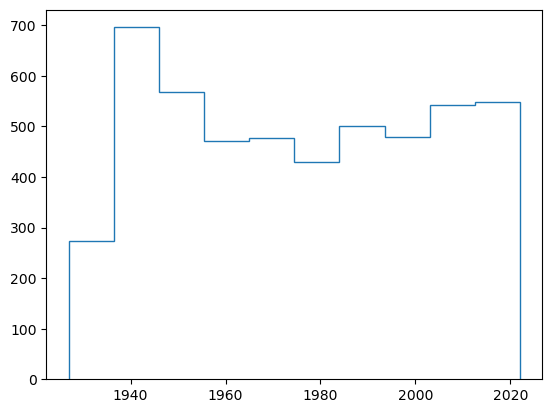

In [ ]:
plt.hist(awards_condensed.year, histtype='step') 

## IMDB ZONE

In [ ]:
IMDB_PATH = 'imdb_ratings_all_time/movies_imdb.csv'

In [ ]:
imdb_vanilla = pd.read_csv(DATA_PATH+IMDB_PATH, usecols=['id', 'name', 'year', 'rating', 'duration', 'votes', 'gross_income'], low_memory=False)

display(imdb_vanilla.sample(5))
display(imdb_vanilla.shape)
display(imdb_vanilla.info())
imdb_vanilla.isnull().sum()

,id,name,year,rating,duration,votes,gross_income
393062,tt7217486,Invisible Nights,(2016),11.0,48 min,0,0
975437,tt8219446,"Whitesnake: Fool for Your Loving, Version 1",(1980 Music Video),6.0,4 min,13,0
1682195,tt1454449,Best of UFC Fight Night,(2008 Video),7.4,110 min,15,0
2147077,tt0056323,Murder Can Be Deadly,(1962),6.4,60 min,107,0
2341562,tt11005270,Lingo,(1989–2014),11.0,0 min,0,0


(2590932, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2590932 entries, 0 to 2590931
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   name          object 
 2   year          object 
 3   rating        float64
 4   duration      object 
 5   votes         object 
 6   gross_income  object 
dtypes: float64(1), object(6)
memory usage: 138.4+ MB


None

id              0
name            4
year            0
rating          0
duration        0
votes           0
gross_income    0
dtype: int64

In [ ]:
imdb = imdb_vanilla.copy(deep=True)
imdb = imdb_vanilla.loc[~imdb_vanilla.name.isnull()]


display(imdb.sample(5))
display(imdb.shape)
display(imdb.info())
imdb.isnull().sum()

,id,name,year,rating,duration,votes,gross_income
453255,tt14236588,Streamed Shakespeare,(2020– ),11.0,0 min,0,0
2305,tt5332206,Signal,(2016),8.5,80 min,"6,735","39,673,161"
291347,tt0501210,13 Demon Street,(1959–1960),6.6,0 min,16,0
838000,tt13163718,Will you Mr Sax,(2020 Video),11.0,6 min,0,0
1578216,tt20778318,Amar en tiempos revueltos,(2005– ),11.0,0 min,0,0


(2590928, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 2590928 entries, 0 to 2590931
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   name          object 
 2   year          object 
 3   rating        float64
 4   duration      object 
 5   votes         object 
 6   gross_income  object 
dtypes: float64(1), object(6)
memory usage: 158.1+ MB


None

id              0
name            0
year            0
rating          0
duration        0
votes           0
gross_income    0
dtype: int64

In [ ]:
imdb[imdb['gross_income']!='0'].sample(5)

,id,name,year,rating,duration,votes,gross_income
2251369,tt0464165,The Queen's Sister,(2005 TV Movie),6.2,96 min,285,"300,000"
11834,tt0347573,Most Wanted,(2000),7.7,102 min,8,"6,758,000"
1995251,tt0102395,Mannequin: On the Move,(1991),4.3,95 min,6322,"3,752,426"
720248,tt0068662,The Great Waltz,(1972),5.0,135 min,249,"890,450"
1285727,tt0324618,La yegua colorada,(1973),7.0,88 min,19,"3,603,615"


In [ ]:
def clean_gross_income(value):
    if isinstance(value, str):
        value = value.replace(',', '').replace('$', '')
        if 'M' in value:
            value = float(value.replace('M', '')) * (10**6)
    return float(value)


In [ ]:
imdb.loc[:, 'gross_income'] = imdb['gross_income'].apply(lambda x: clean_gross_income(x))
display(imdb.sample(5))
display(imdb.shape)
display(imdb.info())
imdb[imdb['gross_income']!=0].sample(5)

,id,name,year,rating,duration,votes,gross_income
209490,tt2035949,Garo: Makaisenki,(2011– ),8.7,0 min,63,0.0
2546484,tt6041900,Extra! Extra!,(2006–2012),11.0,0 min,0,0.0
1392654,tt1844305,Femme Fatales,(2011–2012),7.4,30 min,92,0.0
1807146,tt1735650,Maestro,(1979–1989),11.0,0 min,0,0.0
1586659,tt2431734,Naruto: Shippûden,(2007–2017),6.3,23 min,237,0.0


(2590928, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 2590928 entries, 0 to 2590931
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   name          object 
 2   year          object 
 3   rating        float64
 4   duration      object 
 5   votes         object 
 6   gross_income  object 
dtypes: float64(1), object(6)
memory usage: 158.1+ MB


None

,id,name,year,rating,duration,votes,gross_income
833989,tt0086998,Breakin',(1984),5.8,87 min,6429,38682707.0
11208,tt0382621,Cronicas,(2004),6.8,108 min,3443,299261.0
381771,tt2400377,Kaksparsh,(2012),8.0,140 min,857,97711.0
195422,tt0058050,The Earth Dies Screaming,(1964),5.8,62 min,"1,875",742.0
721160,tt1247693,Sister Mary,(2011),3.1,100 min,114,3400000.0


In [ ]:
imdb.loc[:, 'votes'] = imdb['votes'].str.replace(',', '').astype(float)
display(imdb.sample(5))
display(imdb.shape)
display(imdb.info())

,id,name,year,rating,duration,votes,gross_income
1175278,tt13313784,The New Adventures of Pinocchio,(1960– ),11.0,0 min,0.0,0.0
894254,tt14329964,Siti Nordiana: Angkara,(2020 Video),11.0,0 min,0.0,0.0
188745,tt1257099,Reilly: Ace of Spies,(1983),7.8,51 min,56.0,0.0
1388211,tt1699658,The Extraordinary,(1993–1996),11.0,0 min,0.0,0.0
730407,tt4531334,Le Rêve de Giuseppe,(2015),11.0,17 min,0.0,0.0


(2590928, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 2590928 entries, 0 to 2590931
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   name          object 
 2   year          object 
 3   rating        float64
 4   duration      object 
 5   votes         object 
 6   gross_income  object 
dtypes: float64(1), object(6)
memory usage: 158.1+ MB


None

In [ ]:
imdb.loc[:, 'year'] = imdb['year'].str.extract(r'(\d+)', expand=False)
display(imdb.sample(5))
display(imdb.shape)
display(imdb.info())

,id,name,year,rating,duration,votes,gross_income
1723954,tt11087744,Tamanna,2016,11.0,0 min,0.0,0.0
1616812,tt5531244,Intrepid Journeys,2003,11.0,0 min,0.0,0.0
2125489,tt8145154,Dance Dance Dance,2018,11.0,9 min,0.0,0.0
1712744,tt0993041,Al rojo vivo con María Celeste,2002,11.0,0 min,0.0,0.0
2138593,tt14372686,Superior Soldiers,1993,11.0,0 min,0.0,0.0


(2590928, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 2590928 entries, 0 to 2590931
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   name          object 
 2   year          object 
 3   rating        float64
 4   duration      object 
 5   votes         object 
 6   gross_income  object 
dtypes: float64(1), object(6)
memory usage: 158.1+ MB


None

In [ ]:
# generate_missing_info(imdb)

imdb.loc[:, 'duration'] = imdb['duration'].str.extract(r'(\d+)', expand=False)
imdb.loc[:,'duration'] = imdb['duration'].astype(float)
display(imdb.sample(5))
display(imdb.shape)
display(imdb.info())

,id,name,year,rating,duration,votes,gross_income
804922,tt3464630,Pancake Manor,2011,11.0,0.0,0.0,0.0
2419415,tt16000472,It's Okay to Laugh!,1982,11.0,0.0,0.0,0.0
247573,tt14131366,The Sigil,2020,11.0,12.0,0.0,0.0
1888108,tt7826588,The Rich Eisen Show,2014,11.0,0.0,0.0,0.0
2323755,tt0807391,Ca$h Cab,2005,11.0,0.0,0.0,0.0


(2590928, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 2590928 entries, 0 to 2590931
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   name          object 
 2   year          object 
 3   rating        float64
 4   duration      object 
 5   votes         object 
 6   gross_income  object 
dtypes: float64(1), object(6)
memory usage: 158.1+ MB


None

In [ ]:
imdb.loc[:, 'duration'] = imdb['duration'].replace(0, np.nan)
imdb.loc[:, 'votes'] = imdb['votes'].replace(0, np.nan)
imdb.loc[:, 'gross_income'] = imdb['gross_income'].replace(0, np.nan)
imdb.loc[pd.isna(imdb['votes']), 'rating'] = np.nan
imdb

display(imdb.sample(5))
display(imdb.shape)
display(imdb.info())

generate_missing_info(imdb)

,id,name,year,rating,duration,votes,gross_income
2027660,tt0657159,Nanny and the Professor,1970,7.3,23.0,26.0,NaN
1897563,tt8884982,NFL Live,1991,NaN,NaN,NaN,NaN
651610,tt12321028,Judge Mills Lane,1998,NaN,NaN,NaN,NaN
1109346,tt10046190,Ballybraddan,2008,NaN,NaN,NaN,NaN
969296,tt19844698,Tanham Bezar,2014,NaN,NaN,NaN,NaN


(2590928, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 2590928 entries, 0 to 2590931
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   name          object 
 2   year          object 
 3   rating        float64
 4   duration      object 
 5   votes         object 
 6   gross_income  object 
dtypes: float64(1), object(6)
memory usage: 158.1+ MB


None

,Missing Data (%)
Column,
id,0.00
name,0.00
year,0.51
rating,75.66
duration,62.08
votes,75.66
gross_income,98.38


In [ ]:
imdb = imdb.dropna(subset=['year', 'duration']).reset_index(drop=True)
imdb = imdb.dropna(subset=['votes', 'gross_income'], how='all').reset_index(drop=True)

display(imdb.sample(5))
display(imdb.shape)
display(imdb.info())

generate_missing_info(imdb)

,id,name,year,rating,duration,votes,gross_income
11270,tt14668192,Elite Short Stories: Guzmán Caye Rebe,2021,7.4,36.0,2313.0,NaN
383557,tt4290974,Taking Earth,2017,2.6,100.0,1173.0,NaN
426611,tt0469722,All My Crazy Friends: The Movie,1998,8.5,39.0,16.0,NaN
220422,tt12072206,Thunderbolt Fantasy: Bewitching Melody of the ...,2019,7.8,90.0,43.0,NaN
248355,tt0927394,Ouran High School Host Club,2006,7.8,23.0,96.0,NaN


(470380, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470380 entries, 0 to 470379
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            470380 non-null  object 
 1   name          470380 non-null  object 
 2   year          470380 non-null  object 
 3   rating        470332 non-null  float64
 4   duration      470380 non-null  object 
 5   votes         470332 non-null  object 
 6   gross_income  39028 non-null   object 
dtypes: float64(1), object(6)
memory usage: 25.1+ MB


None

,Missing Data (%)
Column,
id,0.00
name,0.00
year,0.00
rating,0.01
duration,0.00
votes,0.01
gross_income,91.70


In [ ]:
imdb['year'] = pd.to_numeric(imdb['year'], errors='coerce')
imdb = imdb[imdb['year'] <= 2017].reset_index(drop=True)
display(imdb.sample(5))
display(imdb.shape)
display(imdb.info())

generate_missing_info(imdb)

,id,name,year,rating,duration,votes,gross_income
136389,tt1400059,Billy the Exterminator,2009,9.2,22.0,6.0,NaN
260483,tt0274881,Het spook van Monniksveer,1989,4.7,64.0,9.0,NaN
213921,tt0807597,Fireball XL5,1962,7.9,26.0,13.0,NaN
22480,tt0257587,Ellos trajeron la violencia,1990,5.8,90.0,11.0,NaN
355953,tt1683412,Des Kaisers neue Kleider,2010,6.3,58.0,165.0,NaN


(413721, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413721 entries, 0 to 413720
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            413721 non-null  object 
 1   name          413721 non-null  object 
 2   year          413721 non-null  int64  
 3   rating        413691 non-null  float64
 4   duration      413721 non-null  object 
 5   votes         413691 non-null  object 
 6   gross_income  31330 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 22.1+ MB


None

,Missing Data (%)
Column,
id,0.00
name,0.00
year,0.00
rating,0.01
duration,0.00
votes,0.01
gross_income,92.43


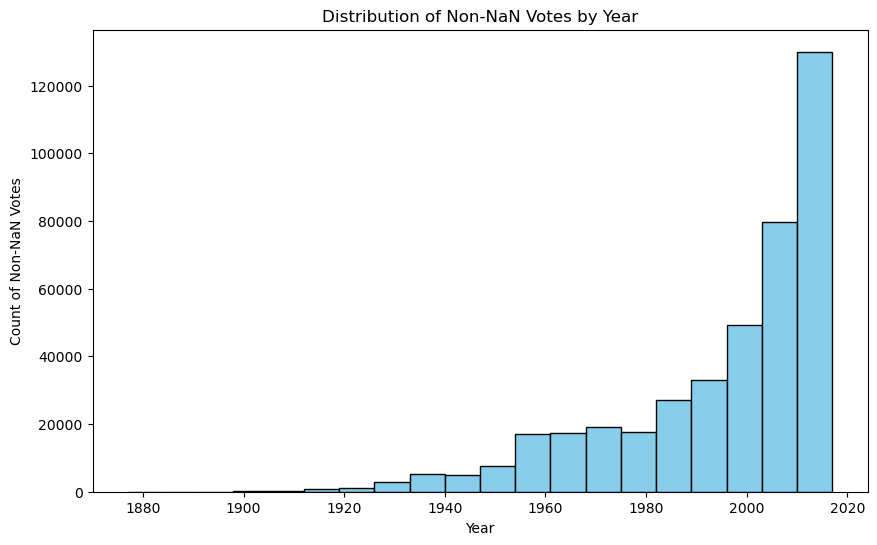

In [ ]:
non_nan_votes = imdb.dropna(subset=['votes'])

plt.figure(figsize=(10, 6))
plt.hist(non_nan_votes['year'].astype(int), bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Count of Non-NaN Votes')
plt.title('Distribution of Non-NaN Votes by Year')
plt.show()

In [ ]:
imdb = imdb[imdb['rating'] <= 10]
max_rating = imdb['rating'].max()
min_rating = imdb['rating'].min()

print(f'Highest Rating: {max_rating}')
print(f'Lowest Rating: {min_rating}')
display(imdb[imdb['rating'] == max_rating])

Highest Rating: 10.0
Lowest Rating: 1.0


,id,name,year,rating,duration,votes,gross_income
21528,tt3843938,Control Policial,2014,10.0,11.0,6.0,NaN
22589,tt4188692,"One Night, in an Alley",2014,10.0,13.0,5.0,NaN
24961,tt0393944,"Das Vergnügen, anständig zu sein",1962,10.0,55.0,10.0,NaN
26083,tt2078578,Crybabies,2011,10.0,13.0,7.0,NaN
29291,tt1513828,Monkeywrench,2010,10.0,10.0,5.0,NaN
...,...,...,...,...,...,...,...
403020,tt0479077,Intimate Portrait,1990,10.0,60.0,188.0,NaN
403090,tt1007848,A Taste of My Life,2006,10.0,30.0,97.0,NaN
405845,tt0643318,The Match Game,1962,10.0,25.0,25.0,NaN
406354,tt1007457,The Match Game,1962,10.0,25.0,23.0,NaN


In [ ]:
display(imdb[imdb['name']=='Star Wars'])

,id,name,year,rating,duration,votes,gross_income
282048,tt0076759,Star Wars,1977,8.6,121.0,1332366.0,322740140.0


In [ ]:
display(check_doublons(imdb, col_check=['name'], year='year', runtime='duration'))
display(imdb[imdb['name'].str.contains('Chopped')])
display(imdb[imdb['name']=='Wanted'])

Rows with real duplicates: 
                          name  year duration
752                     Wanted  2016     60.0
1170                   Maigret  2016     88.0
3900             Unconditional  2012     92.0
5096     Fixer Upper Mysteries  2017     90.0
5124               Blood Money  2012    109.0
...                        ...   ...      ...
413716               Jeopardy!  1984     30.0
413717              Shark Tank  2009     43.0
413718               Jeopardy!  1984     30.0
413719                 Chopped  2007     42.0
413720                 Chopped  2007     42.0

[182366 rows x 3 columns]
--------------------------------------------------------------------------------


None

,id,name,year,rating,duration,votes,gross_income
124945,tt1353281,Chopped,2007,7.4,60.0,3925.0,NaN
126011,tt3470148,Chopped Canada,2014,5.7,60.0,175.0,NaN
131091,tt10040750,Chopped,2007,8.6,42.0,11.0,NaN
131092,tt10040760,Chopped,2007,8.6,42.0,9.0,NaN
131193,tt10122940,Chopped,2007,8.9,42.0,9.0,NaN
...,...,...,...,...,...,...,...
413683,tt9732040,Chopped,2007,8.9,42.0,8.0,NaN
413691,tt9788470,Chopped,2007,8.4,42.0,8.0,NaN
413692,tt9788480,Chopped,2007,8.7,42.0,7.0,NaN
413719,tt9893108,Chopped,2007,9.0,42.0,7.0,NaN


,id,name,year,rating,duration,votes,gross_income
332,tt0493464,Wanted,2008,6.7,110.0,384407.0,134508551.0
752,tt5193358,Wanted,2016,7.6,60.0,5894.0,35000000.0
4262,tt1084972,Wanted,2009,6.6,147.0,24136.0,NaN
29535,tt1595489,Wanted,2009,4.8,5.0,6.0,NaN
127901,tt0808117,Wanted,1996,7.5,60.0,19.0,NaN
205519,tt0220845,Wanted,1999,3.7,12.0,12.0,NaN
240413,tt0062047,Wanted,1967,6.0,107.0,398.0,NaN
244002,tt7256136,Wanted,2017,6.3,8.0,29.0,NaN
244637,tt4559204,Wanted,2015,7.0,10.0,5.0,NaN
355845,tt0214292,Wanted,1999,6.7,90.0,431.0,NaN


In [ ]:
imdb_clean = imdb.copy(deep=True)
imdb_clean = fuse_duplicates(imdb, col_check=['name'], year='year', runtime='duration', col_len=[], col_null=['rating', 'votes', 'gross_income'])

display(imdb_clean.sample(5))
display(imdb_clean.shape)
display(imdb_clean.info())

Fusing duplicates: 


KeyboardInterrupt: 

## MOVIE STATS ZONE

In [ ]:
display(movies_stats.sample(5))
display(movies_stats.shape)
display(movies_stats.info())
display(generate_missing_info(movies_stats))
display(check_doublons(movies_stats, ['name'], 'year', 'runtime'))

,name,year,review,nbr_review,countries,revenue,runtime
5326,Milk,2008,7.5,167000.0,United States,54589558.0,128.0
4542,Taxi,2004,4.5,41000.0,United States,71255003.0,97.0
196,Paternity,1981,4.9,920.0,United States,18838812.0,94.0
4187,Dahmer,2002,5.6,9700.0,United States,144008.0,101.0
2841,The Walking Dead,1995,4.9,759.0,United States,6014341.0,88.0


(5377, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 5377 entries, 1 to 7659
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        5377 non-null   object 
 1   year        5377 non-null   int64  
 2   review      5377 non-null   float64
 3   nbr_review  5377 non-null   float64
 4   countries   5377 non-null   object 
 5   revenue     5377 non-null   float64
 6   runtime     5376 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 336.1+ KB


None

,Missing Data (%)
Column,
name,0.00
year,0.00
review,0.00
nbr_review,0.00
countries,0.00
revenue,0.00
runtime,0.02


No duplicates
--------------------------------------------------------------------------------


None

In [ ]:
display(movies_stats[movies_stats['name'].str.contains('Star Wars')])

,name,year,review,nbr_review,countries,revenue,runtime
2,Star Wars: Episode V - The Empire Strikes Back,1980,8.7,1200000.0,United States,5.383751e+08,124.0
333,Star Wars: Episode VI - Return of the Jedi,1983,8.3,973000.0,United States,4.751062e+08,131.0
3451,Star Wars: Episode I - The Phantom Menace,1999,6.5,748000.0,United States,1.027083e+09,136.0
4058,Star Wars: Episode II - Attack of the Clones,2002,6.5,658000.0,United States,6.537800e+08,142.0
4658,Star Wars: Episode III - Revenge of the Sith,2005,7.5,729000.0,United States,8.683906e+08,140.0
5366,Star Wars: The Clone Wars,2008,5.9,61000.0,United States,6.828284e+07,98.0
6663,Star Wars: Episode VII - The Force Awakens,2015,7.8,876000.0,United States,2.069522e+09,138.0
6869,Rogue One: A Star Wars Story,2016,7.8,572000.0,United States,1.056058e+09,133.0
7075,Star Wars: Episode VIII - The Last Jedi,2017,7.0,581000.0,United States,1.332699e+09,152.0
7261,Solo: A Star Wars Story,2018,6.9,306000.0,United States,3.929248e+08,135.0


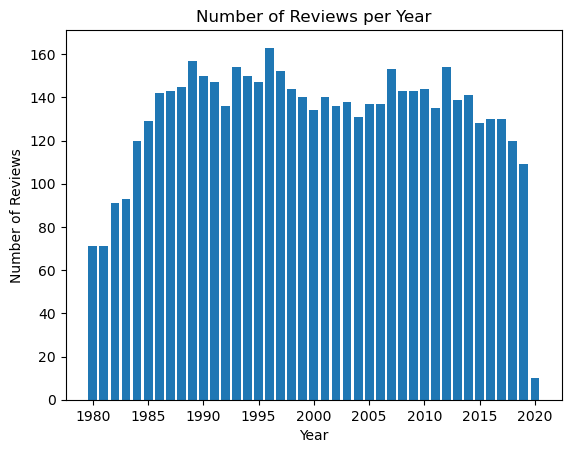

In [ ]:
reviews_count_per_year_stats = movies_stats.groupby('year')['review'].count().reset_index()

plt.bar(reviews_count_per_year_stats['year'], reviews_count_per_year_stats['review'])
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews per Year')
plt.show()

## MOVIELENS ZONE

In [ ]:
display(movies_lens.sample(5))
display(movies_lens.shape)
display(movies_lens.info())

,revenue,runtime,name,review,nbr_review,year
2545,4409328.0,91.0,Run,5.5,13.0,1991
1100,1012189.0,72.0,Dracula,7.2,254.0,1931
2208,68349884.0,91.0,Ghost Ship,5.3,540.0,2002
4299,19504039.0,107.0,Margin Call,6.7,531.0,2011
2796,30039392.0,99.0,Shaun of the Dead,7.5,2479.0,2004


(5619, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5619 entries, 0 to 5618
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   revenue     5619 non-null   float64
 1   runtime     5619 non-null   float64
 2   name        5619 non-null   object 
 3   review      5619 non-null   float64
 4   nbr_review  5619 non-null   float64
 5   year        5619 non-null   int32  
dtypes: float64(4), int32(1), object(1)
memory usage: 241.6+ KB


None

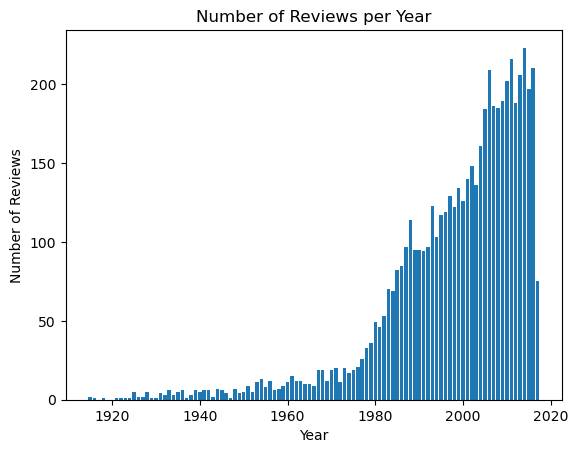

In [ ]:
reviews_count_per_year_lens = movies_lens.groupby('year')['review'].count().reset_index()

plt.bar(reviews_count_per_year_lens['year'], reviews_count_per_year_lens['review'])
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews per Year')
plt.show()

## MOVIELENS ZONE (REV & RATINGS) OLD AND TRASH

### Ratings

In [ ]:
BIG_RATINGS_PATH = '/ml-latest/ratings.csv'

In [ ]:
spark = SparkSession.builder.appName("Ratings").getOrCreate()
big_ratings = spark.read.csv(DATA_PATH+BIG_RATINGS_PATH, header=True, inferSchema=True)
big_ratings.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|      1|   4.0|1225734739|
|     1|    110|   4.0|1225865086|
|     1|    158|   4.0|1225733503|
|     1|    260|   4.5|1225735204|
|     1|    356|   5.0|1225735119|
+------+-------+------+----------+
only showing top 5 rows



In [ ]:
big_ratings_clean = big_ratings.groupBy("movieId").agg(
    F.avg("rating").alias("average_rating"),
    F.count("rating").alias("nbr_ratings")
)

big_ratings_clean.show()

+-------+------------------+-----------+
|movieId|    average_rating|nbr_ratings|
+-------+------------------+-----------+
|   1959| 3.633800573431029|       6278|
|   1591|2.6484306887532694|       6882|
|   1580| 3.595333426758223|      49951|
|   1645|  3.56697669143084|      17633|
|  44022|3.2430483271375463|       6725|
|   3175| 3.602825957745718|      18507|
|  32460|4.0208131655372705|       1033|
| 280218|3.4652701212789414|        907|
|    148|               2.9|        380|
|    471| 3.651588858375834|      12745|
|   8638| 4.005075757575757|       6600|
|  96488| 3.993886230728336|       1881|
|    496|3.3140877598152425|        433|
|   1088| 3.274450709702508|      15429|
|   2366|3.4753840782122905|       8592|
|   3918| 3.014236902050114|       1756|
|   1342|  3.02922642329422|       4602|
|  54190| 3.552968186290587|       3049|
|   7833| 3.819178082191781|        365|
|  31983|           3.53125|         48|
+-------+------------------+-----------+
only showing top

In [ ]:
num_rows = big_ratings_clean.count()
num_columns = len(big_ratings_clean.columns)
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

Number of rows: 83239
Number of columns: 3


In [ ]:
big_ratings_pd = big_ratings_clean.toPandas().rename(columns={'movieId': 'id'})
spark.stop()
display(big_ratings_pd.sample(5))
display(big_ratings_pd.shape)
display(big_ratings_pd.info())

,id,average_rating,nbr_ratings
38628,160838,3.000000,3
21226,272447,2.750000,2
25550,228665,0.500000,1
2040,73511,2.723214,168
19491,159221,3.500000,8


(83239, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83239 entries, 0 to 83238
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              83239 non-null  int32  
 1   average_rating  83239 non-null  float64
 2   nbr_ratings     83239 non-null  int64  
dtypes: float64(1), int32(1), int64(1)
memory usage: 1.6 MB


None

In [ ]:
display(big_ratings_pd.nbr_ratings.sort_values(ascending=False))
display(big_ratings_pd.average_rating.sort_values(ascending=False))

31405    122296
47237    113581
1123     108756
28098    107056
1616     101802
          ...  
13287         1
13288         1
13290         1
13292         1
83238         1
Name: nbr_ratings, Length: 83239, dtype: int64

35220    5.0
10911    5.0
13181    5.0
5227     5.0
2604     5.0
        ... 
82168    0.5
38833    0.5
82166    0.5
23567    0.5
13703    0.5
Name: average_rating, Length: 83239, dtype: float64

In [ ]:
RATING_PATH = 'movie_lens/ratings.csv'

In [ ]:
ratings_vanilla = pd.read_csv(DATA_PATH+RATING_PATH).drop(columns=['timestamp']).rename(columns={'movieId': 'id'})
display(ratings_vanilla.sample(5))
display(ratings_vanilla.shape)
display(ratings_vanilla.info())

,userId,id,rating
1835345,19028,4980.0,3.5
1365507,14046,4710.0,5.0
830309,8534,2124.0,4.0
2149097,22297,527.0,2.5
3914052,40680,2683.0,4.0


(7074477, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7074477 entries, 0 to 7074476
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   userId  int64  
 1   id      float64
 2   rating  float64
dtypes: float64(2), int64(1)
memory usage: 161.9 MB


None

In [ ]:
ratings = ratings_vanilla.copy(deep=True)
ratings = ratings.groupby('id').agg(average_rating=('rating', 'mean'),nbr_ratings=('rating', 'count')).reset_index()

display(ratings.sample(5))
display(ratings.shape)
display(ratings.info())

,id,average_rating,nbr_ratings
20013,102062.0,3.266667,15
24711,125269.0,4.500000,1
20167,102760.0,3.500000,6
13699,69444.0,2.250000,6
11566,51207.0,2.571429,7


(36379, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36379 entries, 0 to 36378
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              36379 non-null  float64
 1   average_rating  36379 non-null  float64
 2   nbr_ratings     36379 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 852.8 KB


None

### Revenue

In [ ]:
# Load MovieLens DF, need to modify it compared to M2 !

movies_lens_vanilla = pd.read_csv(MOVIE_LENS, usecols=['id', 'title', 'release_date', 'production_countries', 'revenue', 'runtime'])
movies_lens_vanilla = movies_lens_vanilla.rename(columns={'production_countries': 'countries',                                                     
                                                         'title': 'name'})
display(movies_lens_vanilla.sample(5))
display(movies_lens_vanilla.shape)
display(movies_lens_vanilla.info())

,id,countries,release_date,revenue,runtime,name
27812,43754,"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-02-14,0.0,92.0,The Killing Jar
37637,41988,"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-07-27,0.0,12.0,DC Showcase: Jonah Hex
43089,52280,"[{'iso_3166_1': 'US', 'name': 'United States o...",1933-03-03,0.0,21.0,The Fatal Glass of Beer
35824,303665,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",2014-10-23,0.0,92.0,Journey to Le Mans
19939,97598,"[{'iso_3166_1': 'US', 'name': 'United States o...",1941-12-18,0.0,88.0,Kathleen


(45466, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            45466 non-null  object 
 1   countries     45463 non-null  object 
 2   release_date  45379 non-null  object 
 3   revenue       45460 non-null  float64
 4   runtime       45203 non-null  float64
 5   name          45460 non-null  object 
dtypes: float64(2), object(4)
memory usage: 2.1+ MB


None

In [ ]:
# WASH MACHINE

movies_lens = movies_lens_vanilla.copy(deep=True)
zero_data = movies_lens[(movies_lens.revenue <= 0)|(movies_lens.revenue.isna()|movies_lens.release_date.isna())]
movies_lens.drop(zero_data.index,inplace=True)
movies_lens.reset_index(drop=True, inplace=True)

movies_lens.loc[:, 'year'] = movies_lens['release_date'].str.split('-', expand=True)[0]
movies_lens.loc[:, 'year'] = movies_lens['year'].astype(int)
movies_lens = movies_lens.drop(columns='release_date')


movies_lens.loc[movies_lens['runtime'] < 0, 'runtime'] = 0
movies_lens['runtime'] = movies_lens['runtime'].replace(0, pd.NA)

movies_lens['year'] = movies_lens['year'].astype(int)
movies_lens['runtime'] = pd.to_numeric(movies_lens['runtime'], errors='coerce')

# Handling format
movies_lens['countries'] = movies_lens['countries'].apply(lambda x: [country['name'] for country in ast.literal_eval(x)] if pd.notna(x) else [])

# Handle multi-countries movies to keep only one country per movie (prioritize USA above others)
movies_lens = separate_values_biased(movies_lens, 'countries', 'United States of America')
movies_lens = movies_lens[movies_lens['countries']=='United States of America'].drop(columns='countries')

display(check_doublons(movies_lens, ['name'], 'year', 'runtime'))

movies_lens = fuse_duplicates(movies_lens, col_check=['name'], year='year', runtime='runtime',
                         col_len=[], col_null=['revenue'])

check_doublons(movies_lens, ['name'], 'year', 'runtime')

movies_lens['id'] = movies_lens['id'].astype(int)

display(movies_lens.sample(5))
display(movies_lens.shape)
display(movies_lens.info())


Rows with real duplicates: 
                                             name  year  runtime
415                            A Farewell to Arms  1932     89.0
2301                                Clockstoppers  2002     94.0
2444  Pokémon 4Ever: Celebi - Voice of the Forest  2001     75.0
2548              Confessions of a Dangerous Mind  2002    113.0
4721                           A Farewell to Arms  1932     89.0
6692                                Clockstoppers  2002     94.0
6695              Confessions of a Dangerous Mind  2002    113.0
7381  Pokémon 4Ever: Celebi - Voice of the Forest  2001     75.0
--------------------------------------------------------------------------------


None

Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------
No duplicates
--------------------------------------------------------------------------------


,id,revenue,runtime,name,year
1274,36094,5820015.0,104.0,Stanley & Iris,1990
3740,13825,558000.0,99.0,The Lazarus Project,2008
3809,18162,68688831.0,102.0,Land of the Lost,2009
1936,9778,77516304.0,90.0,Serendipity,2001
5472,14631,2025032.0,100.0,The Work and the Glory II: American Zion,2005


(5619, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5619 entries, 0 to 5618
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       5619 non-null   int32  
 1   revenue  5619 non-null   float64
 2   runtime  5619 non-null   float64
 3   name     5619 non-null   object 
 4   year     5619 non-null   int32  
dtypes: float64(2), int32(2), object(1)
memory usage: 175.7+ KB


None

In [ ]:
display(movies[movies['name'].str.contains('Star Wars', case=False, na=False)])
display(movies_lens[movies_lens['name'].str.contains('Star Wars', case=False, na=False)])

,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
4355,15726696,/m/0cpllql,Star Wars: The Clone Wars,2008,6.828284e+07,90.0,[English Language],[USA],"[Thriller, Science Fiction, Adventure, Compute..."
5454,50957,/m/0dfw0,Star Wars Episode II: Attack of the Clones,2002,6.493983e+08,142.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."
8240,1861566,/m/061wqh,Saving Star Wars,2004,NaN,117.0,[English Language],[USA],"[Indie, Comedy]"
14376,50744,/m/0ddjy,Star Wars Episode VI: Return of the Jedi,1983,4.751062e+08,135.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."
28976,3336298,/m/096gqt,The Making of Star Wars,1977,NaN,50.0,[English Language],[USA],[Documentary]
45820,50793,/m/0ddt_,Star Wars Episode I: The Phantom Menace,1999,1.027045e+09,136.0,[English Language],[USA],"[Science Fiction, Action, Fantasy, Adventure, ..."
51167,53964,/m/0f3m1,Star Wars Episode V: The Empire Strikes Back,1980,5.383751e+08,124.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."
51391,185264,/m/0199wf,The Star Wars Holiday Special,1978,NaN,97.0,[English Language],[USA],"[Science Fiction, Adventure, Holiday Film, Ani..."
57081,55447,/m/0fdv3,Star Wars Episode III: Revenge of the Sith,2005,8.487548e+08,140.0,[English Language],[USA],"[Science Fiction, Action, Fantasy, Tragedy, Ad..."
62252,1823554,/m/05zsyv,Star Wars: Revelations,2005,NaN,47.0,[English Language],[USA],"[Fan film, Indie]"


,id,revenue,runtime,name,year
120,11,7.753980e+08,121.0,Star Wars,1977
1095,1893,9.243176e+08,136.0,Star Wars: Episode I - The Phantom Menace,1999
2094,1894,6.493983e+08,142.0,Star Wars: Episode II - Attack of the Clones,2002
3014,1895,8.500000e+08,140.0,Star Wars: Episode III - Revenge of the Sith,2005
3656,12180,6.828284e+07,98.0,Star Wars: The Clone Wars,2008
5037,140607,2.068224e+09,136.0,Star Wars: The Force Awakens,2015
5509,330459,1.056057e+09,133.0,Rogue One: A Star Wars Story,2016


### MOVIE LENS MERGE

In [ ]:
movies_lens_tot = pd.merge(big_ratings_pd, movies_lens, on='id', how='right')

display(movies_lens_tot.sample(5))
display(movies_lens_tot.shape)
display(movies_lens_tot.info())

,id,average_rating,nbr_ratings,revenue,runtime,name,year
2983,23916,NaN,NaN,7185518.0,107.0,Paradise Alley,1978
5097,201085,NaN,NaN,74679822.0,119.0,Crimson Peak,2015
114,47867,NaN,NaN,3992809.0,90.0,Gordy,1995
5448,278924,NaN,NaN,125729635.0,99.0,Mechanic: Resurrection,2016
975,12118,NaN,NaN,43579163.0,83.0,Police Academy 3: Back in Training,1986


(5619, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5619 entries, 0 to 5618
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              5619 non-null   int32  
 1   average_rating  1657 non-null   float64
 2   nbr_ratings     1657 non-null   float64
 3   revenue         5619 non-null   float64
 4   runtime         5619 non-null   float64
 5   name            5619 non-null   object 
 6   year            5619 non-null   int32  
dtypes: float64(4), int32(2), object(1)
memory usage: 263.5+ KB


None

In [ ]:
# Check for missing values in big_ratings_pd
print(big_ratings_pd["id"].isnull().sum())

# Check for missing values in movies_lens
print(movies_lens["id"].isnull().sum())

# Check unique values in big_ratings_pd
print(big_ratings_pd["id"].unique())

# Check unique values in movies_lens
print(movies_lens["id"].unique())

mismatched_entries = pd.merge(big_ratings_pd, movies_lens, on="id", how="outer", indicator=True).query('_merge != "both"')
print(mismatched_entries.head())

0
0
[  1959   1591   1580 ... 264496 215885 189287]
[   862   8844  31357 ... 353491 378236 395834]
       id  average_rating  nbr_ratings  revenue  runtime name  year     _merge
0    1959        3.633801       6278.0      NaN      NaN  NaN   NaN  left_only
1    1591        2.648431       6882.0      NaN      NaN  NaN   NaN  left_only
4   44022        3.243048       6725.0      NaN      NaN  NaN   NaN  left_only
6   32460        4.020813       1033.0      NaN      NaN  NaN   NaN  left_only
7  280218        3.465270        907.0      NaN      NaN  NaN   NaN  left_only


In [ ]:
movie_lens_tot2 = pd.merge(ratings, movies_lens, on='id', how='right')

display(movie_lens_tot2.sample(5))
display(movie_lens_tot2.shape)
display(movie_lens_tot2.info())

,id,average_rating,nbr_ratings,revenue,runtime,name,year
4525,58547.0,NaN,NaN,201146.0,100.0,10 Years,2011
1862,9972.0,NaN,NaN,22099847.0,115.0,Lock Up,1989
1031,18588.0,NaN,NaN,5186646.0,110.0,52 Pick-Up,1986
4268,72711.0,NaN,NaN,282448.0,125.0,The Interrupters,2011
2492,10147.0,NaN,NaN,76488889.0,91.0,Bad Santa,2003


(5619, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5619 entries, 0 to 5618
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              5619 non-null   float64
 1   average_rating  1536 non-null   float64
 2   nbr_ratings     1536 non-null   float64
 3   revenue         5619 non-null   float64
 4   runtime         5619 non-null   float64
 5   name            5619 non-null   object 
 6   year            5619 non-null   int32  
dtypes: float64(5), int32(1), object(1)
memory usage: 285.5+ KB


None

## TRASH CAN UNDERNEATH

In [ ]:
movies3 = movies2_clean.copy()
movies3 = pd.merge(movies2_clean, awards_condensed, on=['name', 'year'], how='left')

display(movies3.sample(5))
display(movies3.shape)
display(movies3.info())

,id_wiki,id_freebase,name,year,runtime,lang,countries,genres,review,nbr_review,revenue,revenue_part,year_ceremony,ceremony,cat_nominated,name_nominated,winner
1515,6469252,/m/0g6j0h,Shooter,2007,126.0,[English Language],[USA],"[Thriller, Film adaptation, Action/Adventure, ...",NaN,NaN,95696996.0,0.004946,NaN,NaN,NaN,NaN,NaN
5349,23270459,/m/0661ql3,Inception,2010,148.0,"[French Language, Japanese Language, English L...","[USA, United Kingdom]","[Thriller, Science Fiction, Adventure, Psychol...",8.795340,2114075.0,828358814.75,0.03707,2011.0,83.0,"[ART DIRECTION, CINEMATOGRAPHY, MUSIC (Origina...",[Production Design: Guy Hendrix Dyas; Set Deco...,"[False, True, False, False, True, True, True, ..."
1191,7271954,/m/0kv2w7,Blood and Chocolate,2007,98.0,"[Romanian Language, English Language]","[USA, Romania, United Kingdom, Germany]","[Crime Fiction, Horror, Creature Film, Drama, ...",NaN,NaN,6311117.0,0.000326,NaN,NaN,NaN,NaN,NaN
5709,770156,/m/03b1n2,But I'm a Cheerleader,1999,85.0,[English Language],[USA],"[Romantic comedy, Gay Interest, Comedy-drama, ...",6.699306,29101.0,2596412.0,0.0002,NaN,NaN,NaN,NaN,NaN
3264,18996,/m/04ssf,Mean Streets,1973,112.0,"[Italian Language, English Language]",[USA],"[Crime Fiction, Drama, Coming of age, Gangster...",NaN,NaN,3000000.0,0.002468,NaN,NaN,NaN,NaN,NaN


(7285, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7285 entries, 0 to 7284
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_wiki         7285 non-null   int64  
 1   id_freebase     7285 non-null   object 
 2   name            7285 non-null   object 
 3   year            7285 non-null   int32  
 4   runtime         7260 non-null   float64
 5   lang            7285 non-null   object 
 6   countries       7285 non-null   object 
 7   genres          7285 non-null   object 
 8   review          2898 non-null   float64
 9   nbr_review      2898 non-null   float64
 10  revenue         7285 non-null   object 
 11  revenue_part    7285 non-null   object 
 12  year_ceremony   1277 non-null   float64
 13  ceremony        1277 non-null   float64
 14  cat_nominated   1277 non-null   object 
 15  name_nominated  1277 non-null   object 
 16  winner          1277 non-null   object 
dtypes: float64(5), int32(1), int64(1)

None

In [ ]:
movies3['oscar_nomination'] = pd.notna(movies3['ceremony'])

In [ ]:
movies3.insert(movies3.columns.get_loc('revenue_part') + 1, 'oscar_nomination', movies3.pop('oscar_nomination'))
movies3 = movies3.drop(columns=['year_ceremony', 'ceremony'])

display(movies3.sample(5))
display(movies3.shape) 
display(movies3.info())

,id_wiki,id_freebase,name,year,runtime,lang,countries,genres,review,nbr_review,revenue,revenue_part,oscar_nomination,cat_nominated,name_nominated,winner
5439,30296552,/m/0g5r4sy,Another Earth,2011,90.0,[English Language],[USA],"[Science Fiction, Mystery, Fantasy, Drama, Rom...",NaN,NaN,1776935.0,0.000077,False,NaN,NaN,NaN
651,779536,/m/03bq6g,Fat Man and Little Boy,1989,126.0,[English Language],[USA],"[Period piece, Drama, War film]",NaN,NaN,3563162.0,0.000595,False,NaN,NaN,NaN
1565,4845206,/m/0cqnq8,Sodom and Gomorrah,1962,120.0,[English Language],"[USA, France, Italy]","[History, Drama, Adventure, Historical drama]",NaN,NaN,2300000.0,0.008804,False,NaN,NaN,NaN
2013,430975,/m/027p7w,Harvard Man,2002,99.0,[English Language],"[USA, Canada]","[Crime Fiction, Thriller, Gangster Film, Indie...",NaN,NaN,56653.0,0.000003,False,NaN,NaN,NaN
3056,386476,/m/0227ry,The Frisco Kid,1979,114.0,[English Language],[USA],"[Action/Adventure, Western, Buddy film, Comedy...",6.0,38.0,9346177.0,0.004882,False,NaN,NaN,NaN


(7285, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7285 entries, 0 to 7284
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id_wiki           7285 non-null   int64  
 1   id_freebase       7285 non-null   object 
 2   name              7285 non-null   object 
 3   year              7285 non-null   int32  
 4   runtime           7260 non-null   float64
 5   lang              7285 non-null   object 
 6   countries         7285 non-null   object 
 7   genres            7285 non-null   object 
 8   review            2898 non-null   float64
 9   nbr_review        2898 non-null   float64
 10  revenue           7285 non-null   object 
 11  revenue_part      7285 non-null   object 
 12  oscar_nomination  7285 non-null   bool   
 13  cat_nominated     1277 non-null   object 
 14  name_nominated    1277 non-null   object 
 15  winner            1277 non-null   object 
dtypes: bool(1), float64(3), int32(1), int64(1)

None